# Benchmarking 2D / 3D PORTRAITS + Correlation diagrams + Correlation factors 
--------

In [162]:
# import
from multidimvis_main import *

## SMALL EXAMPLE NETWORK (thesis images)

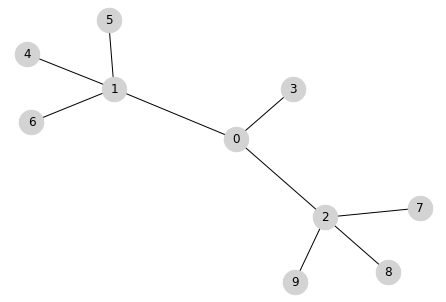

In [890]:
# TREE GRAPH
organism = 'tree'
n = 10 # number of nodes
r = 3 # branching factor
G = nx.full_rary_tree(r, n)
nx.draw(G, node_color ='lightgrey', node_size=600.0,with_labels=True)

## CHOOSE A TOY NETWORK

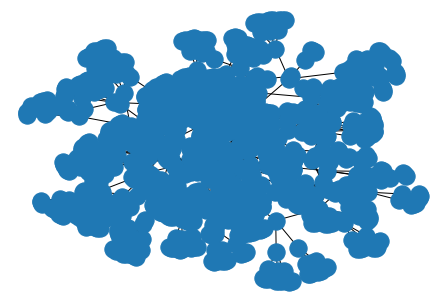

In [163]:
# TREE GRAPH
organism = 'tree'
n = 1000
r = 3
G = nx.full_rary_tree(r,n)
nx.draw(G)

# STAR GRAPH
#organism = 'star'
#n = 1000
#G = nx.star_graph(n)

# CYCLE GRAPH
#organism = 'cycle'
#n = 1000
#G = nx.cycle_graph(n)

In [ ]:
# 3D grid 
organism = 'grid'

G_grid = nx.grid_graph([10,10,10],periodic=False)
G = G_grid 
nx.draw(G)

In [ ]:
# Torus 
organism = 'torus'

G_tor = nx.grid_2d_graph(44,23,periodic=True) #24,12
G = G_tor
nx.draw(G)

## NETWORK

In [164]:
print('Network:', organism)
print('Number of nodes: %s' %len(list(G.nodes())))
print('Number of edges: %s' %len(list(G.edges())))
print('Network density: %.1f%%' %(200.*len(list(G.edges()))/(len(list(G.nodes()))*len(list(G.nodes()))-1)))

Network: tree
Number of nodes: 1000
Number of edges: 999
Network density: 0.2%


___________
## NETWORK DISTANCE 
___________

In [165]:
%%time 

d_idx_entz = {}
cc = 0
for entz in sorted(G.nodes()):
    d_idx_entz[cc] = entz
    cc += 1

Mspl = np.zeros(len(list(G.nodes())))

for n1 in range(len(list(G.nodes()))):
    vec = []
    for n2 in range(len(list(G.nodes()))):
        geneA = d_idx_entz[n1]
        geneB = d_idx_entz[n2]
        try:
            spl = round(nx.shortest_path_length(G,geneA,geneB),1)
            vec.append(spl)
        except nx.NetworkXNoPath:
            print('no path')
        
    Mspl = np.vstack((Mspl,vec))
Mspl = np.delete(Mspl, (0), axis=0)

DM_spl = pd.DataFrame(Mspl, columns = list(G.nodes()), index=list(G.nodes()))

#DM_spl.astype(int)

CPU times: user 35.6 s, sys: 1.58 s, total: 37.1 s
Wall time: 37.4 s


+ PREDEFINED FEATURE MATRIX

In [166]:
# DEGREE CENTRALITY - Node degree: important nodes being involved within high number of interactions
degs = dict(G.degree())
d_deghubs = {}
for node, de in sorted(degs.items(),key = lambda x: x[1], reverse = 1):
    d_deghubs[node] = round(float(de/max(degs.values())),4)
    
# CLOSENESSCENTRALITY - Measures how closely a node is connected to all other nodes to highlight f.ex. core-periphery structure, or identify central nodes
closeness = nx.closeness_centrality(G)
d_clos = {}
for node, cl in sorted(closeness.items(), key = lambda x: x[1], reverse = 1):
    d_clos[node] = round(cl,4)
    
# BETWEENESS CENTRALITY - How many shortest paths between pairs of other nodes in the network go through one node. High BC indicates "bottleneck nodes" in the network
betweens = nx.betweenness_centrality(G)
d_betw = {}
for node, be in sorted(betweens.items(), key = lambda x: x[1], reverse = 1):
     d_betw[node] = round(be,4)
    
# EIGENVECTOR CENTRALITY - Compute the eigenvector centrality for the graph
eigen = nx.eigenvector_centrality(G)
d_eigen = {}
for node, eig in sorted(eigen.items(), key = lambda x: x[1], reverse = 1):
     d_eigen[node] = round(eig,4)
    
d_deghubs_sorted = {key:d_deghubs[key] for key in sorted(d_deghubs.keys())}
d_clos_sorted = {key:d_clos[key] for key in sorted(d_clos.keys())}
d_betw_sorted = {key:d_betw[key] for key in sorted(d_betw.keys())}
d_eigen_sorted = {key:d_eigen[key] for key in sorted(d_eigen.keys())}

# feature collection
feature_dict = dict(zip(d_deghubs_sorted.keys(), zip(
                                                     d_deghubs_sorted.values(), 
                                                     d_clos_sorted.values(), 
                                                     d_betw_sorted.values(), 
                                                     d_eigen_sorted.values(),
                                                    )))

# IMPORTANT :
# sort all feature according to Graph node IDs
feature_dict_sorted = {key:feature_dict[key] for key in G.nodes()}
feature_df = pd.DataFrame.from_dict(feature_dict_sorted, orient = 'index', columns = ['degs', 
                                                                                      'clos', 
                                                                                      'betw', 
                                                                                      'eigen',
                                                                                      ]) 


# CENTRALITY 

metric = "cosine" 
DM_cent = pd.DataFrame(distance.squareform(distance.pdist(feature_df, metric)))
DM_cent.index = list(G.nodes())
DM_cent.colu
ns = list(G.nodes())

round(DM_cent,2)

PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')

____________
## PRE-SETTINGS
____________

In [191]:
# General Parameters:
# Node, Edge colors

edge_width = 2
edge_col = 'lightgrey'
edge_colordark = 'dimgrey'
opacity_edges = 0.5

opacity_nodes = 1.0
node_edge_col = None


# Node sizes 

scalef= 0.2
size = list(draw_node_degree(G, scalef).values())

scalef= 0.05
size3d = list(draw_node_degree_3D(G, scalef).values())

color_method = 'clos'
d_to_be_col = d_clos # dict sorted by dict.values (that way the biggest value matches darkest colour of palette)
colours = color_nodes_from_dict(G, d_to_be_col, color_method)

______________
# 2D BENCHMARK - visual + statistical 
______________

### SPRING

In [225]:
%%time

posG_spring2D = nx.spring_layout(G, iterations = 200, dim = 2)

CPU times: user 17.1 s, sys: 51.6 ms, total: 17.1 s
Wall time: 17.2 s


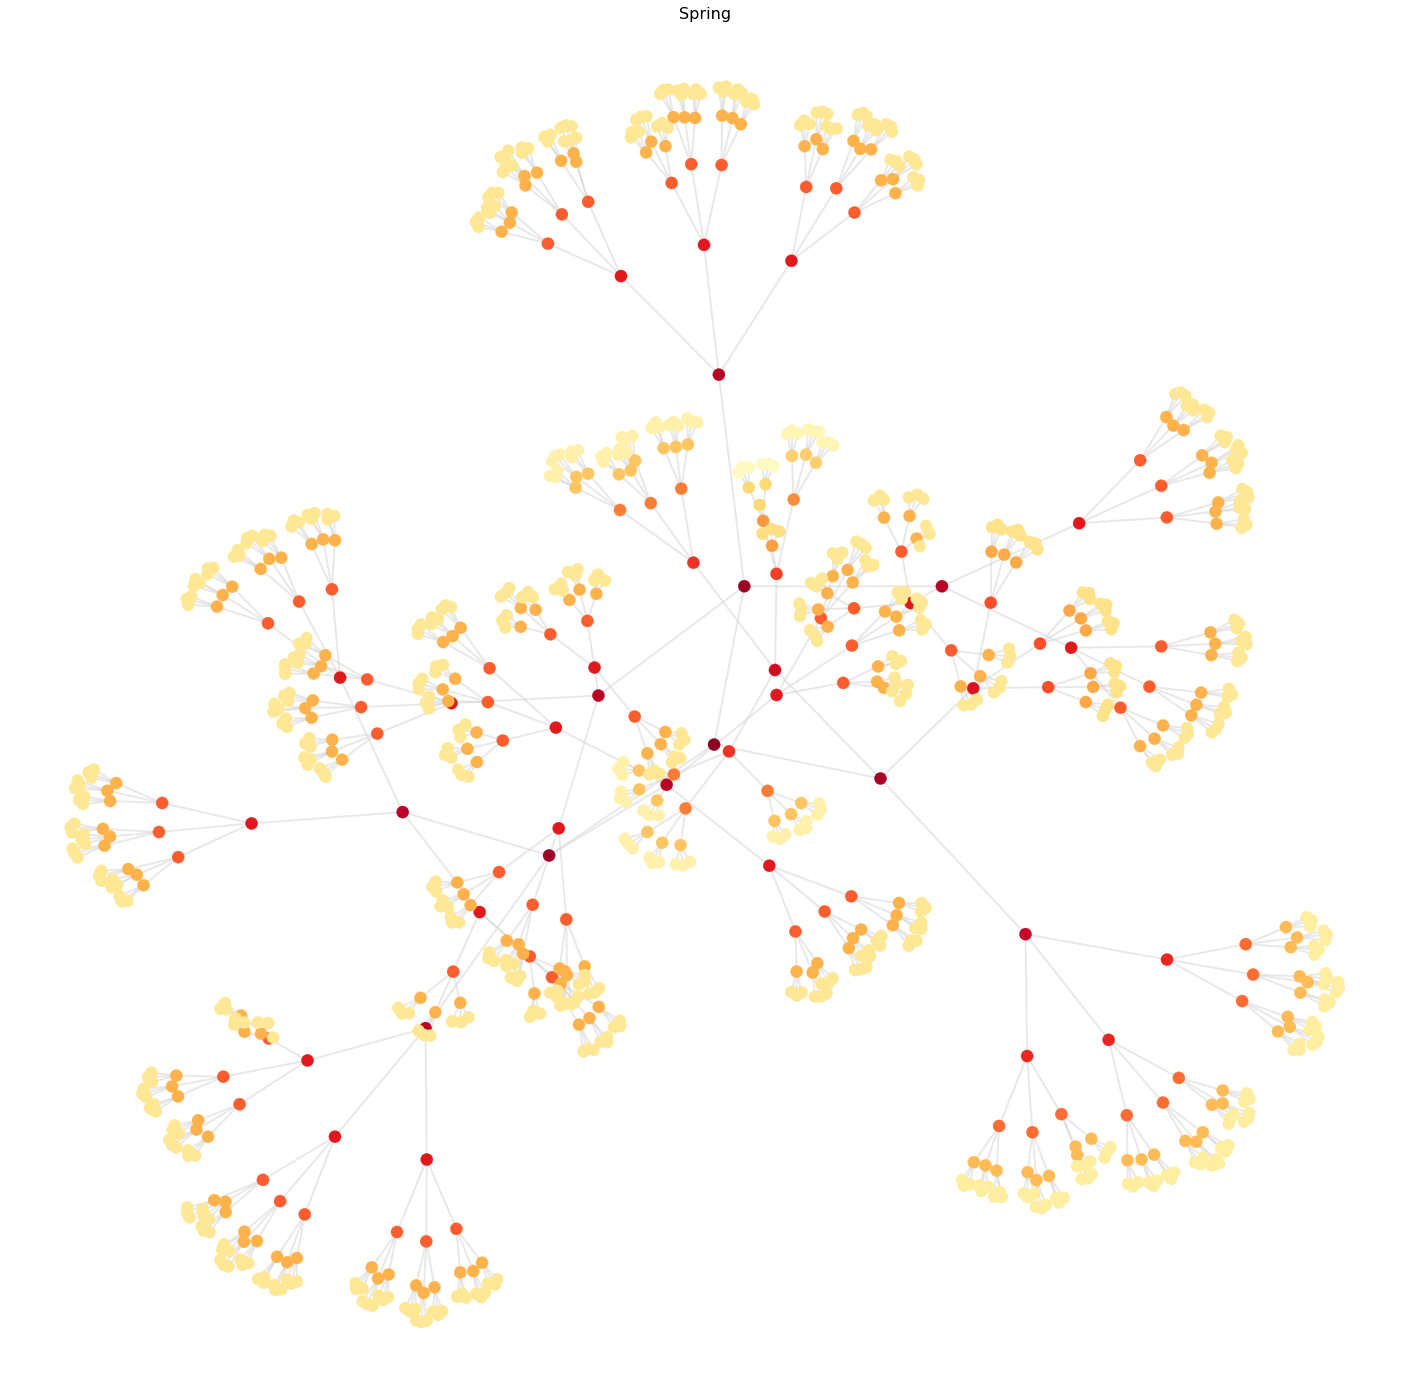

In [226]:
# normalize coordinates 
x_list = []
y_list = []
for k,v in posG_spring2D.items():
    x_list.append(v[0])
    y_list.append(v[1])
    
xx_norm = sklearn.preprocessing.minmax_scale(x_list, feature_range=(0, 1), axis=0, copy=True)
yy_norm = sklearn.preprocessing.minmax_scale(y_list, feature_range=(0, 1), axis=0, copy=True)

posG_spring2D_norm = dict(zip(list(G.nodes()), zip(xx_norm,yy_norm)))


plt.figure(figsize=(25,25))
plt.title('Spring', size= 16)

nx.draw_networkx_nodes(G, posG_spring2D_norm, edgecolors = node_edge_col, linewidths = 0.25, node_color = colours, 
                       node_size= 150, #size, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_spring2D_norm, width = edge_width, edge_color = edge_col, alpha = opacity_edges)

plt.box(False)

plt.savefig('output_plots/2Dspring_'+organism+'.png')

plt.show()

## 2D PORTRAITS 

+ ADJACENCIES

In [227]:
n_neighbors = 20 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.10 #defines how dense points are stacked together 
metric ='cosine'

In [228]:
%%time

feature = 'ADJ'

A = nx.adjacency_matrix(G)
adj = A.toarray()
df_adj = pd.DataFrame(adj, columns = list(G.nodes()), index=list(G.nodes()))
DM = df_adj

umap_adj = embed_umap_2D(DM, n_neighbors, spread, min_dist, metric)

posG_umap_adj = get_posG_2D(G.nodes(), umap_adj)
posG_complete_umap_adj = {key:posG_umap_adj[key] for key in G.nodes()}

CPU times: user 5.93 s, sys: 243 ms, total: 6.18 s
Wall time: 4.01 s


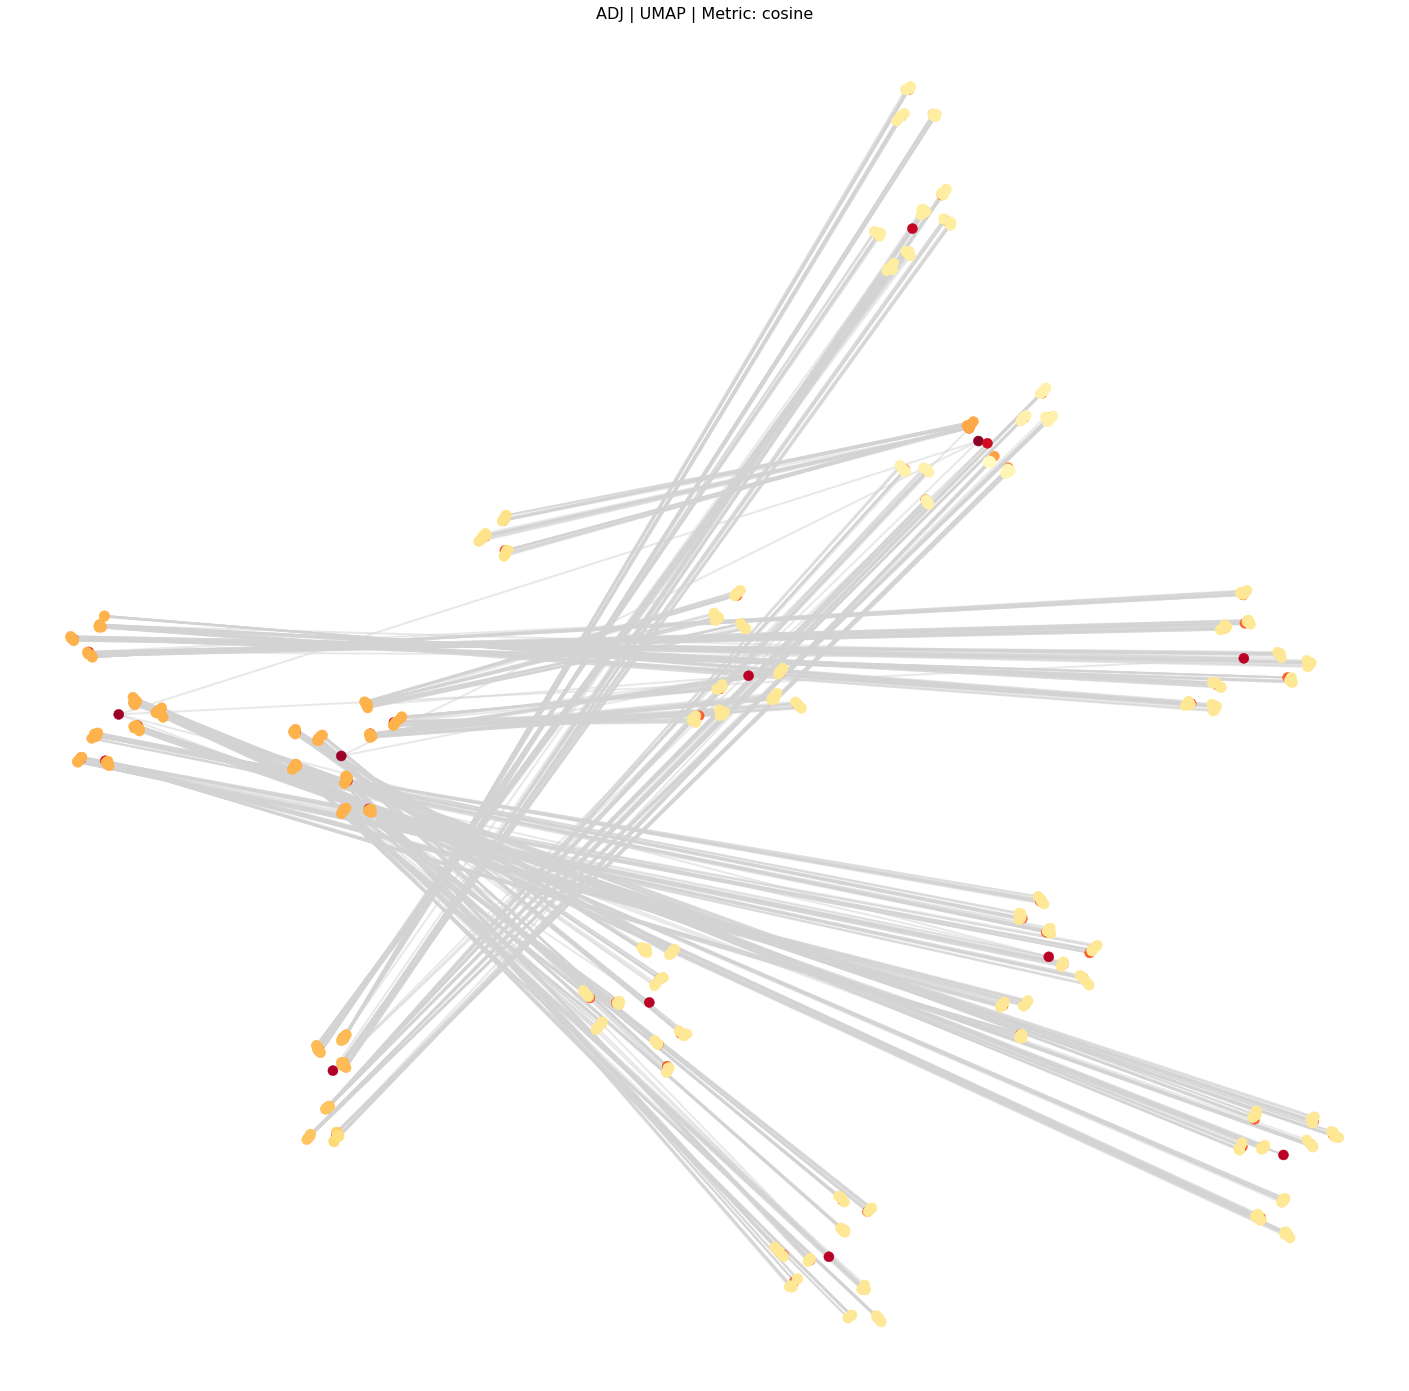

In [229]:
# normalize coordinates 
x_adj_list = []
y_adj_list = []
for k,v in posG_complete_umap_adj.items():
    x_adj_list.append(v[0])
    y_adj_list.append(v[1])
    
xx_adj_norm = sklearn.preprocessing.minmax_scale(x_adj_list, feature_range=(0, 1), axis=0, copy=True)
yy_adj_norm = sklearn.preprocessing.minmax_scale(y_adj_list, feature_range=(0, 1), axis=0, copy=True)

posG_complete_umap_adj_norm = dict(zip(list(G.nodes()), zip(xx_adj_norm,yy_adj_norm)))


plt.figure(figsize=(25,25))
plt.title(
    feature+' | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_complete_umap_adj_norm, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, 
                       node_size = 100, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_complete_umap_adj_norm, width = edge_width, edge_color = edge_col, alpha = opacity_edges)
plt.box(False)

plt.savefig('output_plots/2Dtoynetworkumap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.png')

plt.show()

+ RANDOM WALK

In [268]:
n_neighbors = 10 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.1 #defines how dense points are stacked together 
metric ='cosine'

In [269]:
%%time 

feature = 'RWR'

r = .9 # restart probability; originally 0.8
alpha = 1.0
# alpha = 0.5 # --> better results for torus 

FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
FM_m = pd.DataFrame(FM_m_array)
FM_m_transposed = FM_m.T

#DM_m_new = pd.DataFrame(1-distance.squareform(distance.pdist(DM_m_transposed, metric)))
DM_m = pd.DataFrame(distance.squareform(distance.pdist(FM_m_transposed, metric)))

DM_m.index = list(G.nodes())
DM_m.columns = list(G.nodes())

np.fill_diagonal(DM_m.values, 0)
DM = DM_m


umap_rwr = embed_umap_2D(DM, n_neighbors, spread, min_dist, metric)

posG_umap_rwr = get_posG_2D(G.nodes(), umap_rwr)
posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}

CPU times: user 7.87 s, sys: 335 ms, total: 8.2 s
Wall time: 4.9 s


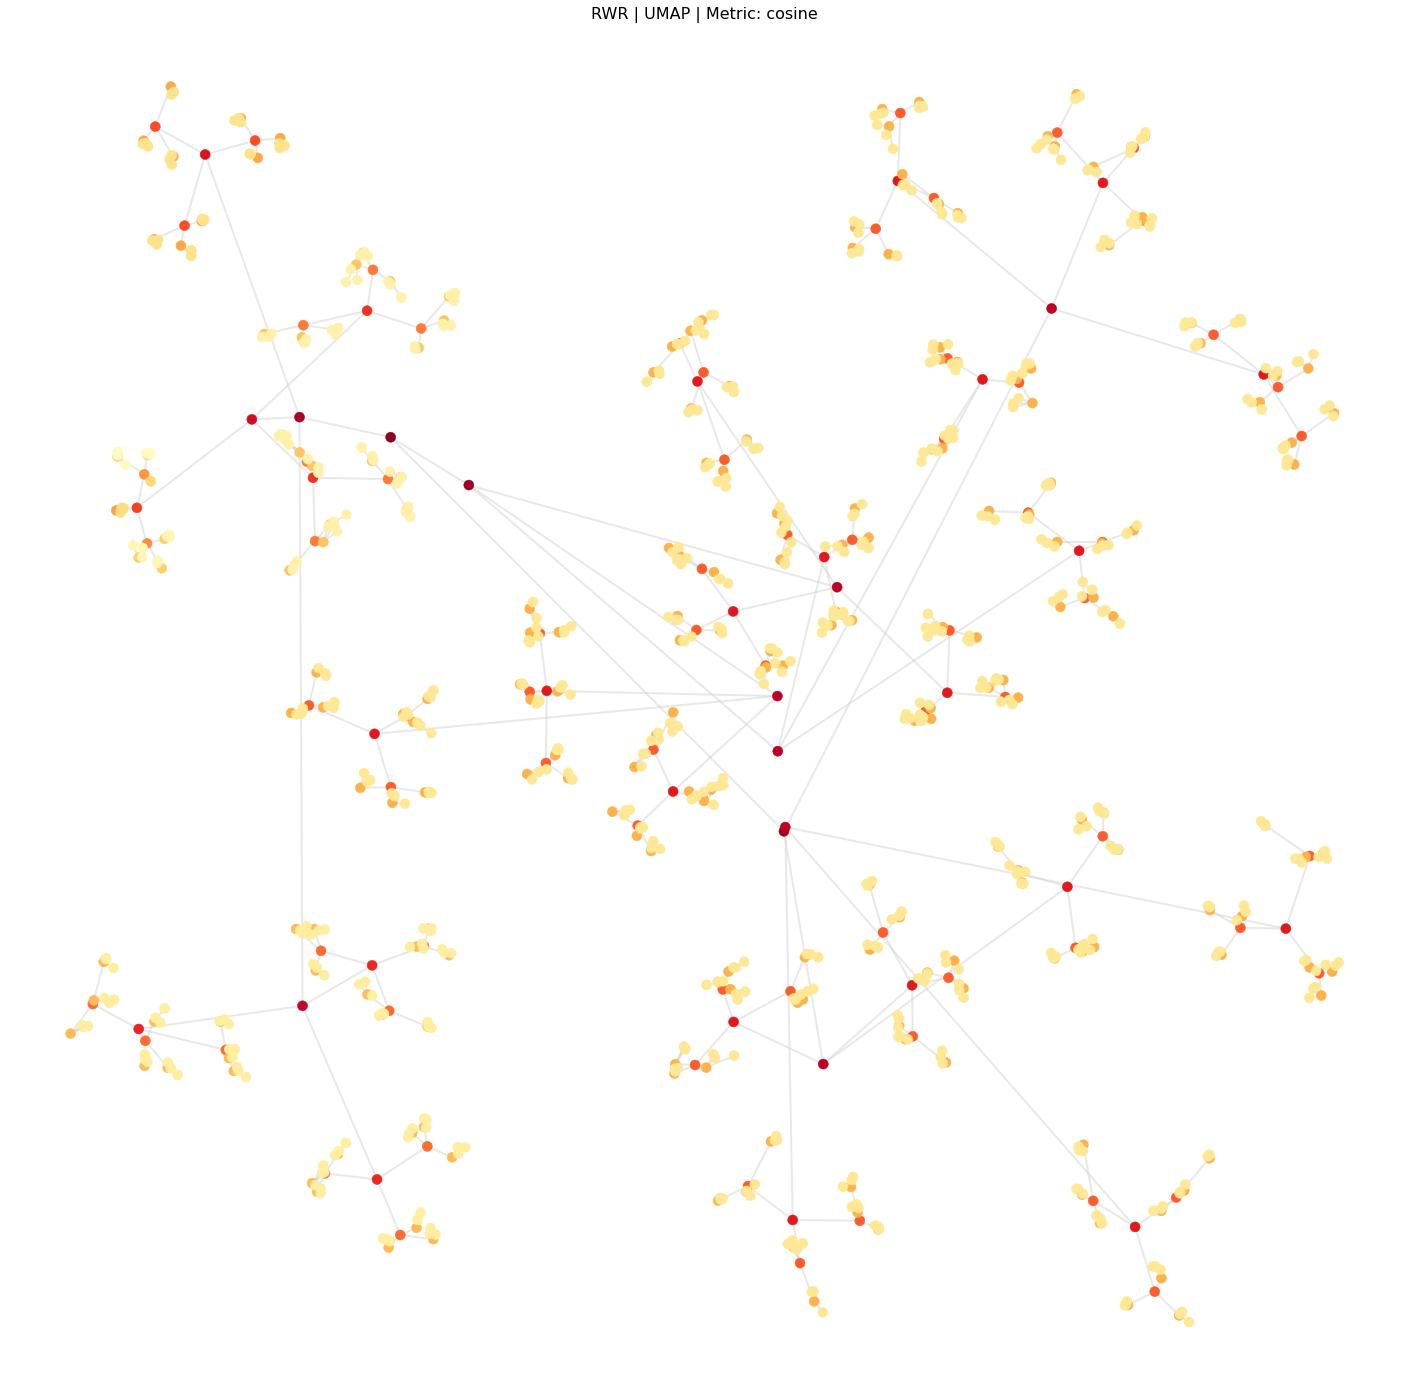

In [270]:
# normalize coordinates 
x_rwr_list = []
y_rwr_list = []
for k,v in posG_complete_umap_rwr.items():
    x_rwr_list.append(v[0])
    y_rwr_list.append(v[1])
    
xx_rwr_norm = sklearn.preprocessing.minmax_scale(x_rwr_list, feature_range=(0, 1), axis=0, copy=True)
yy_rwr_norm = sklearn.preprocessing.minmax_scale(y_rwr_list, feature_range=(0, 1), axis=0, copy=True)

posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()), zip(xx_rwr_norm,yy_rwr_norm)))


plt.figure(figsize=(25,25))
plt.title(
    feature+' | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_complete_umap_rwr_norm, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, 
                       node_size = 100, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_complete_umap_rwr_norm, width = edge_width, edge_color = edge_col, alpha = opacity_edges)
plt.box(False)

plt.savefig('output_plots/2Dtoynetworkumap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.png')

plt.show()

+ FEATURE MATRIX = CENTRALITIES

In [233]:
n_neighbors = 8 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.1 #defines how dense points are stacked together 
metric ='cosine'

In [234]:
%%time 

feature = 'CENT'
DM = DM_cent

umap_cent = embed_umap_2D(DM, n_neighbors, spread, min_dist, metric)

posG_umap_cent = get_posG_2D(G.nodes(), umap_cent)
posG_complete_umap_cent = {key:posG_umap_cent[key] for key in G.nodes()}

CPU times: user 13.3 s, sys: 214 ms, total: 13.5 s
Wall time: 5.16 s


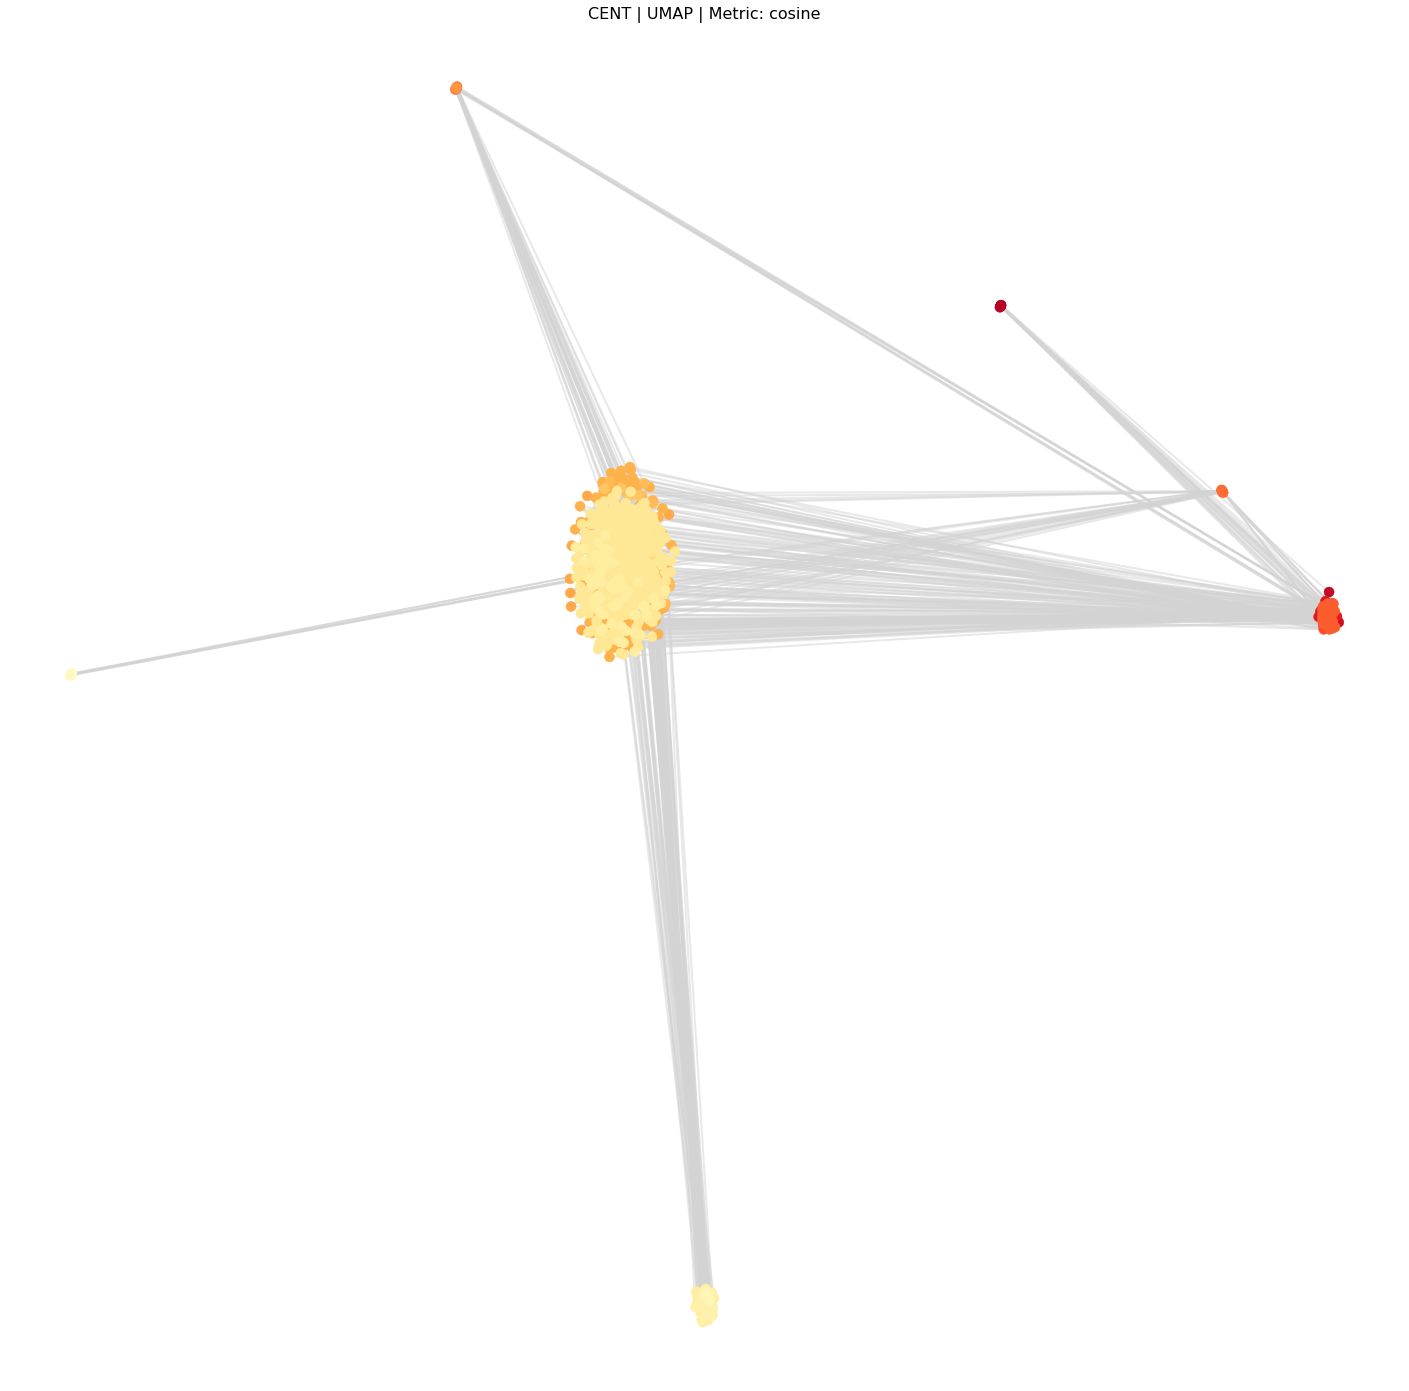

In [235]:
# normalize coordinates 
x_cent_list = []
y_cent_list = []
for k,v in posG_complete_umap_cent.items():
    x_cent_list.append(v[0])
    y_cent_list.append(v[1])
    
xx_cent_norm = sklearn.preprocessing.minmax_scale(x_cent_list, feature_range=(0, 1), axis=0, copy=True)
yy_cent_norm = sklearn.preprocessing.minmax_scale(y_cent_list, feature_range=(0, 1), axis=0, copy=True)

posG_complete_umap_cent_norm = dict(zip(list(G.nodes()), zip(xx_cent_norm,yy_cent_norm)))


plt.figure(figsize=(25,25))
plt.title(
    feature+' | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_complete_umap_cent_norm, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, 
                       node_size = 100, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_complete_umap_cent_norm, width = edge_width, edge_color = edge_col, alpha = opacity_edges)
plt.box(False)

plt.savefig('output_plots/2Dtoynetworkumap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.png')

plt.show()

_________

# EVALUATION PART I - 2D 
### DM-distance vs. Layout Distance 
+ Plots to compare Distance-matrix deriving Distances with embedded Layout Distances 
+ X-axis = Reference axis i.e. Matrix Distance 
+ Y-axis = Layout Distance 

## 2D layouts Correlation diagrams (CALCULATED vs. LAYOUT DISTANCE)

In [271]:
labelsize = 28
legendfontsize = 18

+ ADJACENCIES

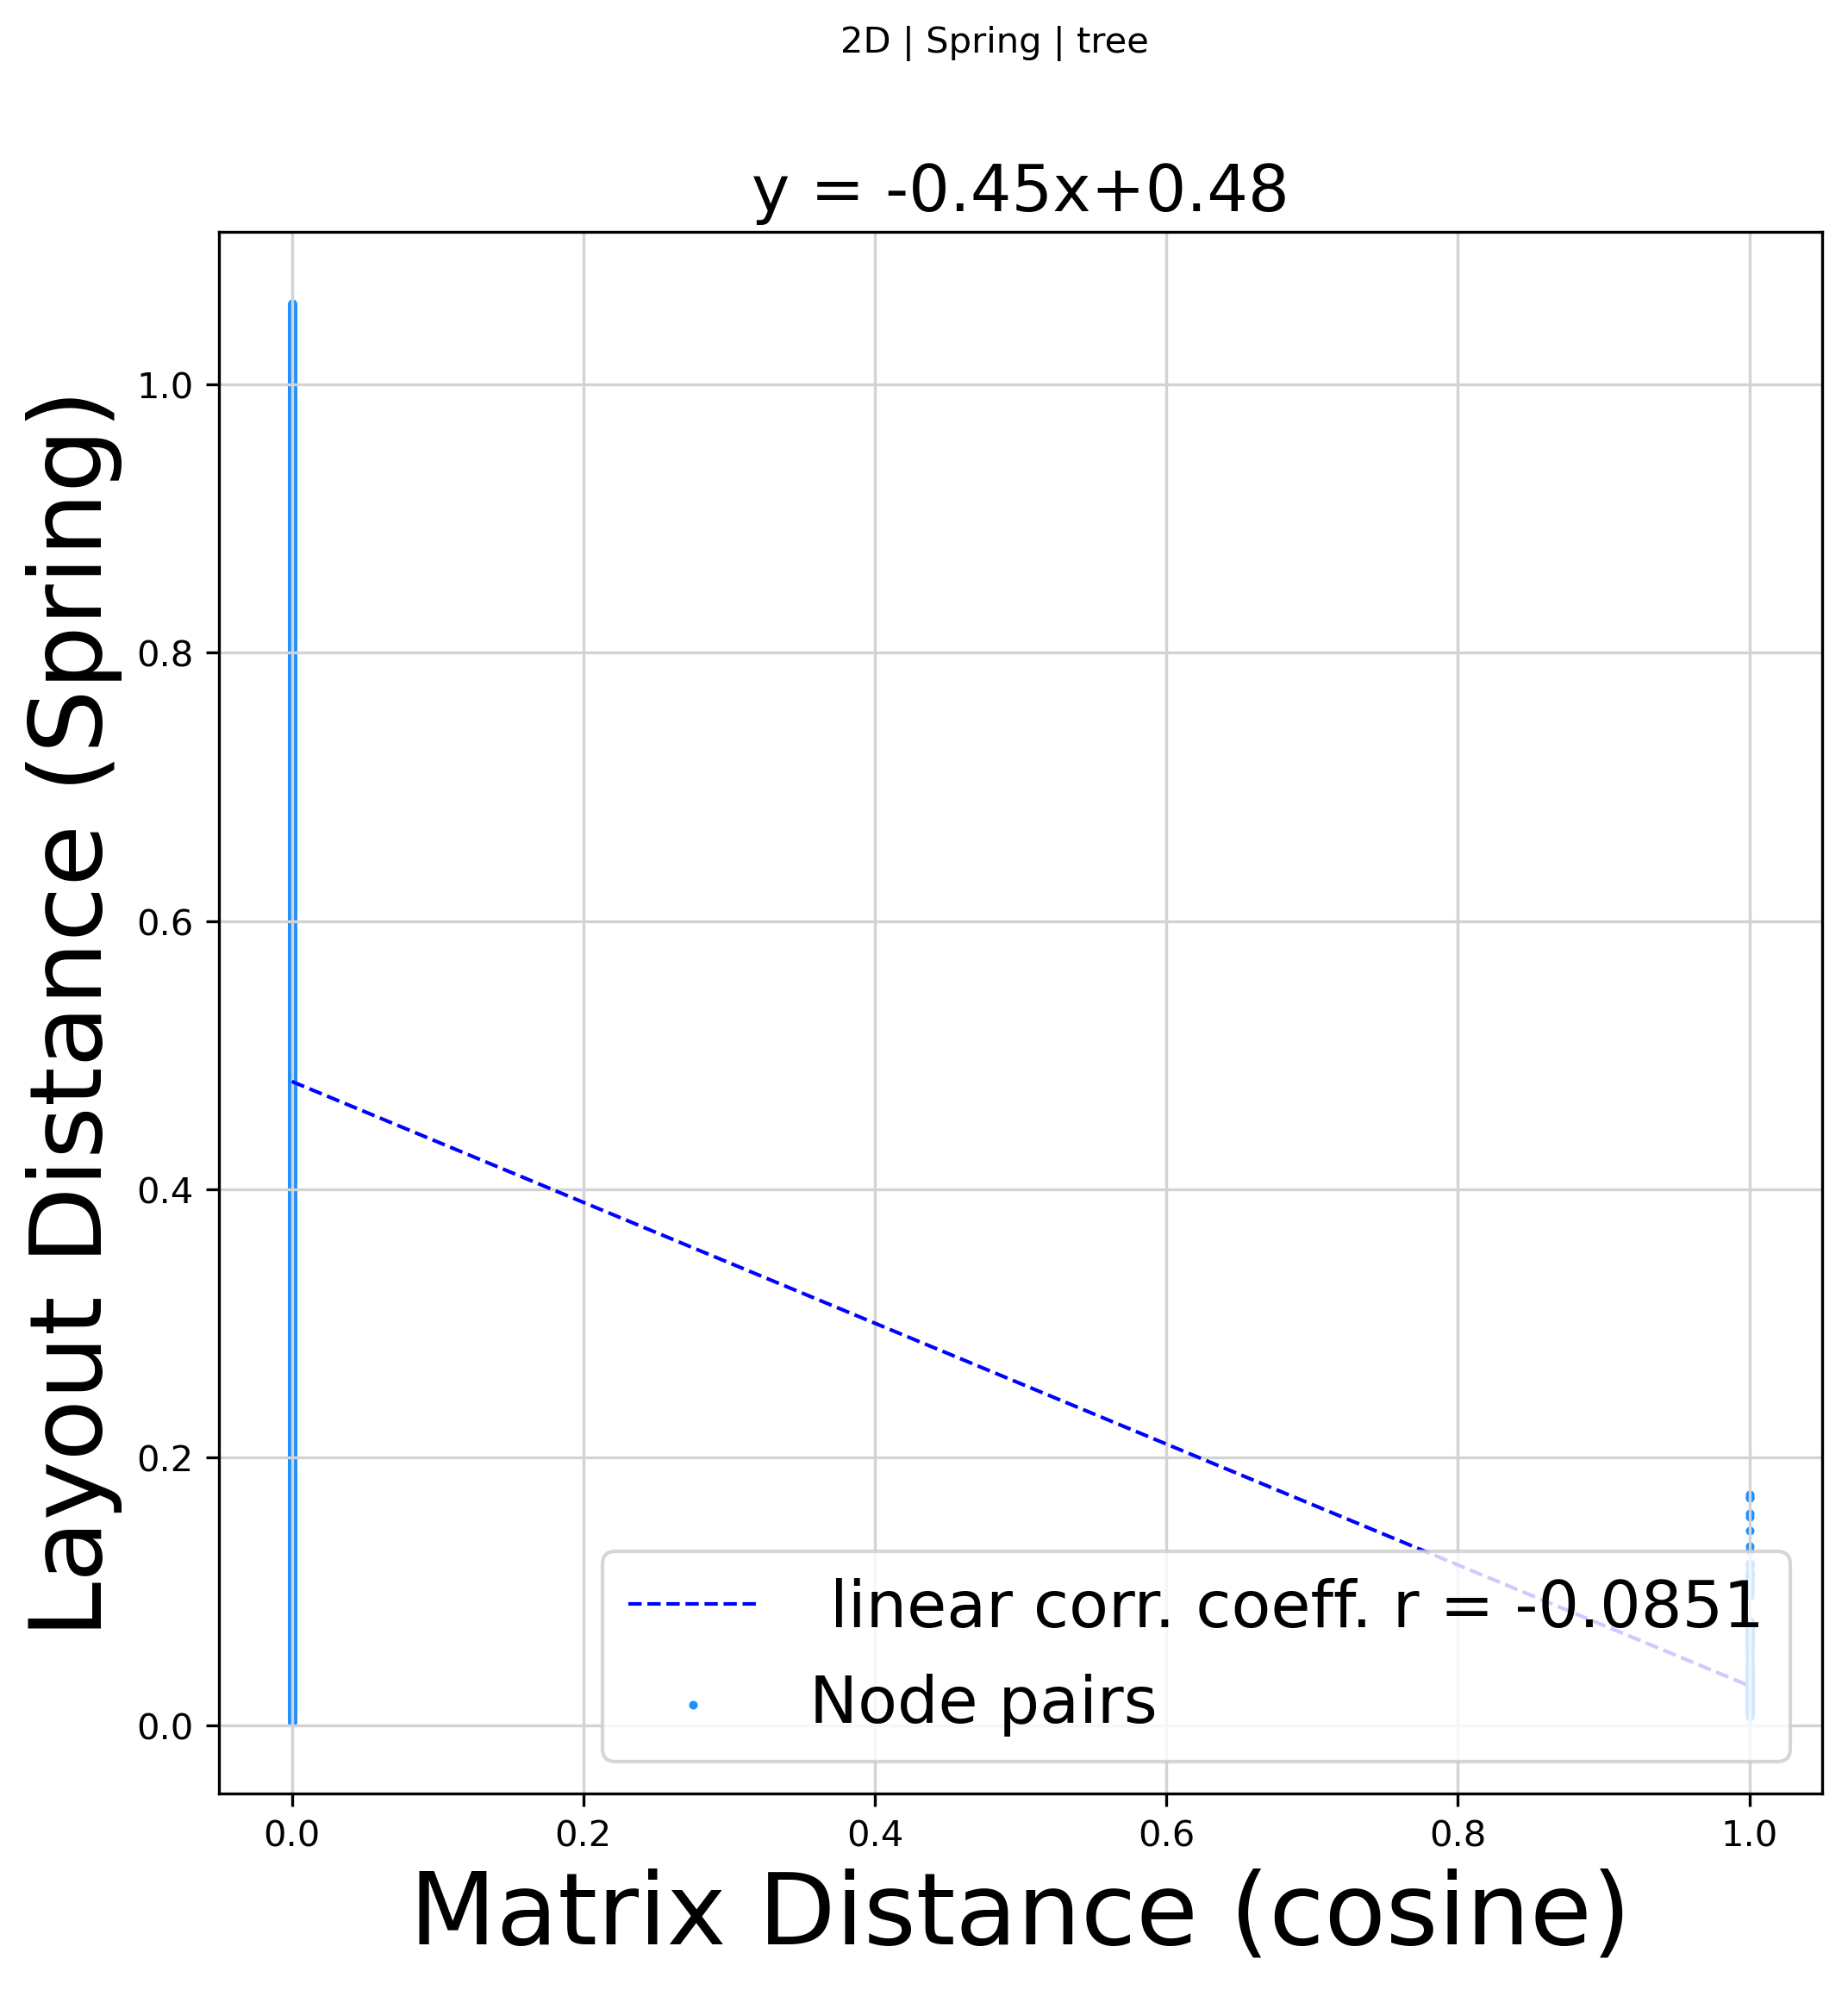

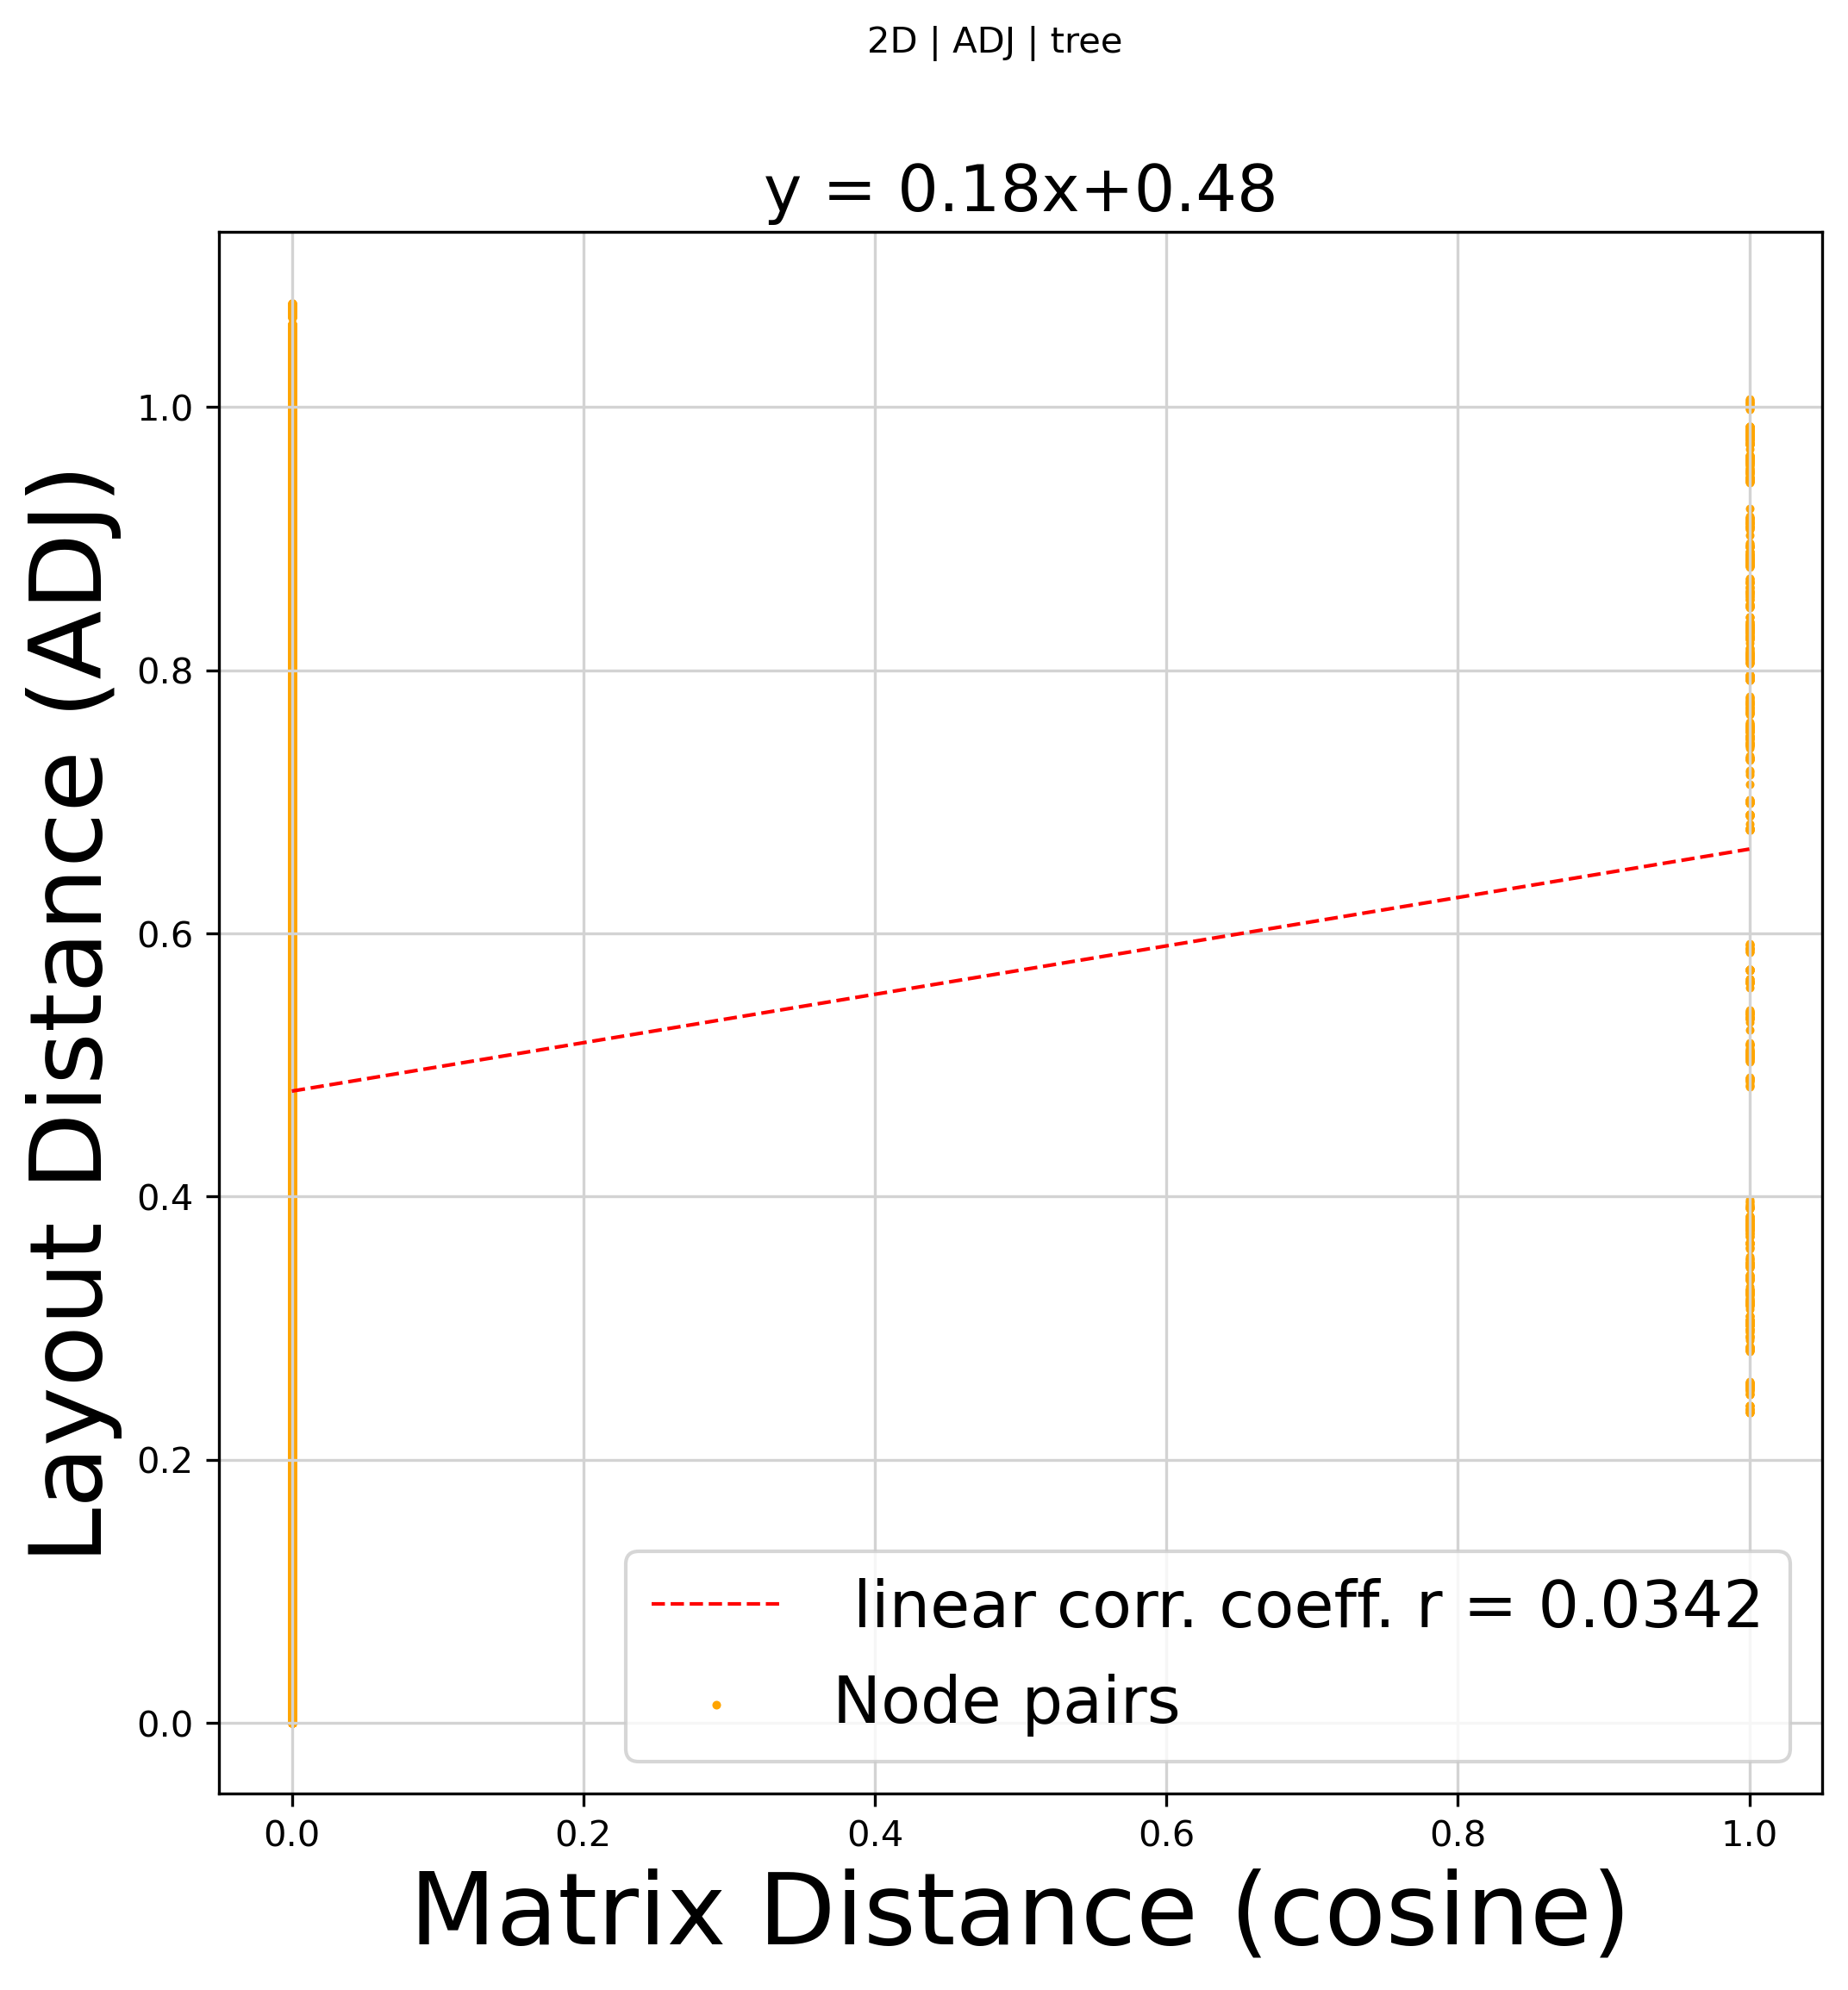

In [272]:
feature = 'ADJ'
DM = df_adj

posG_complete_umap = posG_complete_umap_adj_norm 
posG_spring2D = posG_spring2D_norm

# SPRING
from itertools import combinations
dist_spring2D = dict()
for (id1,p1),(id2,p2) in combinations(posG_spring2D.items(),2):
    dx,dy = p1[0]-p2[0], p1[1]-p2[1]
    dist_spring2D[id1,id2] = math.sqrt(dx*dx+dy*dy)
    
# LAYOUT
from itertools import combinations
dist_layout2D = dict()
for (id1,p1),(id2,p2) in combinations(posG_complete_umap.items(),2):
    dx,dy = p1[0]-p2[0], p1[1]-p2[1]
    dist_layout2D[id1,id2] = math.sqrt(dx*dx+dy*dy)
    
# ------------------------------------------------------------
# get squareform dataframes from distances

# SPRING
dist_spring_list = [dist[1] for dist in sorted(dist_spring2D.items())]
df_spring2D = pd.DataFrame(dist.squareform(dist_spring_list), index=DM.index, columns=DM.columns)

# LAYOUT
dist_layout_list = [dist[1] for dist in sorted(dist_layout2D.items())]
df_layout2D = pd.DataFrame(dist.squareform(dist_layout_list), index=DM.index, columns=DM.columns)


# ------------------------------------------------------------
# remove all diagonal 0 values and values underneath diagonale (i.e. mirrored data)

# INITIAL DM
m,n = DM.shape
DM_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,DM))

# SPRING
m,n = df_spring2D.shape
df_spring2D_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,df_spring2D))

# LAYOUT
m,n = df_layout2D.shape
df_layout2D_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,df_layout2D))


# ------------------------------------------------------------
# values of Dataframe into flattened list for Regression line

# INITIAL DM 
l_DM = []
for i in range(len(DM_mod)):
    l_DM.append(DM.iloc[i:i+1].values)

l_DM_un = list(it.chain(*l_DM))
l_DM_flattened = list(it.chain(*l_DM_un))


# SPRING 
l_spring2D = []
for i in range(len(df_spring2D_mod)):
    l_spring2D.append(df_spring2D.iloc[i:i+1].values)

l_spring2D_un = list(it.chain(*l_spring2D))
l_spring2D_flattened = list(it.chain(*l_spring2D_un))


# LAYOUT
l_layout2D = []
for i in range(len(df_layout2D_mod)):
    l_layout2D.append(df_layout2D.iloc[i:i+1].values)

l_layout2D_un = list(it.chain(*l_layout2D))
l_layout2D_flattened = list(it.chain(*l_layout2D_un))


# ------------------------------------------------------------
# PLOT SPRING
# ------------------------------------------------------------

fig = plt.figure(figsize=(8,8), dpi=300)
plt.grid(True, c='lightgrey')

y_spring = df_spring2D_mod
x_spring = DM_mod
plt.scatter(x_spring,y_spring, c = 'dodgerblue', s = 2)

# REGRESSION LINE 
y_regr_spring = l_spring2D_flattened
x_regr_spring = l_DM_flattened
gradient_spring, intercept_spring, r_value_spring, p_value_spring, std_err_spring = stats.linregress(x_regr_spring,y_regr_spring)
mn_spring=np.min(x_regr_spring)
mx_spring=np.max(x_regr_spring)
x1_spring=np.linspace(mn_spring,mx_spring,500)
line_spring =gradient_spring*x1_spring+intercept_spring
plt.plot(x1_spring,line_spring,'--b',linewidth=1.0)

plt.ylabel("Layout Distance (Spring)", fontsize=labelsize)
plt.xlabel("Matrix Distance "+"("+metric+")", fontsize=labelsize)

plt.legend((' linear corr. coeff. r = {}'.format(round(r_value_spring,4)),'Node pairs'), loc='lower right', fontsize = legendfontsize)

plt.suptitle('2D | Spring | '+organism, fontsize=10)
plt.title('y = {:.2f}x+{:.2f}'.format(gradient_spring,intercept_spring), fontsize=legendfontsize)

fig.savefig('output_plots/2Dtoynetwork_CorrDiagramSPRING_'+feature+'_'+organism+'.png')



# ------------------------------------------------------------
# PLOT LAYOUT
# ------------------------------------------------------------

fig = plt.figure(figsize=(8,8), dpi=300)
plt.grid(True, c='lightgrey')

y_layout = df_layout2D_mod
x_layout = DM_mod
plt.scatter(x_layout,y_layout, c = 'orange', s = 2)

# REGRESSION LINE 
y_regr_layout = l_layout2D_flattened
x_regr_layout = l_DM_flattened
gradient_layout, intercept_layout, r_value_layout, p_value_layout, std_err_layout = stats.linregress(x_regr_layout,y_regr_layout)
mn_layout=np.min(x_regr_layout)
mx_layout=np.max(x_regr_layout)
x1_layout=np.linspace(mn_layout,mx_layout,500)
line_layout = gradient_layout*x1_layout+intercept_layout
plt.plot(x1_layout,line_layout,'--r',linewidth=1.0)

plt.ylabel("Layout Distance "+"("+feature+")", fontsize=labelsize)
plt.xlabel("Matrix Distance "+"("+metric+")", fontsize=labelsize)


plt.legend((' linear corr. coeff. r = {}'.format(round(r_value_layout,4)),'Node pairs'), loc='lower right', fontsize = legendfontsize)

plt.suptitle('2D | '+feature+' | '+organism, fontsize=10)
plt.title('y = {:.2f}x+{:.2f}'.format(gradient_layout,intercept_layout), fontsize=legendfontsize)

fig.savefig('output_plots/2Dtoynetwork_CorrDiagramLAYOUT_'+feature+'_'+organism+'.png')

+ RANDOM WALK

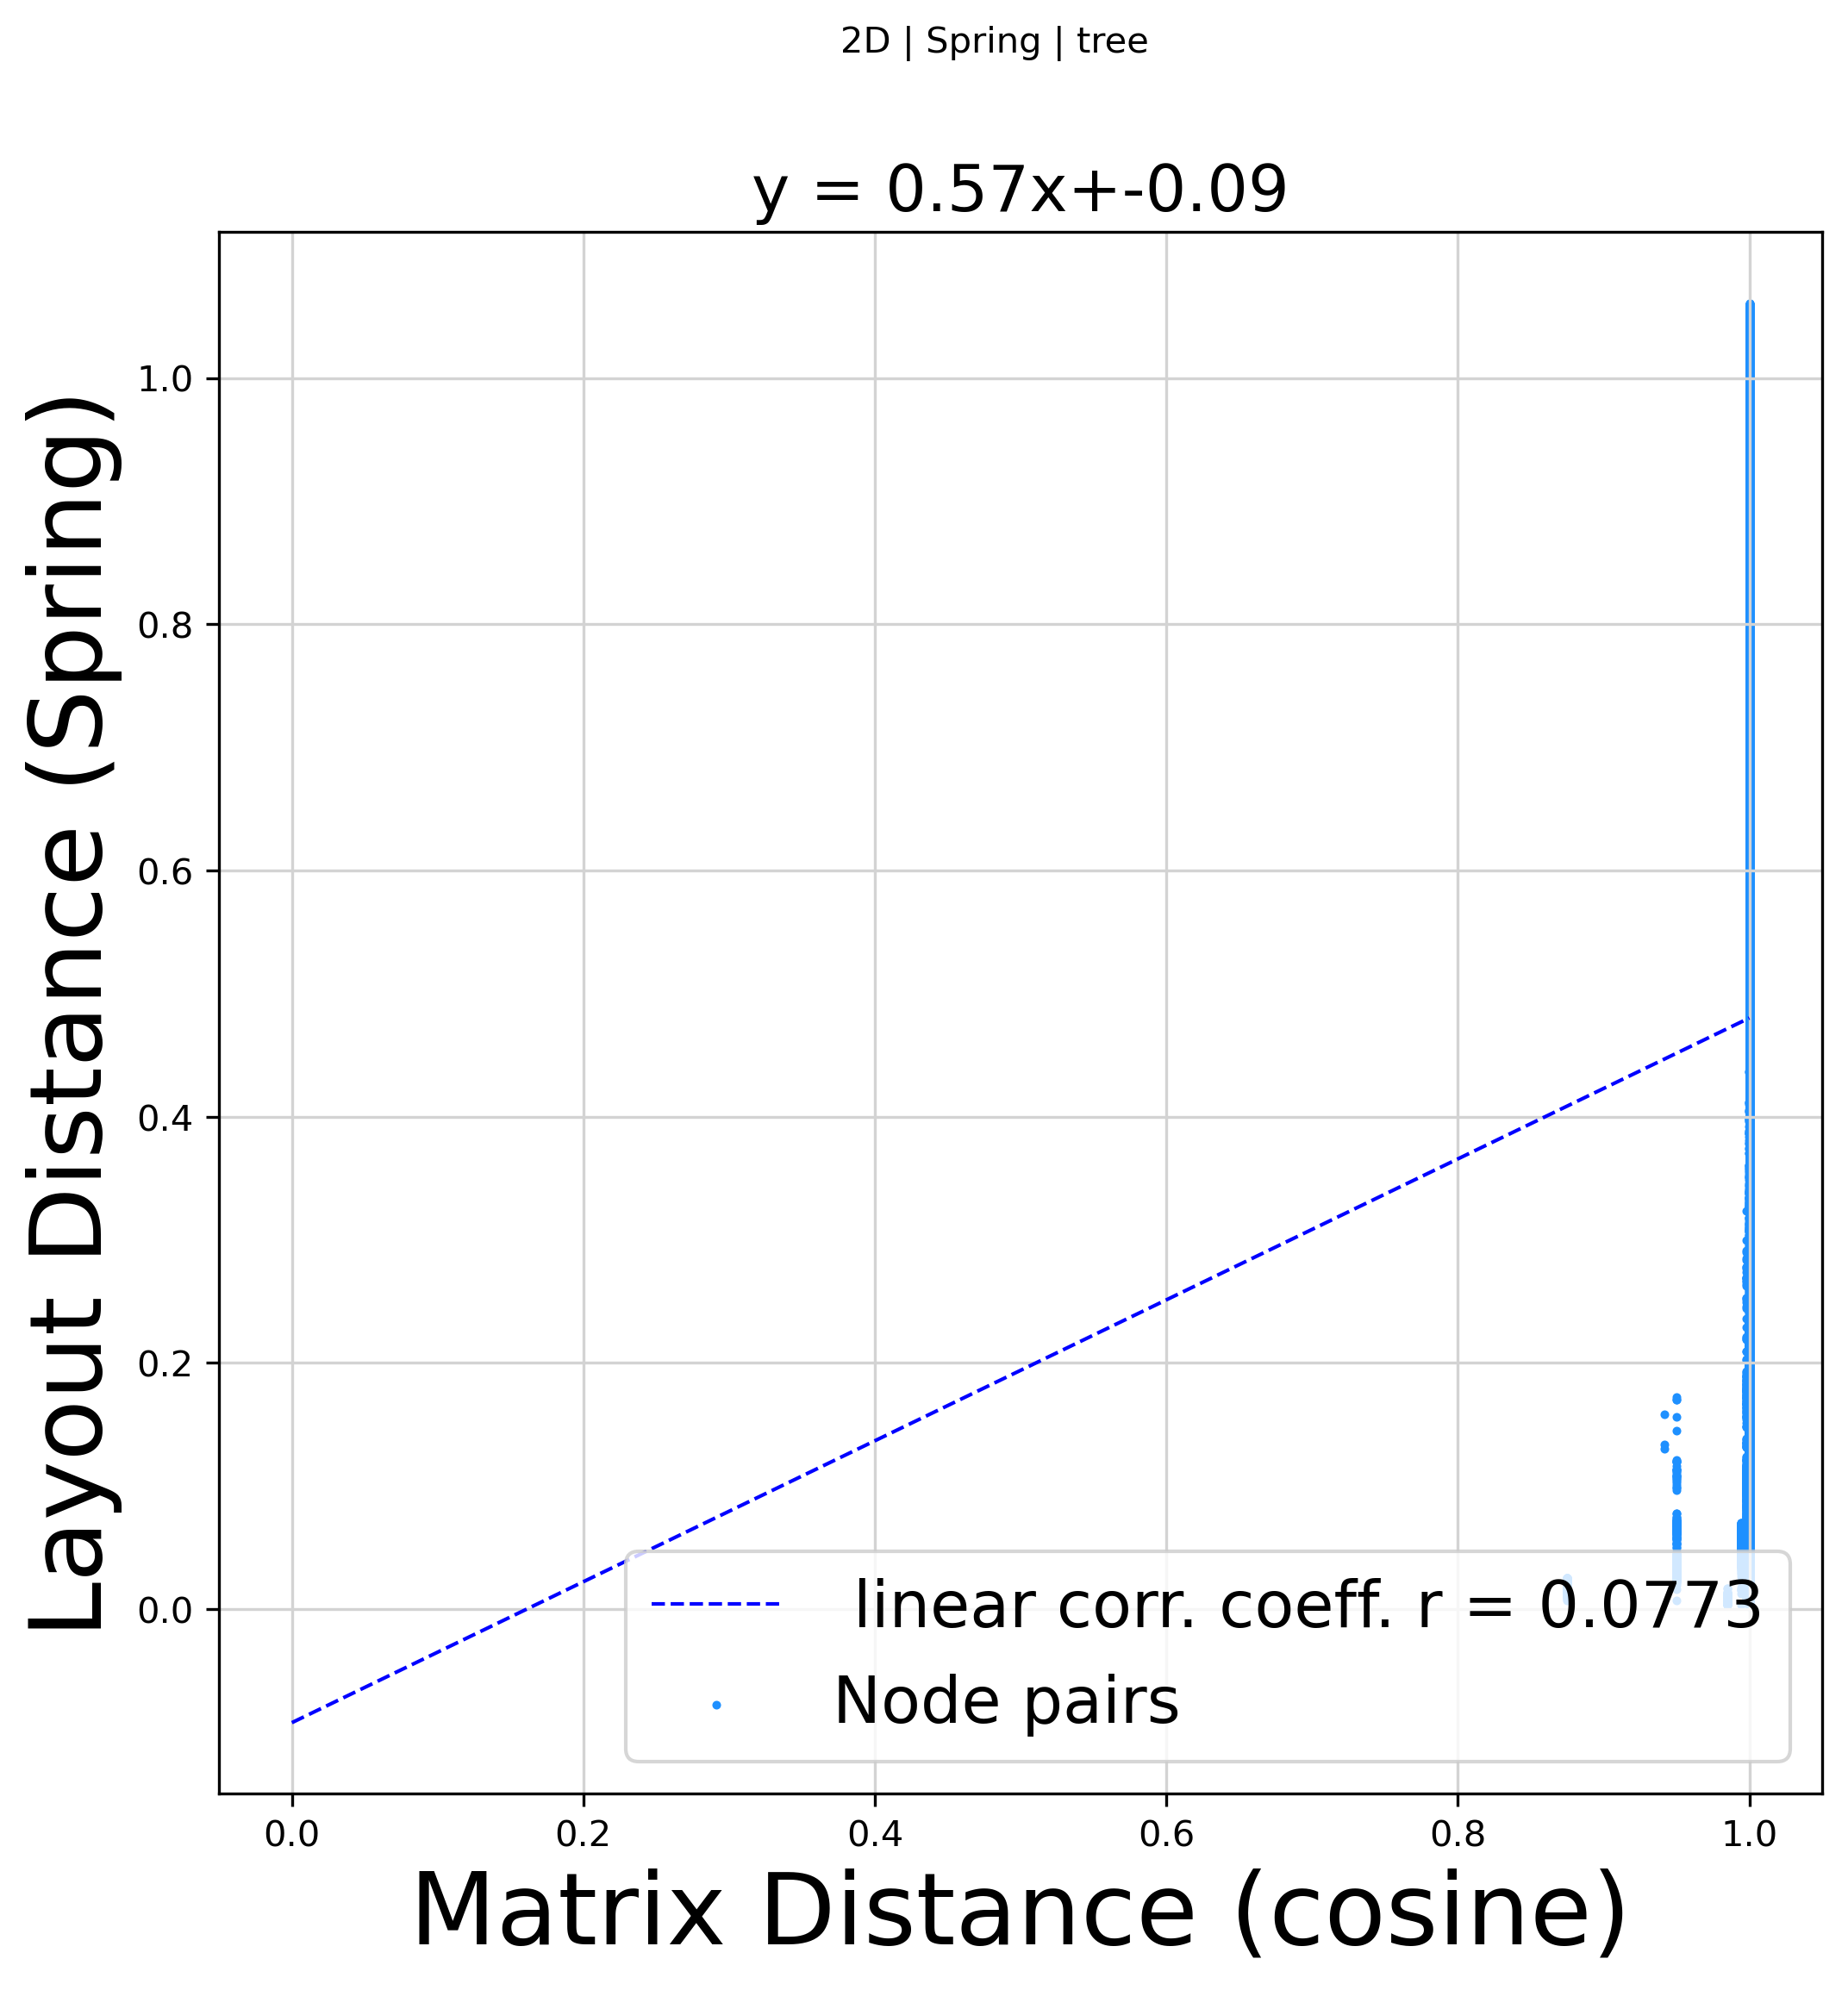

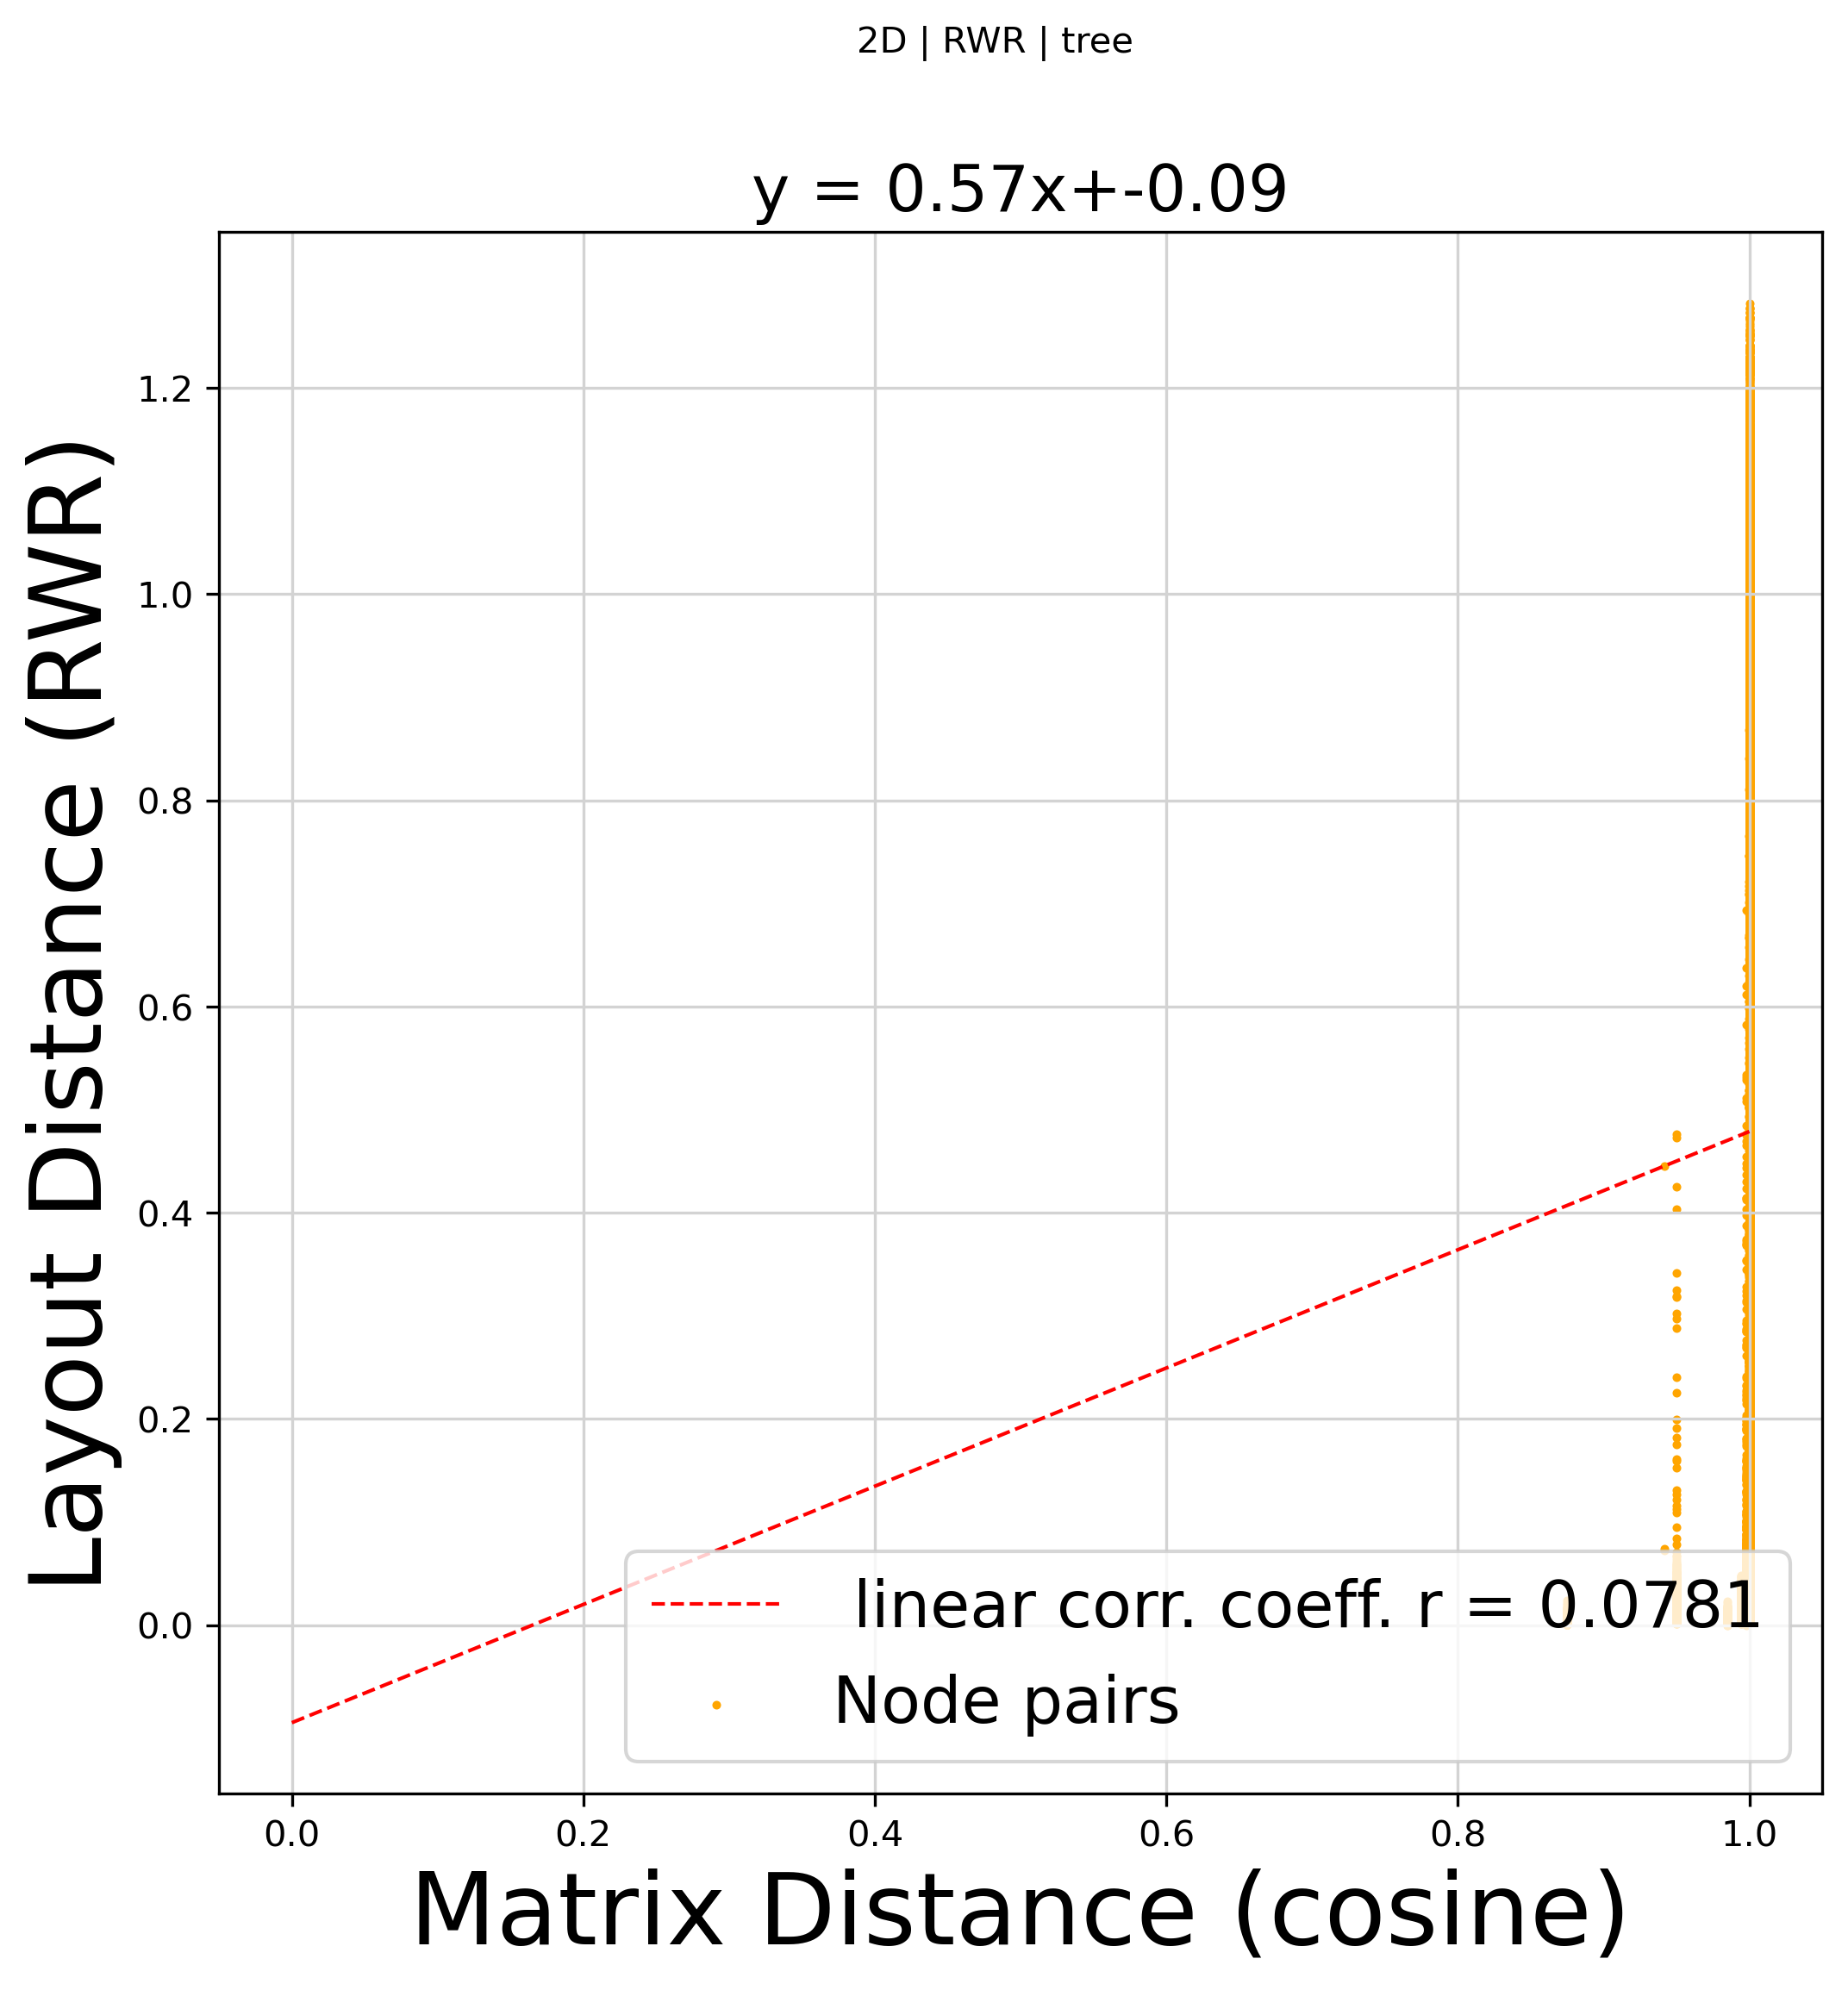

In [273]:
DM = DM_m
feature = 'RWR'

posG_complete_umap = posG_complete_umap_rwr_norm 
posG_spring2D = posG_spring2D_norm

# SPRING
from itertools import combinations
dist_spring2D = dict()
for (id1,p1),(id2,p2) in combinations(posG_spring2D.items(),2):
    dx,dy = p1[0]-p2[0], p1[1]-p2[1]
    dist_spring2D[id1,id2] = math.sqrt(dx*dx+dy*dy)
    
# LAYOUT
from itertools import combinations
dist_layout2D = dict()
for (id1,p1),(id2,p2) in combinations(posG_complete_umap.items(),2):
    dx,dy = p1[0]-p2[0], p1[1]-p2[1]
    dist_layout2D[id1,id2] = math.sqrt(dx*dx+dy*dy)
    
# ------------------------------------------------------------
# get squareform dataframes from distances

# SPRING
dist_spring_list = [dist[1] for dist in sorted(dist_spring2D.items())]
df_spring2D = pd.DataFrame(dist.squareform(dist_spring_list), index=DM.index, columns=DM.columns)

# LAYOUT
dist_layout_list = [dist[1] for dist in sorted(dist_layout2D.items())]
df_layout2D = pd.DataFrame(dist.squareform(dist_layout_list), index=DM.index, columns=DM.columns)


# ------------------------------------------------------------
# remove all diagonal 0 values and values underneath diagonale (i.e. mirrored data)

# INITIAL DM
m,n = DM.shape
DM_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,DM))

# SPRING
m,n = df_spring2D.shape
df_spring2D_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,df_spring2D))

# LAYOUT
m,n = df_layout2D.shape
df_layout2D_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,df_layout2D))


# ------------------------------------------------------------
# values of Dataframe into flattened list for Regression line

# INITIAL DM 
l_DM = []
for i in range(len(DM_mod)):
    l_DM.append(DM.iloc[i:i+1].values)

l_DM_un = list(it.chain(*l_DM))
l_DM_flattened = list(it.chain(*l_DM_un))


# SPRING 
l_spring2D = []
for i in range(len(df_spring2D_mod)):
    l_spring2D.append(df_spring2D.iloc[i:i+1].values)

l_spring2D_un = list(it.chain(*l_spring2D))
l_spring2D_flattened = list(it.chain(*l_spring2D_un))


# LAYOUT
l_layout2D = []
for i in range(len(df_layout2D_mod)):
    l_layout2D.append(df_layout2D.iloc[i:i+1].values)

l_layout2D_un = list(it.chain(*l_layout2D))
l_layout2D_flattened = list(it.chain(*l_layout2D_un))


# ------------------------------------------------------------
# PLOT SPRING
# ------------------------------------------------------------

fig = plt.figure(figsize=(8,8), dpi=300)
plt.grid(True, c='lightgrey')

y_spring = df_spring2D_mod
x_spring = DM_mod
plt.scatter(x_spring,y_spring, c = 'dodgerblue', s = 2)

# REGRESSION LINE 
y_regr_spring = l_spring2D_flattened
x_regr_spring = l_DM_flattened
gradient_spring, intercept_spring, r_value_spring, p_value_spring, std_err_spring = stats.linregress(x_regr_spring,y_regr_spring)
mn_spring=np.min(x_regr_spring)
mx_spring=np.max(x_regr_spring)
x1_spring=np.linspace(mn_spring,mx_spring,500)
line_spring =gradient_spring*x1_spring+intercept_spring
plt.plot(x1_spring,line_spring,'--b',linewidth=1.0)

plt.ylabel("Layout Distance (Spring)", fontsize=labelsize)
plt.xlabel("Matrix Distance "+"("+metric+")", fontsize=labelsize)

plt.legend((' linear corr. coeff. r = {}'.format(round(r_value_spring,4)),'Node pairs'), loc='lower right', fontsize = legendfontsize)

plt.suptitle('2D | Spring | '+organism, fontsize=10)
plt.title('y = {:.2f}x+{:.2f}'.format(gradient_spring,intercept_spring), fontsize=legendfontsize)

fig.savefig('output_plots/2Dtoynetwork_CorrDiagramSPRING_'+feature+'_'+organism+'.png')



# ------------------------------------------------------------
# PLOT LAYOUT
# ------------------------------------------------------------

fig = plt.figure(figsize=(8,8), dpi=300)
plt.grid(True, c='lightgrey')

y_layout = df_layout2D_mod
x_layout = DM_mod
plt.scatter(x_layout,y_layout, c = 'orange', s = 2)

# REGRESSION LINE 
y_regr_layout = l_layout2D_flattened
x_regr_layout = l_DM_flattened
gradient_layout, intercept_layout, r_value_layout, p_value_layout, std_err_layout = stats.linregress(x_regr_layout,y_regr_layout)
mn_layout=np.min(x_regr_layout)
mx_layout=np.max(x_regr_layout)
x1_layout=np.linspace(mn_layout,mx_layout,500)
line_layout = gradient_layout*x1_layout+intercept_layout
plt.plot(x1_layout,line_layout,'--r',linewidth=1.0)

plt.ylabel("Layout Distance "+"("+feature+")", fontsize=labelsize)
plt.xlabel("Matrix Distance "+"("+metric+")", fontsize=labelsize)


plt.legend((' linear corr. coeff. r = {}'.format(round(r_value_layout,4)),'Node pairs'), loc='lower right', fontsize = legendfontsize)

plt.suptitle('2D | '+feature+' | '+organism, fontsize=10)
plt.title('y = {:.2f}x+{:.2f}'.format(gradient_layout,intercept_layout), fontsize=legendfontsize)

fig.savefig('output_plots/2Dtoynetwork_CorrDiagramLAYOUT_'+feature+'_'+organism+'.png')

+ CENTRALITIES

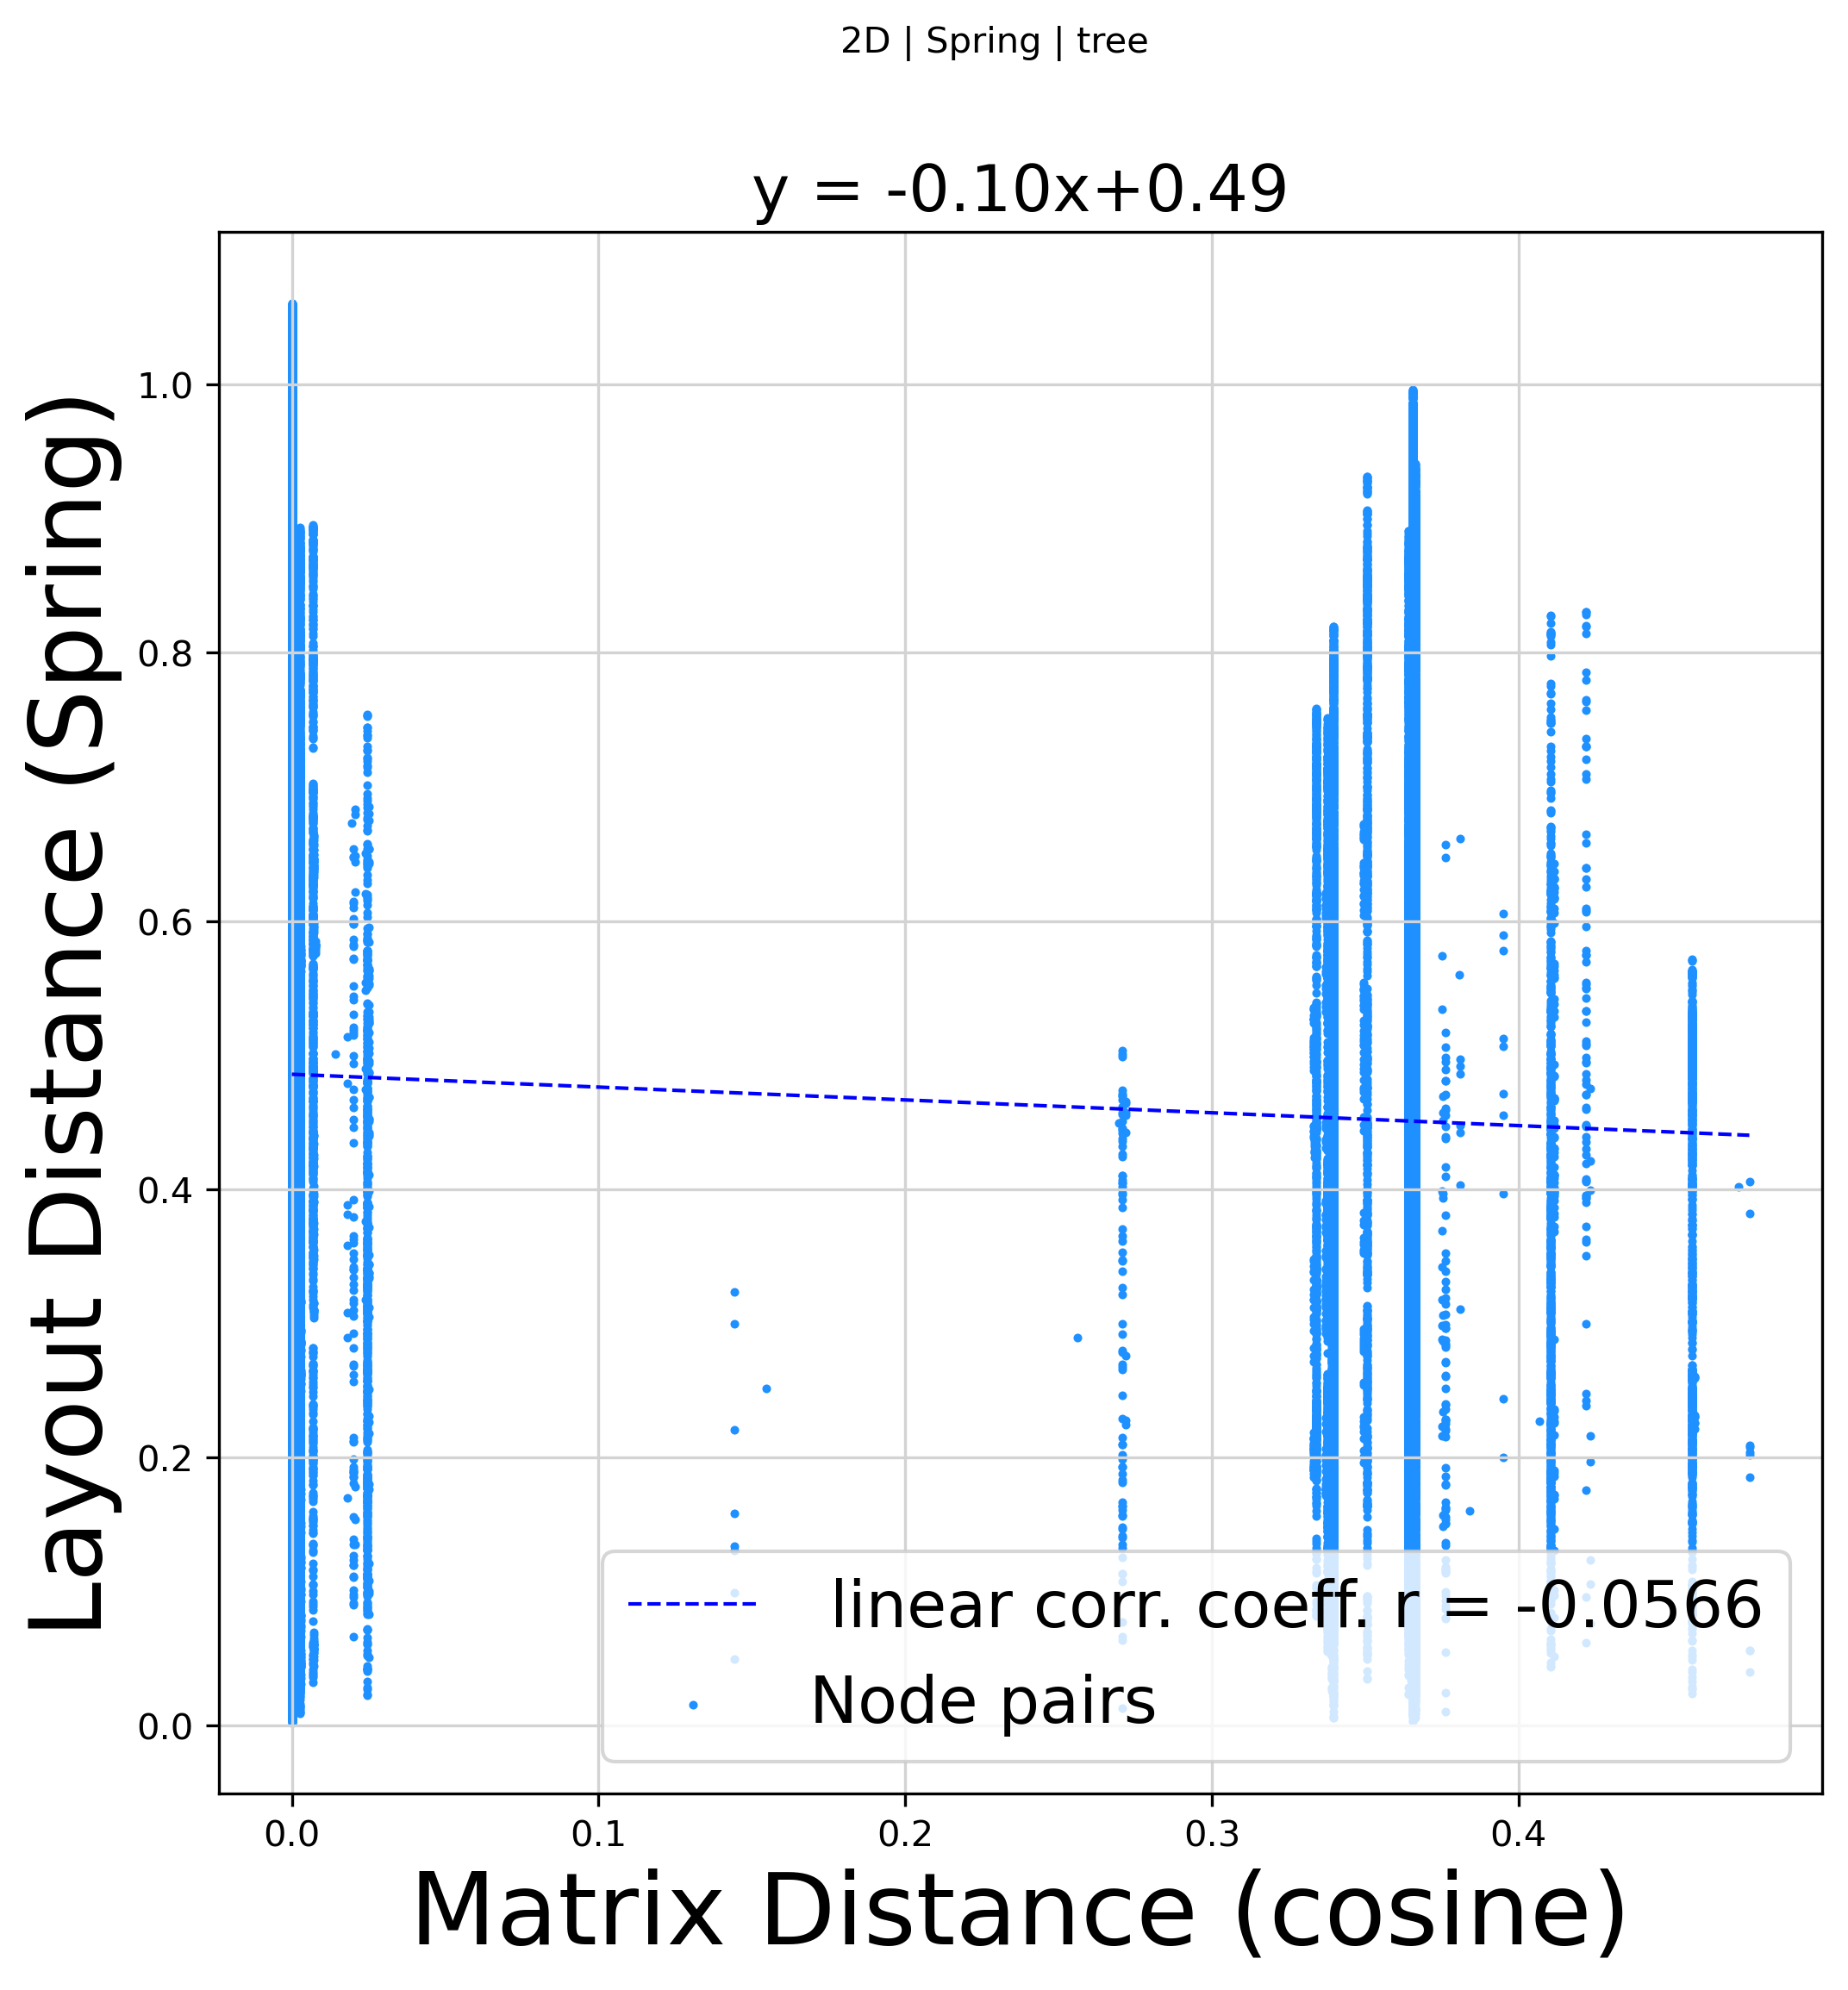

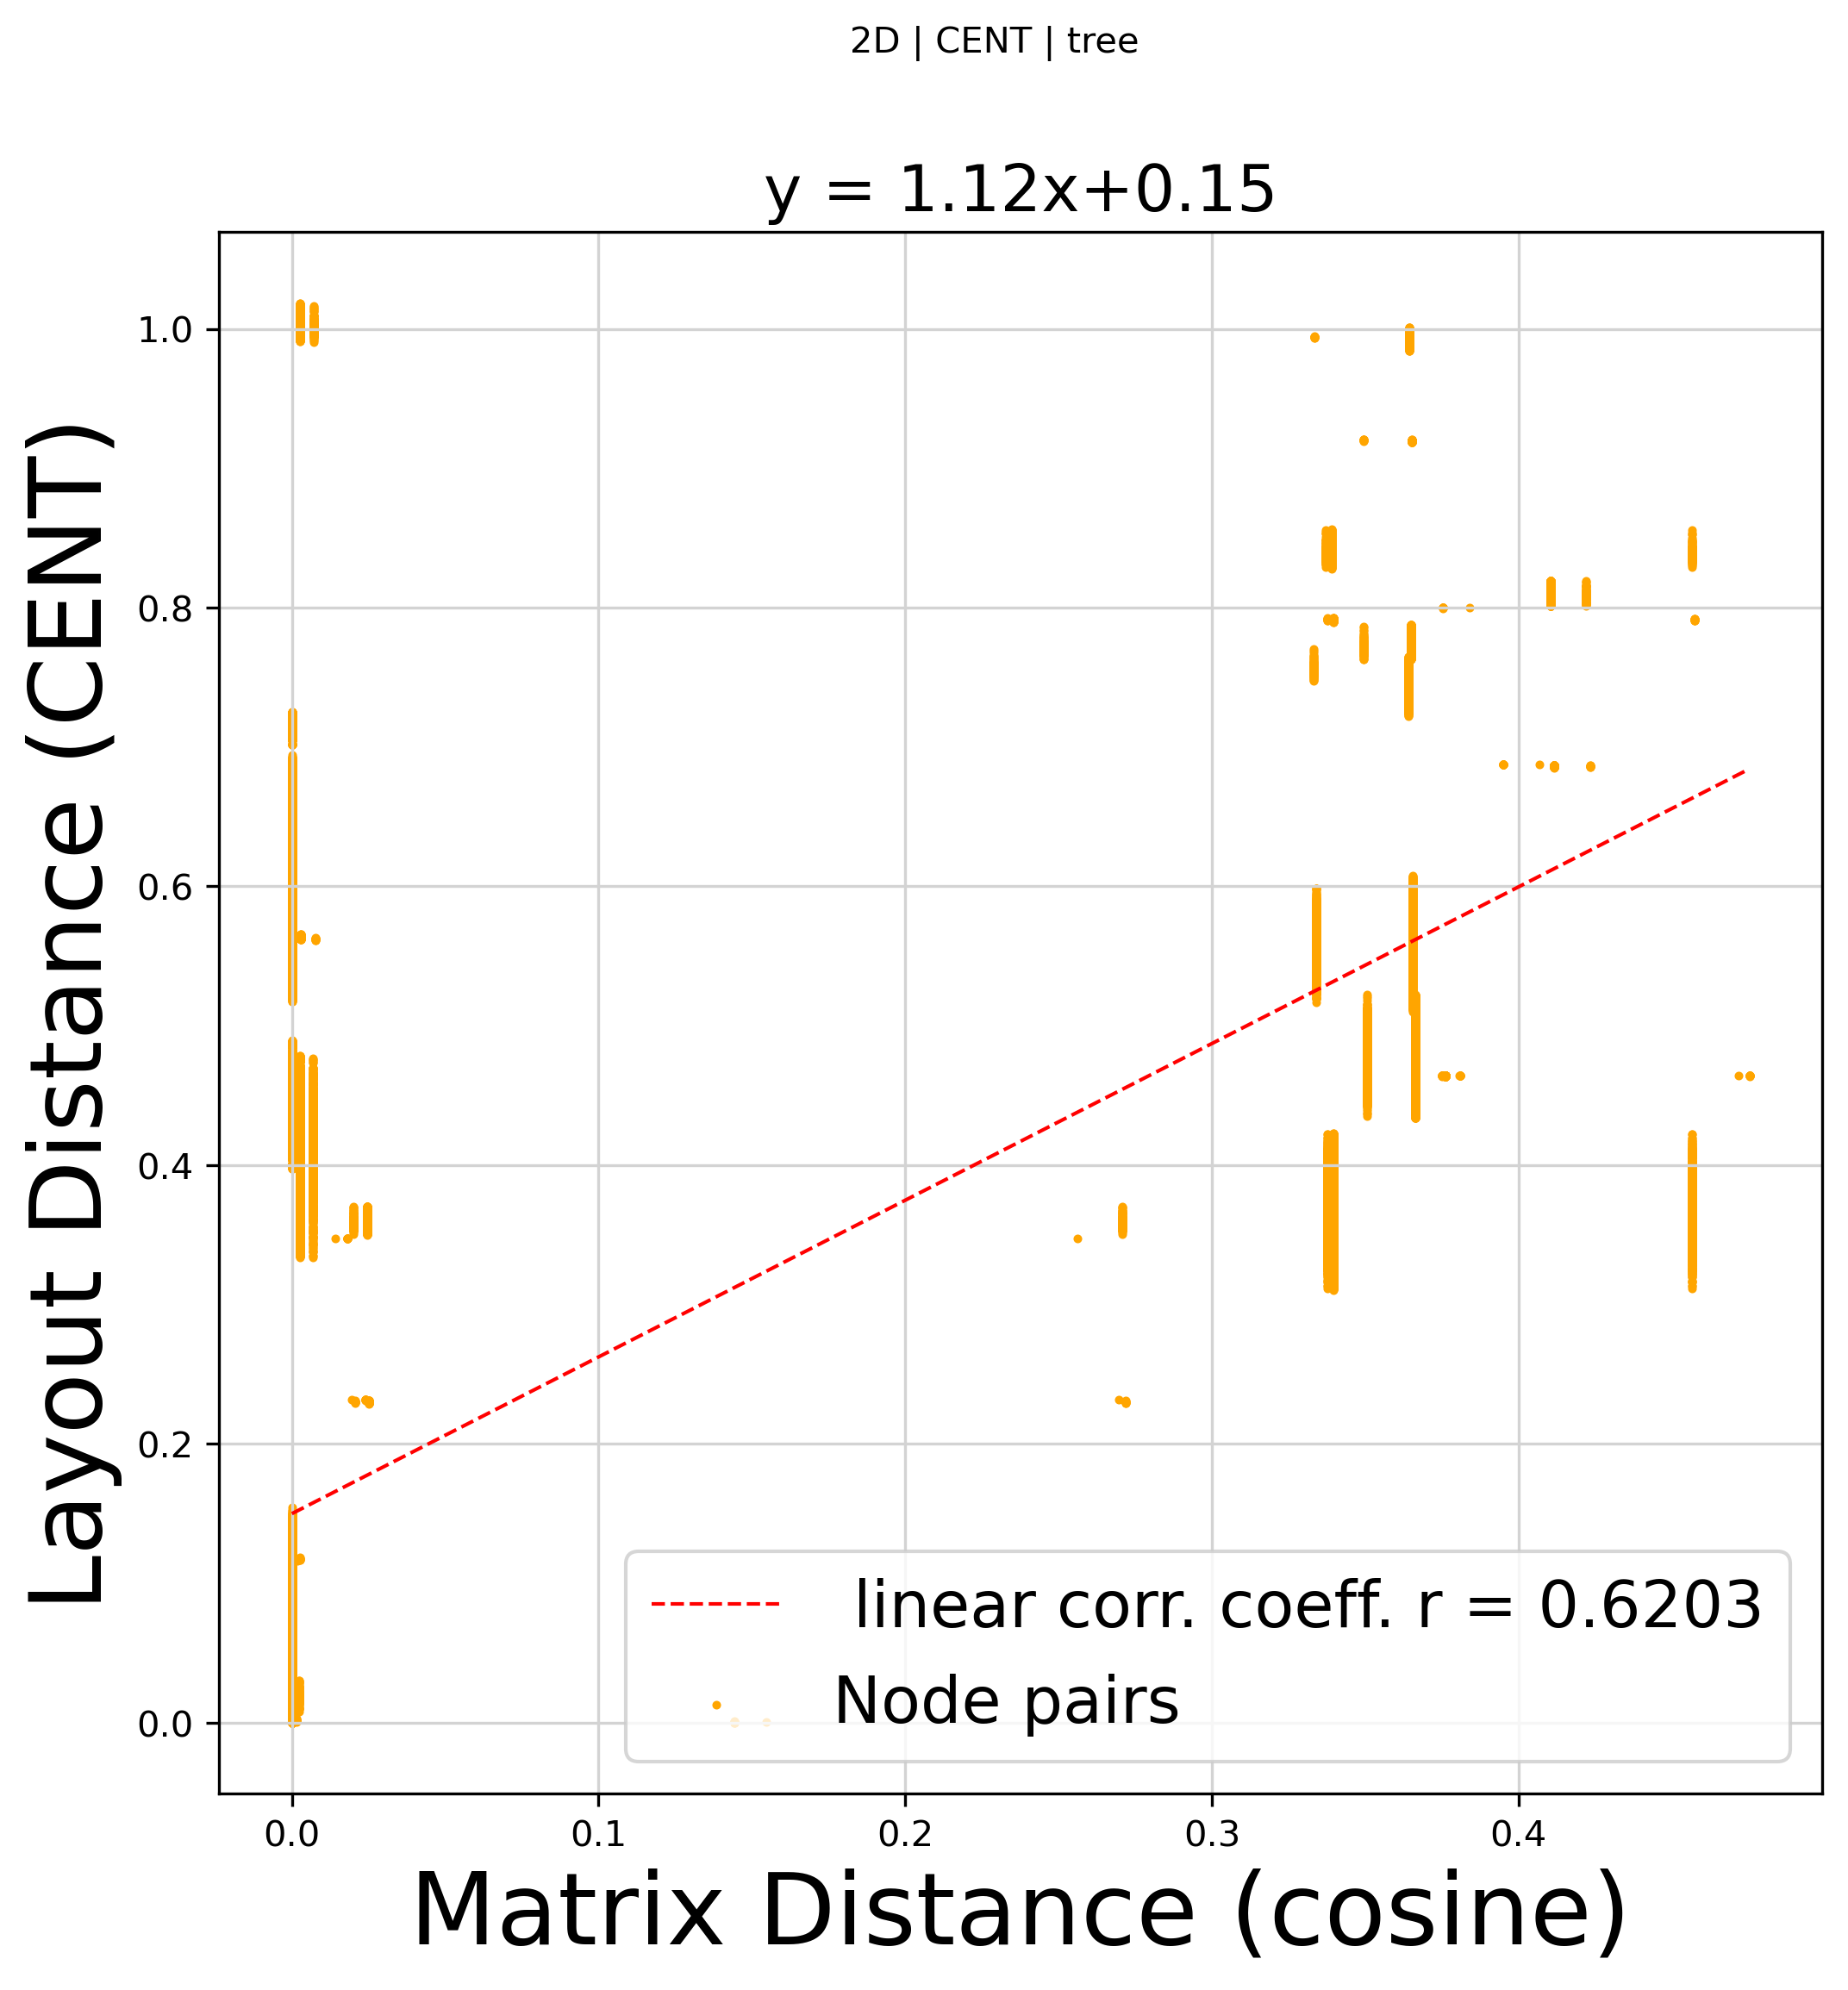

In [274]:
DM = DM_cent
feature = 'CENT'

posG_complete_umap = posG_complete_umap_cent_norm 
posG_spring2D = posG_spring2D_norm

# SPRING
from itertools import combinations
dist_spring2D = dict()
for (id1,p1),(id2,p2) in combinations(posG_spring2D.items(),2):
    dx,dy = p1[0]-p2[0], p1[1]-p2[1]
    dist_spring2D[id1,id2] = math.sqrt(dx*dx+dy*dy)
    
# LAYOUT
from itertools import combinations
dist_layout2D = dict()
for (id1,p1),(id2,p2) in combinations(posG_complete_umap.items(),2):
    dx,dy = p1[0]-p2[0], p1[1]-p2[1]
    dist_layout2D[id1,id2] = math.sqrt(dx*dx+dy*dy)
    
# ------------------------------------------------------------
# get squareform dataframes from distances

# SPRING
dist_spring_list = [dist[1] for dist in sorted(dist_spring2D.items())]
df_spring2D = pd.DataFrame(dist.squareform(dist_spring_list), index=DM.index, columns=DM.columns)

# LAYOUT
dist_layout_list = [dist[1] for dist in sorted(dist_layout2D.items())]
df_layout2D = pd.DataFrame(dist.squareform(dist_layout_list), index=DM.index, columns=DM.columns)


# ------------------------------------------------------------
# remove all diagonal 0 values and values underneath diagonale (i.e. mirrored data)

# INITIAL DM
m,n = DM.shape
DM_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,DM))

# SPRING
m,n = df_spring2D.shape
df_spring2D_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,df_spring2D))

# LAYOUT
m,n = df_layout2D.shape
df_layout2D_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,df_layout2D))


# ------------------------------------------------------------
# values of Dataframe into flattened list for Regression line

# INITIAL DM 
l_DM = []
for i in range(len(DM_mod)):
    l_DM.append(DM.iloc[i:i+1].values)

l_DM_un = list(it.chain(*l_DM))
l_DM_flattened = list(it.chain(*l_DM_un))


# SPRING 
l_spring2D = []
for i in range(len(df_spring2D_mod)):
    l_spring2D.append(df_spring2D.iloc[i:i+1].values)

l_spring2D_un = list(it.chain(*l_spring2D))
l_spring2D_flattened = list(it.chain(*l_spring2D_un))


# LAYOUT
l_layout2D = []
for i in range(len(df_layout2D_mod)):
    l_layout2D.append(df_layout2D.iloc[i:i+1].values)

l_layout2D_un = list(it.chain(*l_layout2D))
l_layout2D_flattened = list(it.chain(*l_layout2D_un))


# ------------------------------------------------------------
# PLOT SPRING
# ------------------------------------------------------------

fig = plt.figure(figsize=(8,8), dpi=300)
plt.grid(True, c='lightgrey')

y_spring = df_spring2D_mod
x_spring = DM_mod
plt.scatter(x_spring,y_spring, c = 'dodgerblue', s = 2)

# REGRESSION LINE 
y_regr_spring = l_spring2D_flattened
x_regr_spring = l_DM_flattened
gradient_spring, intercept_spring, r_value_spring, p_value_spring, std_err_spring = stats.linregress(x_regr_spring,y_regr_spring)
mn_spring=np.min(x_regr_spring)
mx_spring=np.max(x_regr_spring)
x1_spring=np.linspace(mn_spring,mx_spring,500)
line_spring =gradient_spring*x1_spring+intercept_spring
plt.plot(x1_spring,line_spring,'--b',linewidth=1.0)

plt.ylabel("Layout Distance (Spring)", fontsize=labelsize)
plt.xlabel("Matrix Distance "+"("+metric+")", fontsize=labelsize)

plt.legend((' linear corr. coeff. r = {}'.format(round(r_value_spring,4)),'Node pairs'), loc='lower right', fontsize = legendfontsize)

plt.suptitle('2D | Spring | '+organism, fontsize=10)
plt.title('y = {:.2f}x+{:.2f}'.format(gradient_spring,intercept_spring), fontsize=legendfontsize)

fig.savefig('output_plots/2Dtoynetwork_CorrDiagramSPRING_'+feature+'_'+organism+'.png')



# ------------------------------------------------------------
# PLOT LAYOUT
# ------------------------------------------------------------

fig = plt.figure(figsize=(8,8), dpi=300)
plt.grid(True, c='lightgrey')

y_layout = df_layout2D_mod
x_layout = DM_mod
plt.scatter(x_layout,y_layout, c = 'orange', s = 2)

# REGRESSION LINE 
y_regr_layout = l_layout2D_flattened
x_regr_layout = l_DM_flattened
gradient_layout, intercept_layout, r_value_layout, p_value_layout, std_err_layout = stats.linregress(x_regr_layout,y_regr_layout)
mn_layout=np.min(x_regr_layout)
mx_layout=np.max(x_regr_layout)
x1_layout=np.linspace(mn_layout,mx_layout,500)
line_layout = gradient_layout*x1_layout+intercept_layout
plt.plot(x1_layout,line_layout,'--r',linewidth=1.0)

plt.ylabel("Layout Distance "+"("+feature+")", fontsize=labelsize)
plt.xlabel("Matrix Distance "+"("+metric+")", fontsize=labelsize)


plt.legend((' linear corr. coeff. r = {}'.format(round(r_value_layout,4)),'Node pairs'), loc='lower right', fontsize = legendfontsize)

plt.suptitle('2D | '+feature+' | '+organism, fontsize=10)
plt.title('y = {:.2f}x+{:.2f}'.format(gradient_layout,intercept_layout), fontsize=legendfontsize)

fig.savefig('output_plots/2Dtoynetwork_CorrDiagramLAYOUT_'+feature+'_'+organism+'.png')

_________

# EVALUATION PART II - 2D
### Network Distance vs. Layout Distance 
+ Plots to compare Network Distances (i.e. SPL) with embedded Layout Distances 
+ X-axis = Reference axis i.e. Network Distance 
+ Y-axis = Layout Distance 

## 2D layouts Correlation diagrams (NETWORK DISTANCE vs. LAYOUT DISTANCE)

+ SPRING

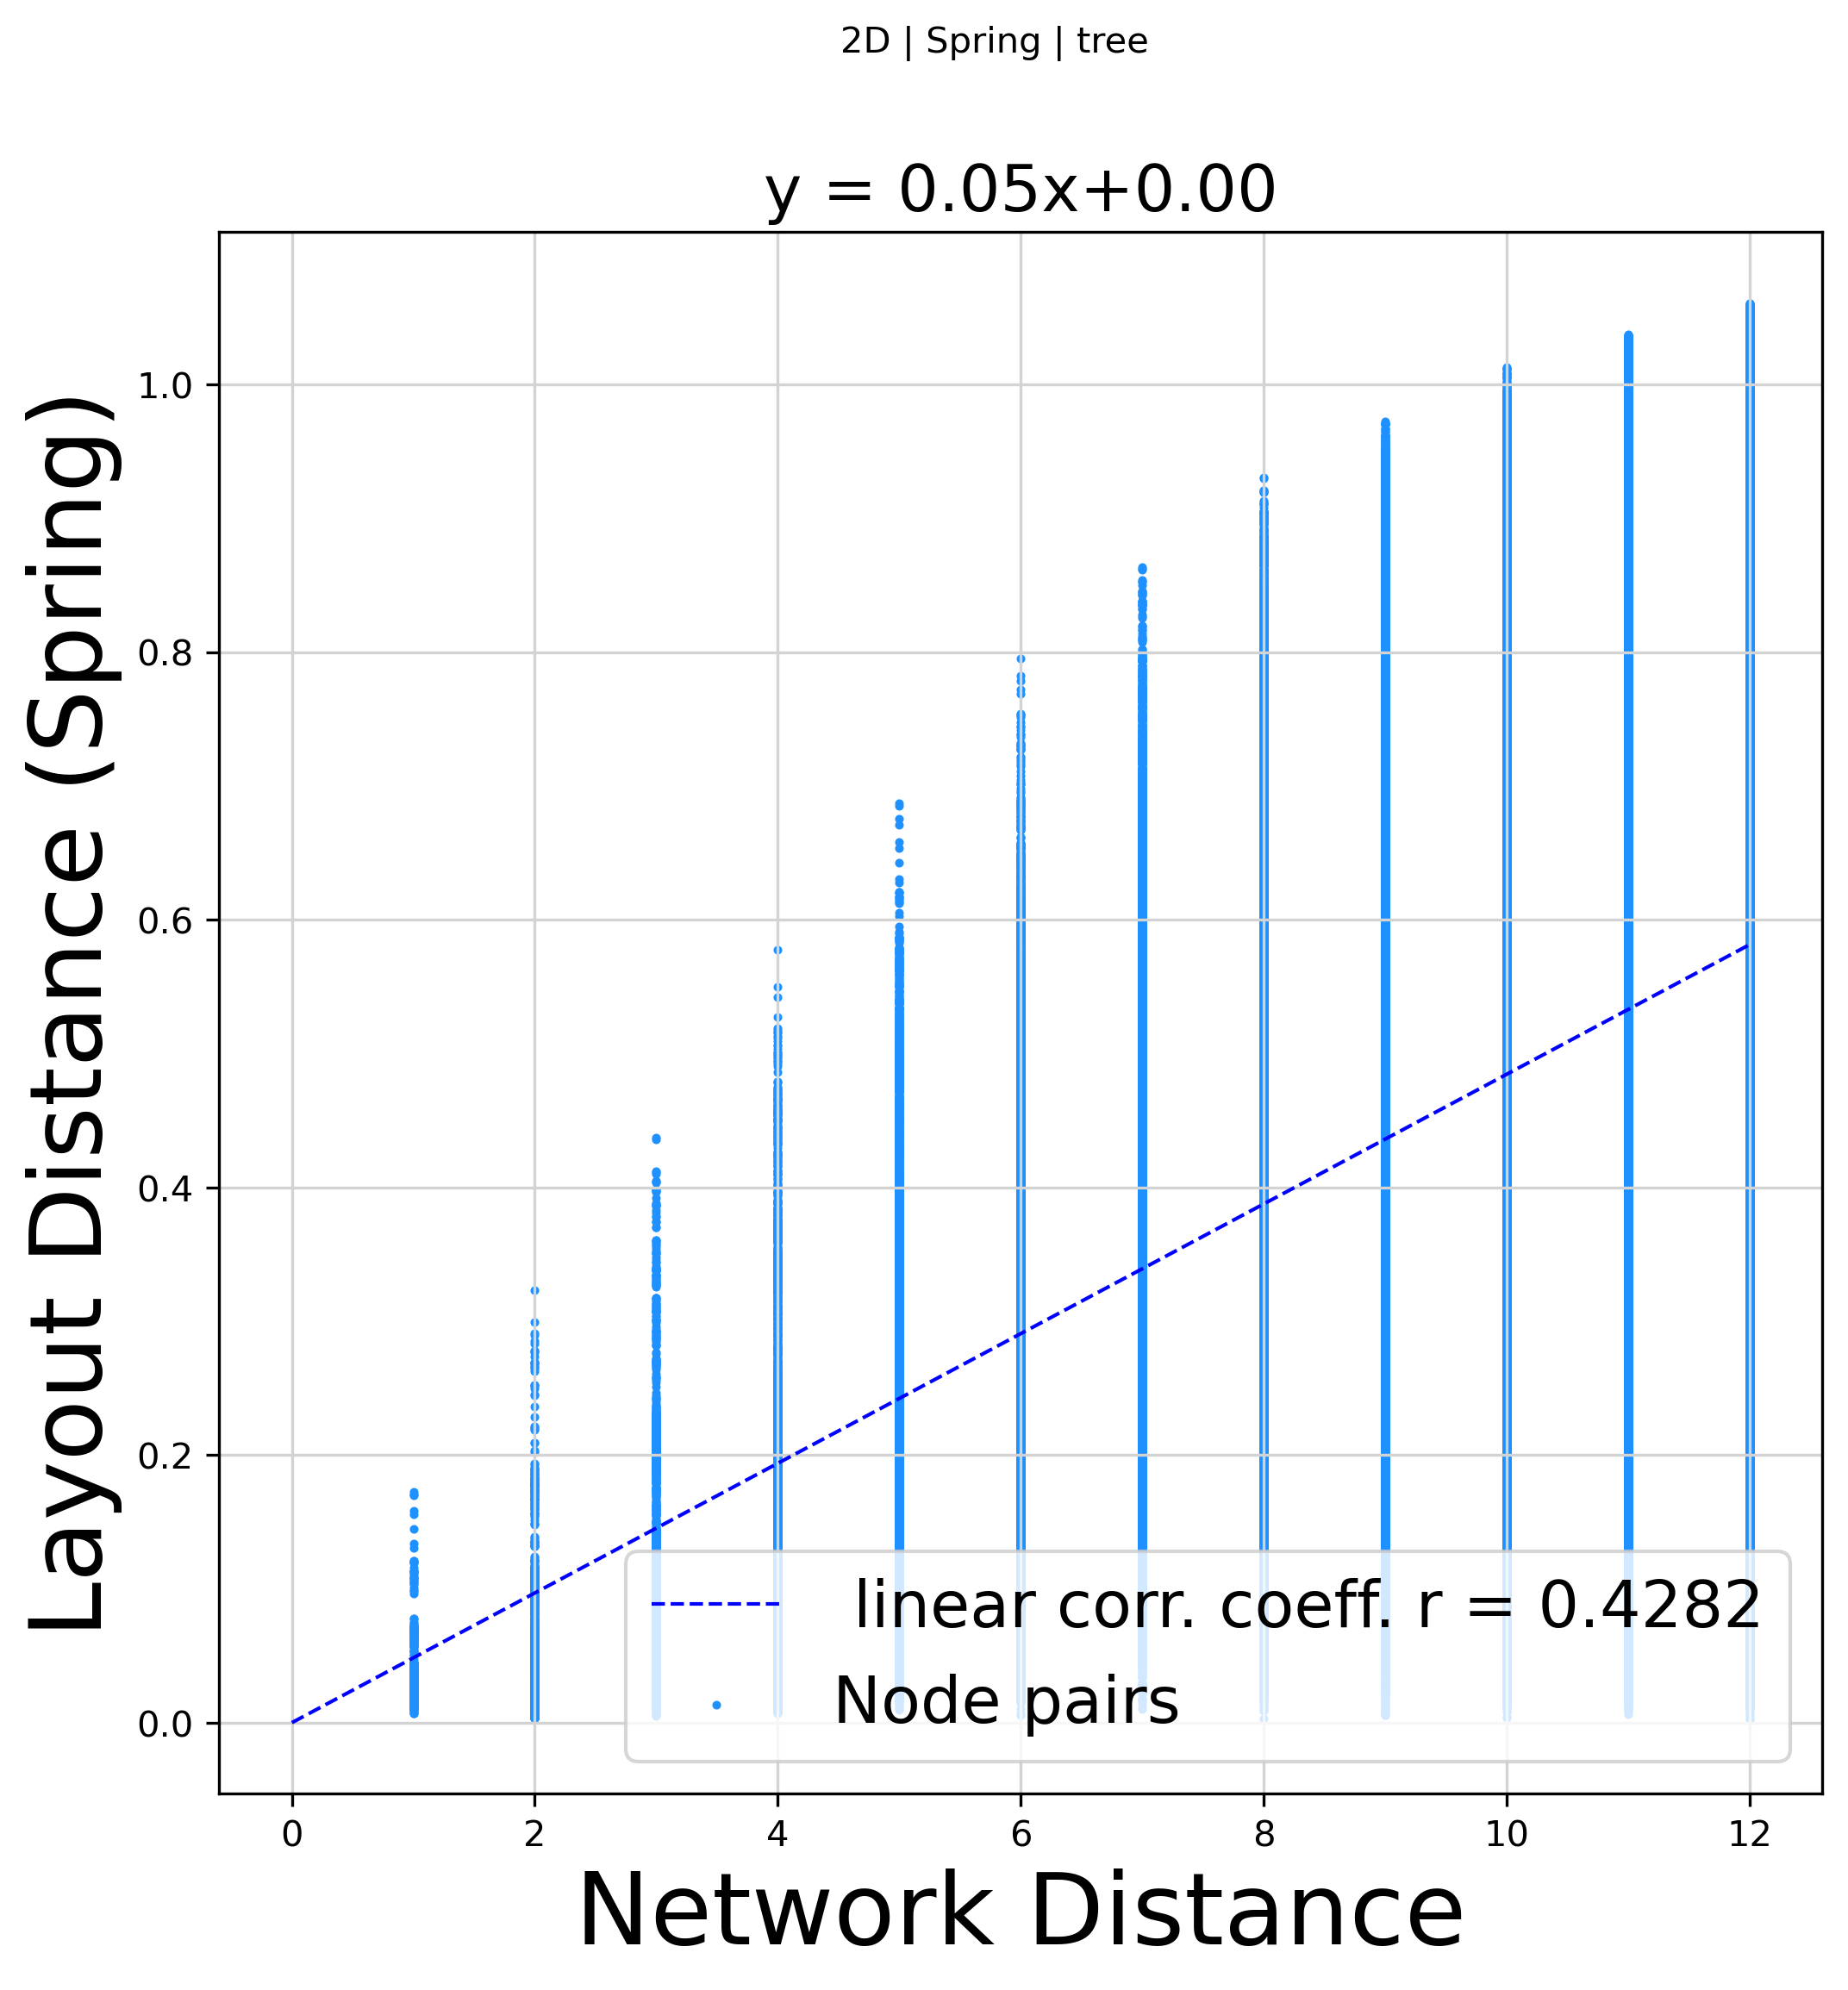

In [284]:
posG_spring2D = posG_spring2D_norm

# NETWORK DISTANCE
# depending on Network (e.g. toy network) 
# changes only with toy network, not with layout chosen 

dist_network = {}
for p1, p2 in combinations(DM_spl.index,2):
    dist_network[p1,p2] = DM_spl[p1][p2]


# SPRING
from itertools import combinations
dist_spring2D = dict()
for (id1,p1),(id2,p2) in combinations(posG_spring2D.items(),2):
    dx,dy = p1[0]-p2[0], p1[1]-p2[1]
    dist_spring2D[id1,id2] = math.sqrt(dx*dx+dy*dy)
    
# ------------------------------------------------------------
# get squareform dataframes from distances

dist_spring_list = [dist[1] for dist in sorted(dist_spring2D.items())]
df_spring2D = pd.DataFrame(dist.squareform(dist_spring_list), index=DM.index, columns=DM.columns)

# ------------------------------------------------------------
# remove all diagonal 0 values and values underneath diagonale (i.e. mirrored data)

# NETWORK DM to compare layouts with
m,n = DM_spl.shape
DM_spl_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,DM_spl))

m,n = df_spring2D.shape
df_spring2D_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,df_spring2D))


# ------------------------------------------------------------
# values of Dataframe into flattened list for Regression line

# Network DM to compare layouts with 
l_DM_spl = []
for i in range(len(DM_spl_mod)):
    l_DM_spl.append(DM_spl.iloc[i:i+1].values)

l_DM_spl_un = list(it.chain(*l_DM_spl))
l_DM_spl_flattened = list(it.chain(*l_DM_spl_un))


# SPRING 
l_spring2D = []
for i in range(len(df_spring2D_mod)):
    l_spring2D.append(df_spring2D.iloc[i:i+1].values)

l_spring2D_un = list(it.chain(*l_spring2D))
l_spring2D_flattened = list(it.chain(*l_spring2D_un))



# ------------------------------------------------------------
# PLOT SPRING
# ------------------------------------------------------------

fig = plt.figure(figsize=(8,8), dpi=300)
plt.grid(True, c='lightgrey')

y_spring = df_spring2D_mod
x_spring = DM_spl_mod
plt.scatter(x_spring,y_spring, c = 'dodgerblue', s = 2)

# REGRESSION LINE 
y_regr_spring = l_spring2D_flattened
x_regr_spring = l_DM_spl_flattened
gradient_spring, intercept_spring, r_value_spring, p_value_spring, std_err_spring = stats.linregress(x_regr_spring,y_regr_spring)
mn_spring=np.min(x_regr_spring)
mx_spring=np.max(x_regr_spring)
x1_spring=np.linspace(mn_spring,mx_spring,500)
line_spring =gradient_spring*x1_spring+intercept_spring
plt.plot(x1_spring,line_spring,'--b',linewidth=1.0)

plt.ylabel("Layout Distance (Spring)", fontsize=labelsize)
plt.xlabel("Network Distance", fontsize=labelsize)

plt.legend((' linear corr. coeff. r = {}'.format(round(r_value_spring,4)),'Node pairs'), loc='lower right', fontsize = legendfontsize)

plt.suptitle('2D | Spring | '+organism, fontsize=10)
plt.title('y = {:.2f}x+{:.2f}'.format(gradient_spring,intercept_spring), fontsize=legendfontsize)

fig.savefig('output_plots/2Dtoynetwork_NetworkDistance_SPRING_'+organism+'.png')

+ ADJACENCIES

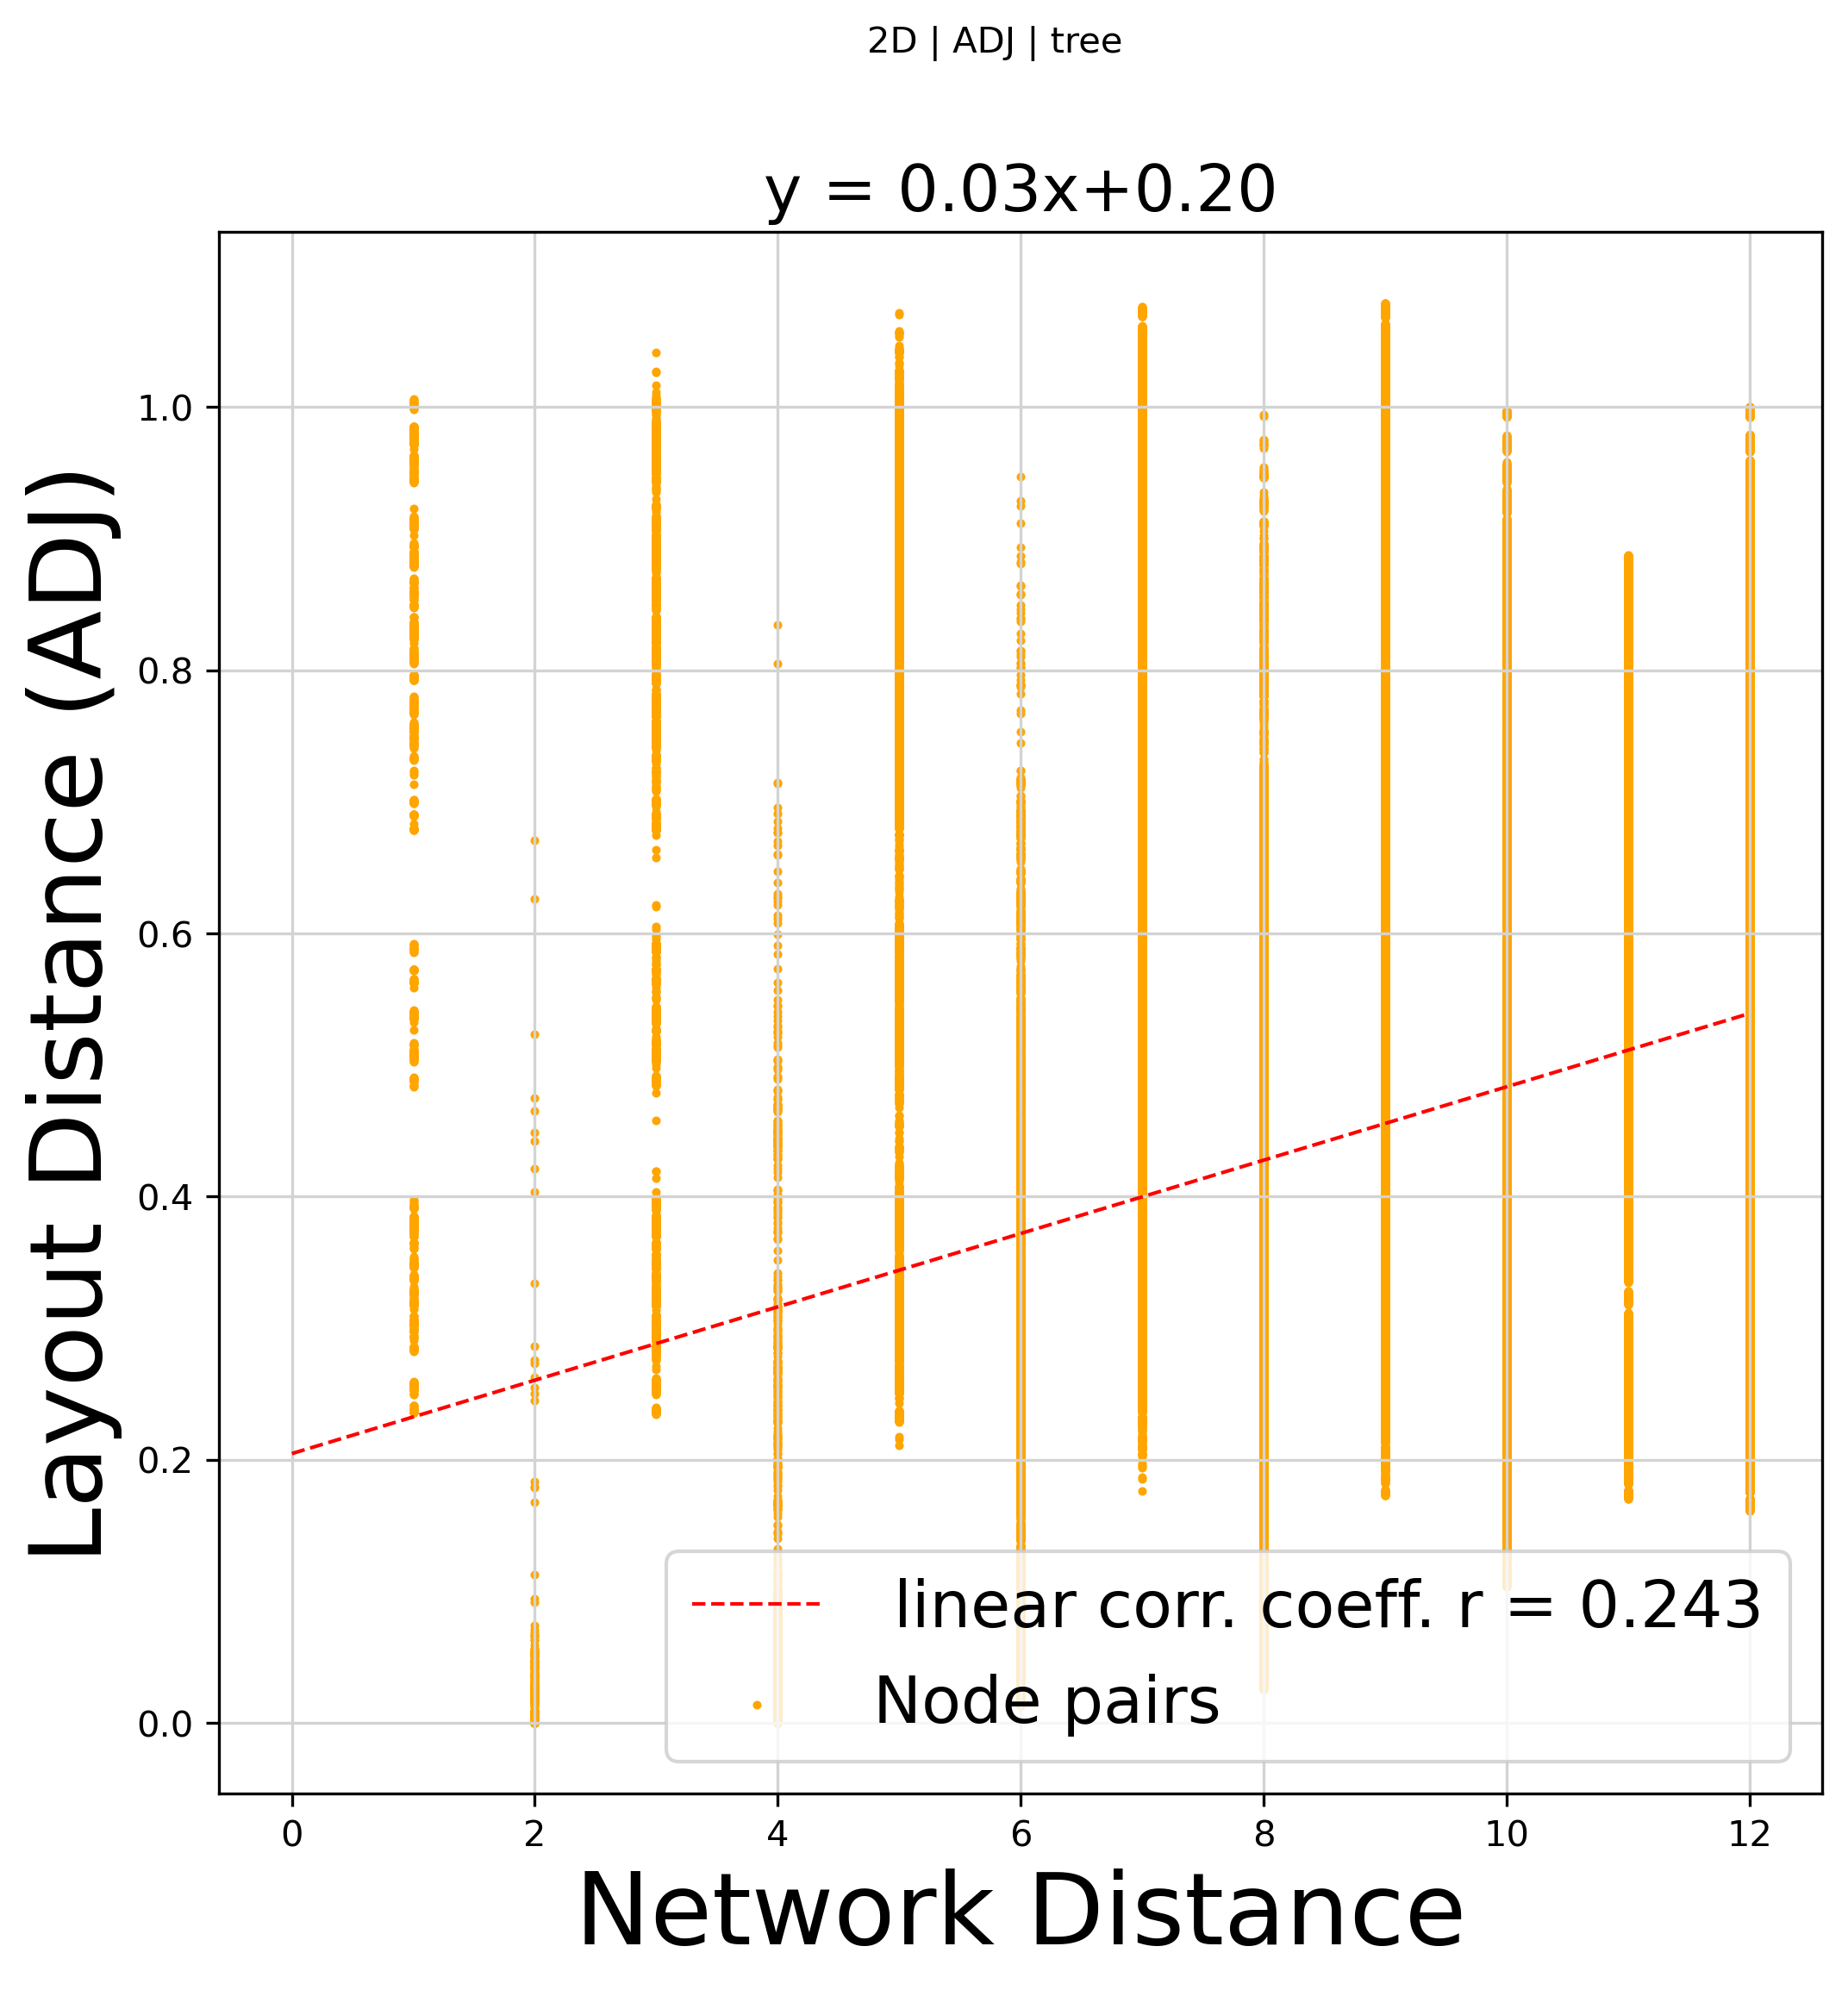

In [285]:
feature = 'ADJ'
DM = df_adj

posG_complete_umap = posG_complete_umap_adj_norm 

dist_network = {}
for p1, p2 in combinations(DM_spl.index,2):
    dist_network[p1,p2] = DM_spl[p1][p2]
       
# LAYOUT
from itertools import combinations
dist_layout2D = dict()
for (id1,p1),(id2,p2) in combinations(posG_complete_umap.items(),2):
    dx,dy = p1[0]-p2[0], p1[1]-p2[1]
    dist_layout2D[id1,id2] = math.sqrt(dx*dx+dy*dy)

# ------------------------------------------------------------
# get squareform dataframes from distances

dist_layout_list = [dist[1] for dist in sorted(dist_layout2D.items())]
df_layout2D = pd.DataFrame(dist.squareform(dist_layout_list), index=DM.index, columns=DM.columns)


# ------------------------------------------------------------
# remove all diagonal 0 values and values underneath diagonale (i.e. mirrored data)

# NETWORK DM to compare layouts with
m,n = DM_spl.shape
DM_spl_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,DM_spl))

m,n = df_layout2D.shape
df_layout2D_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,df_layout2D))


# ------------------------------------------------------------
# values of Dataframe into flattened list for Regression line

# Network DM to compare layouts with 
l_DM_spl = []
for i in range(len(DM_spl_mod)):
    l_DM_spl.append(DM_spl.iloc[i:i+1].values)

l_DM_spl_un = list(it.chain(*l_DM_spl))
l_DM_spl_flattened = list(it.chain(*l_DM_spl_un))


l_layout2D = []
for i in range(len(df_layout2D_mod)):
    l_layout2D.append(df_layout2D.iloc[i:i+1].values)

l_layout2D_un = list(it.chain(*l_layout2D))
l_layout2D_flattened = list(it.chain(*l_layout2D_un))


# ------------------------------------------------------------
# PLOT LAYOUT
# ------------------------------------------------------------

fig = plt.figure(figsize=(8,8), dpi=300)
plt.grid(True, c='lightgrey')

y_layout = df_layout2D_mod
x_layout = DM_spl_mod
plt.scatter(x_layout,y_layout, c = 'orange', s = 2)

# REGRESSION LINE 
y_regr_layout = l_layout2D_flattened
x_regr_layout = l_DM_spl_flattened
gradient_layout, intercept_layout, r_value_layout, p_value_layout, std_err_layout = stats.linregress(x_regr_layout,y_regr_layout)
mn_layout=np.min(x_regr_layout)
mx_layout=np.max(x_regr_layout)
x1_layout=np.linspace(mn_layout,mx_layout,500)
line_layout = gradient_layout*x1_layout+intercept_layout
plt.plot(x1_layout,line_layout,'--r',linewidth=1.0)

plt.ylabel("Layout Distance "+"("+feature+")", fontsize=labelsize)
plt.xlabel("Network Distance", fontsize=labelsize)


plt.legend((' linear corr. coeff. r = {}'.format(round(r_value_layout,4)),'Node pairs'), loc='lower right', fontsize = legendfontsize)

plt.suptitle('2D | '+feature+' | '+organism, fontsize=10)
plt.title('y = {:.2f}x+{:.2f}'.format(gradient_layout,intercept_layout), fontsize=legendfontsize)

fig.savefig('output_plots/2Dtoynetwork_NetworkDistance_LAYOUT_'+feature+'_'+organism+'.png')

+ RANDOM WALK 

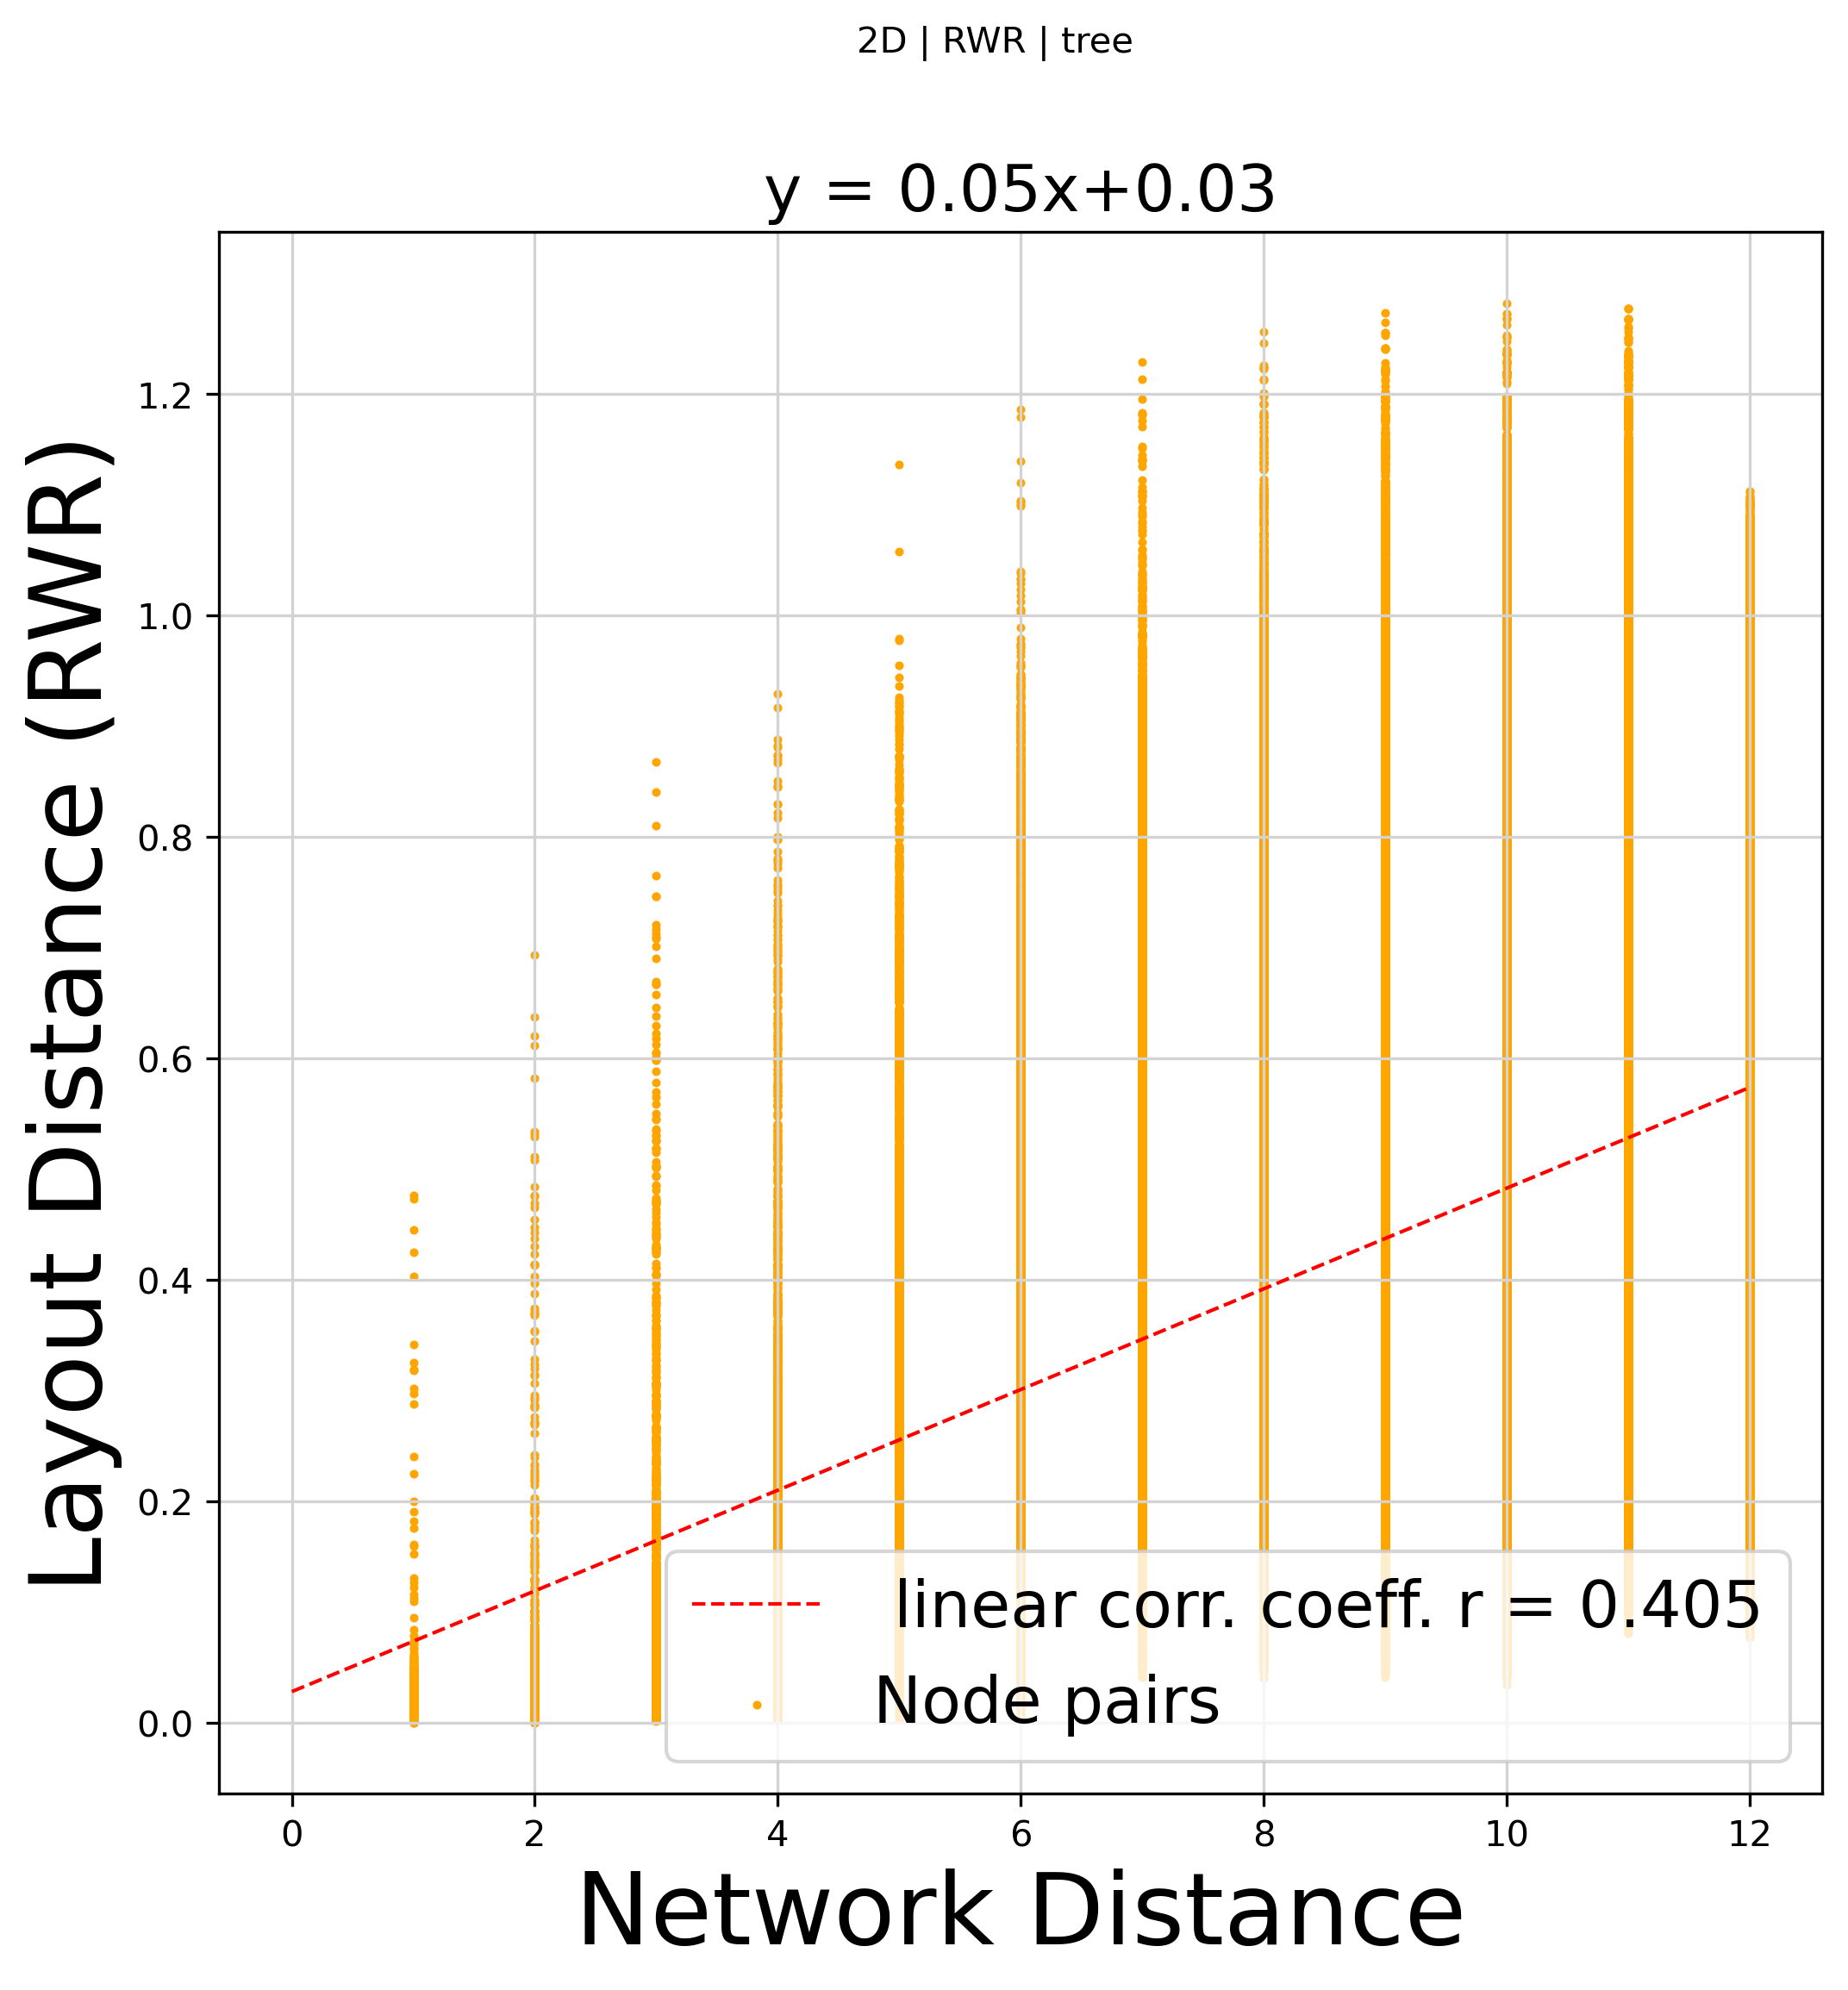

In [286]:
feature = 'RWR'
DM = DM_m

posG_complete_umap = posG_complete_umap_rwr_norm 

# NETWORK DISTANCE
# depending on Network (e.g. toy network) 
# changes only with toy network, not with layout chosen 

dist_network = {}
for p1, p2 in combinations(DM_spl.index,2):
    dist_network[p1,p2] = DM_spl[p1][p2]
    
from itertools import combinations
dist_layout2D = dict()
for (id1,p1),(id2,p2) in combinations(posG_complete_umap.items(),2):
    dx,dy = p1[0]-p2[0], p1[1]-p2[1]
    dist_layout2D[id1,id2] = math.sqrt(dx*dx+dy*dy)
    

# ------------------------------------------------------------
# get squareform dataframes from distances

dist_layout_list = [dist[1] for dist in sorted(dist_layout2D.items())]
df_layout2D = pd.DataFrame(dist.squareform(dist_layout_list), index=DM.index, columns=DM.columns)


# ------------------------------------------------------------
# remove all diagonal 0 values and values underneath diagonale (i.e. mirrored data)

# NETWORK DM to compare layouts with
m,n = DM_spl.shape
DM_spl_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,DM_spl))

m,n = df_layout2D.shape
df_layout2D_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,df_layout2D))


# ------------------------------------------------------------
# values of Dataframe into flattened list for Regression line

# Network DM to compare layouts with 
l_DM_spl = []
for i in range(len(DM_spl_mod)):
    l_DM_spl.append(DM_spl.iloc[i:i+1].values)

l_DM_spl_un = list(it.chain(*l_DM_spl))
l_DM_spl_flattened = list(it.chain(*l_DM_spl_un))


l_layout2D = []
for i in range(len(df_layout2D_mod)):
    l_layout2D.append(df_layout2D.iloc[i:i+1].values)

l_layout2D_un = list(it.chain(*l_layout2D))
l_layout2D_flattened = list(it.chain(*l_layout2D_un))


# ------------------------------------------------------------
# PLOT LAYOUT
# ------------------------------------------------------------

fig = plt.figure(figsize=(8,8), dpi=300)
plt.grid(True, c='lightgrey')

y_layout = df_layout2D_mod
x_layout = DM_spl_mod
plt.scatter(x_layout,y_layout, c = 'orange', s = 2)

# REGRESSION LINE 
y_regr_layout = l_layout2D_flattened
x_regr_layout = l_DM_spl_flattened
gradient_layout, intercept_layout, r_value_layout, p_value_layout, std_err_layout = stats.linregress(x_regr_layout,y_regr_layout)
mn_layout=np.min(x_regr_layout)
mx_layout=np.max(x_regr_layout)
x1_layout=np.linspace(mn_layout,mx_layout,500)
line_layout = gradient_layout*x1_layout+intercept_layout
plt.plot(x1_layout,line_layout,'--r',linewidth=1.0)

plt.ylabel("Layout Distance "+"("+feature+")", fontsize=labelsize)
plt.xlabel("Network Distance", fontsize=labelsize)


plt.legend((' linear corr. coeff. r = {}'.format(round(r_value_layout,4)),'Node pairs'), loc='lower right', fontsize = legendfontsize)

plt.suptitle('2D | '+feature+' | '+organism, fontsize=10)
plt.title('y = {:.2f}x+{:.2f}'.format(gradient_layout,intercept_layout), fontsize=legendfontsize)

fig.savefig('output_plots/2Dtoynetwork_NetworkDistance_LAYOUT_'+feature+'_'+organism+'.png')

+ CENTRALITIES

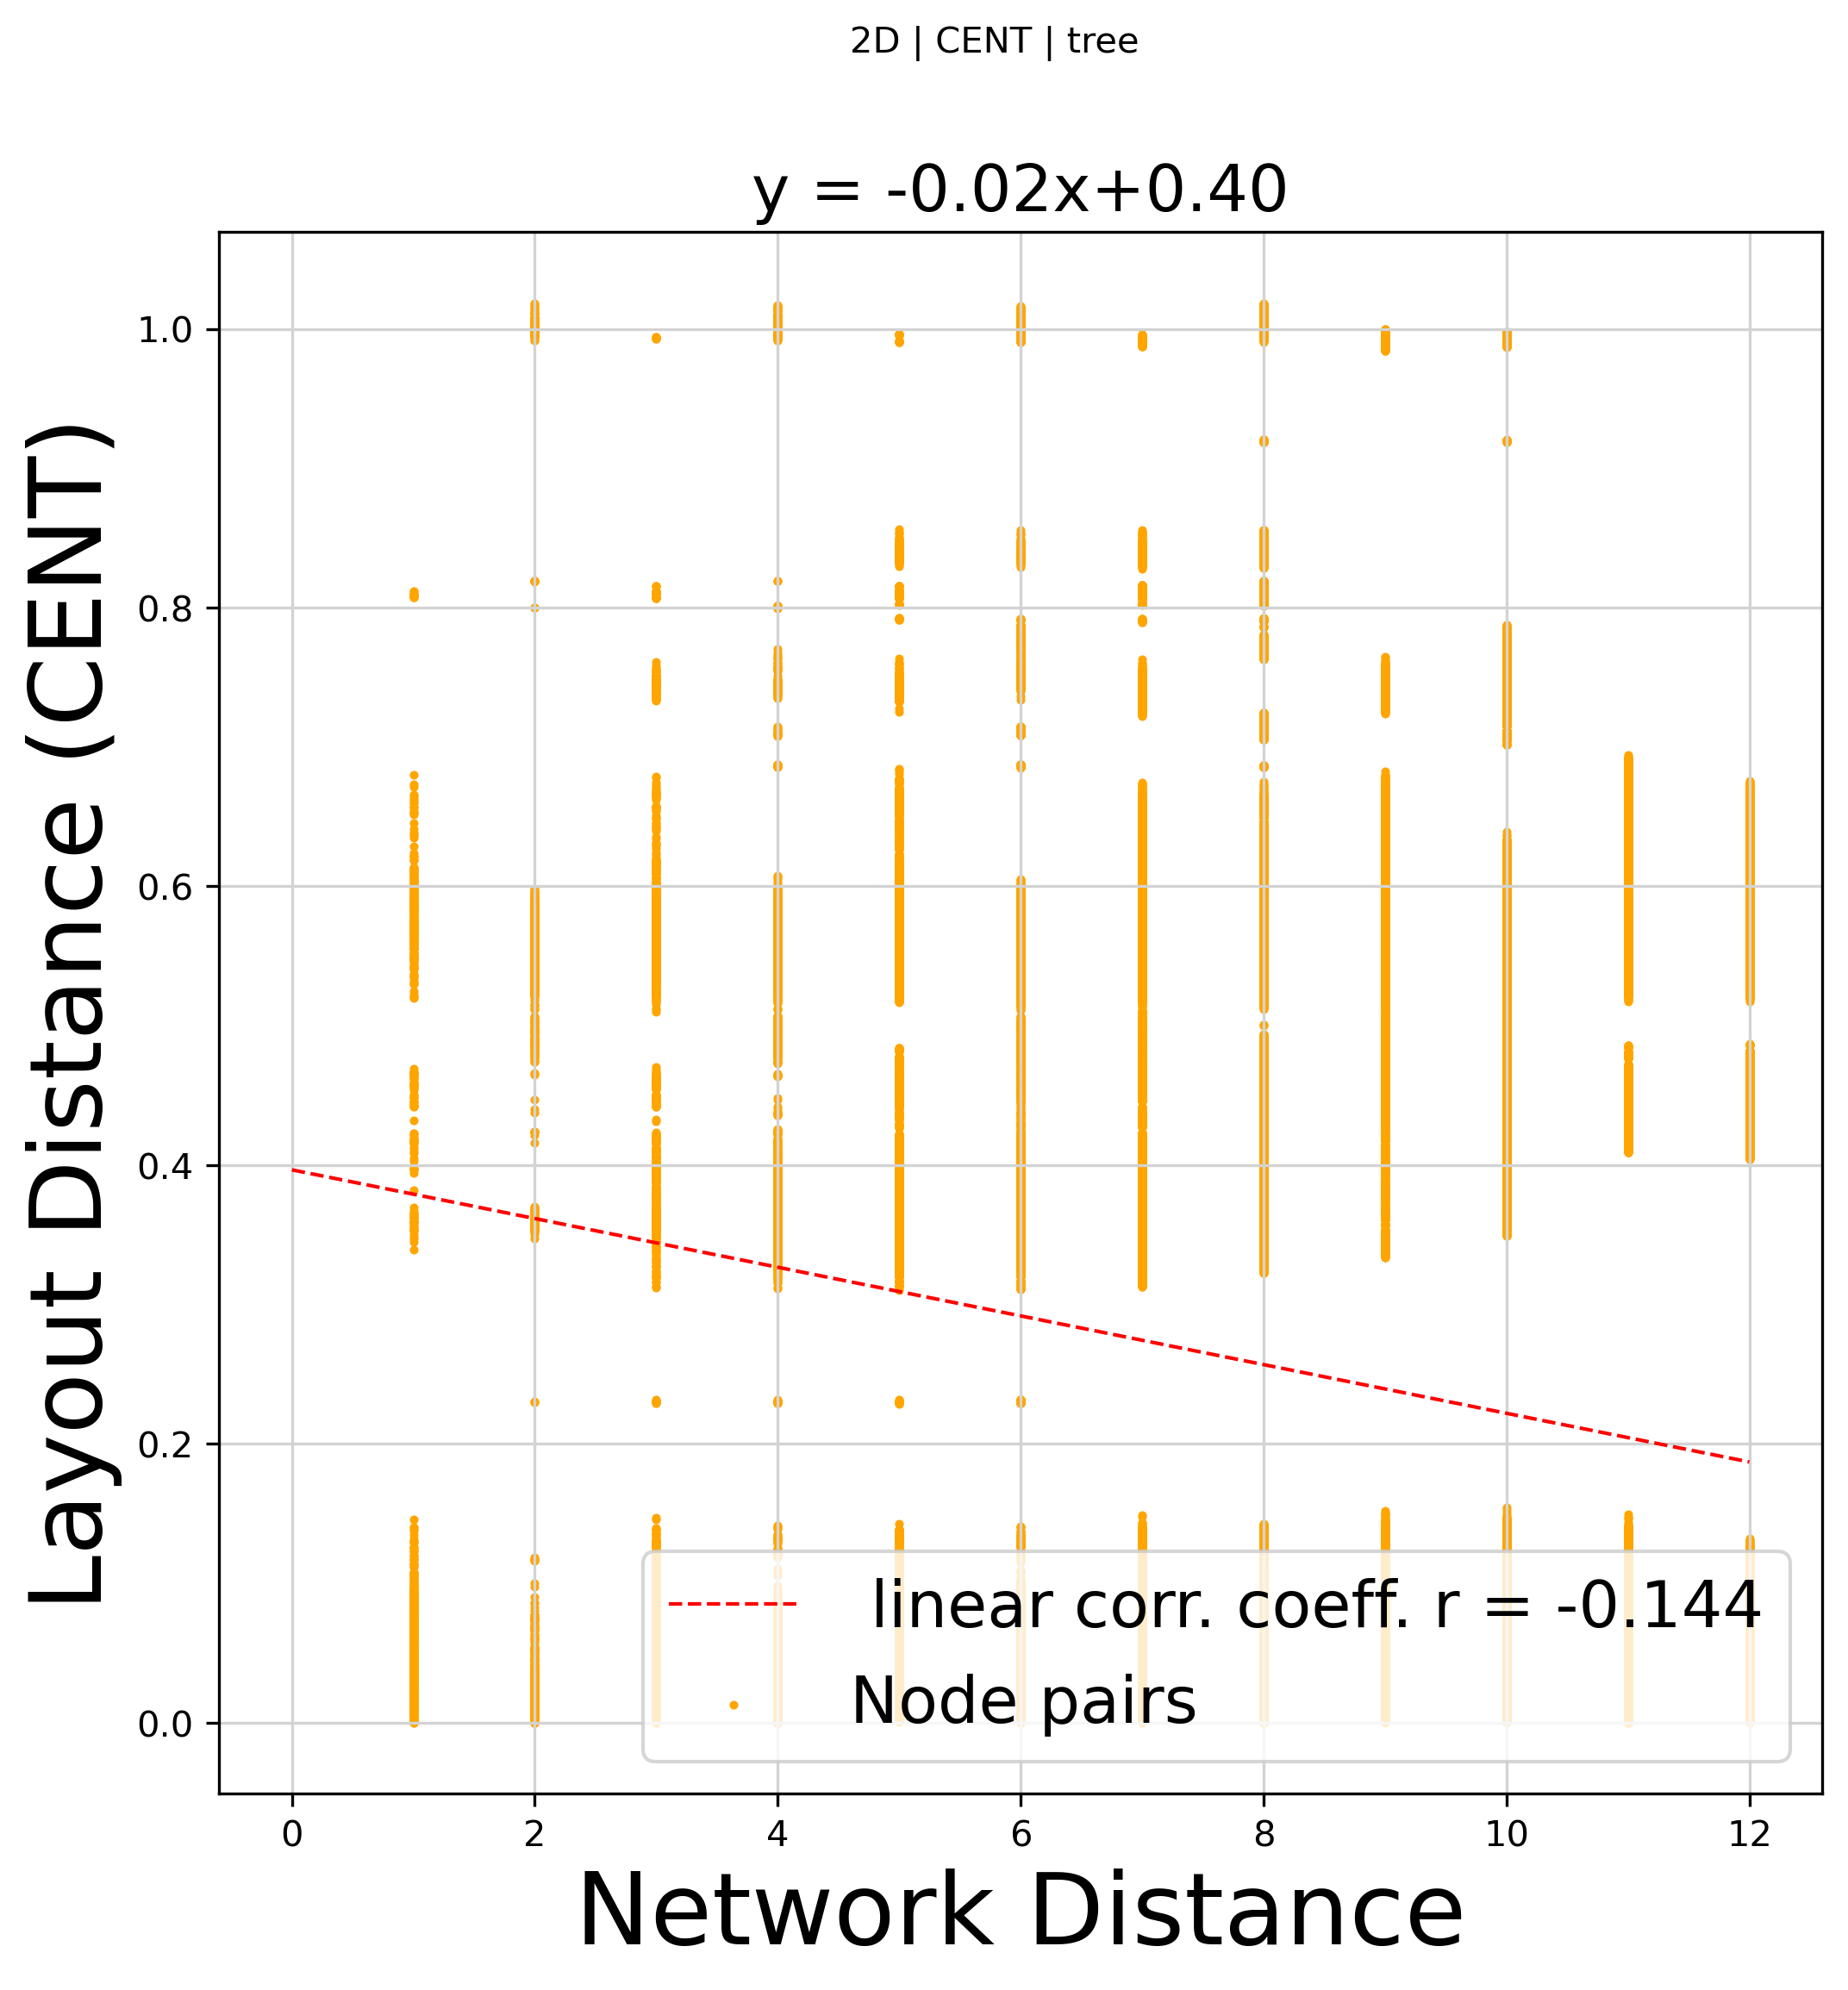

In [287]:
feature = 'CENT'
DM = DM_cent

posG_complete_umap = posG_complete_umap_cent_norm 

# NETWORK DISTANCE
# depending on Network (e.g. toy network) 
# changes only with toy network, not with layout chosen 

dist_network = {}
for p1, p2 in combinations(DM_spl.index,2):
    dist_network[p1,p2] = DM_spl[p1][p2]
    
from itertools import combinations
dist_layout2D = dict()
for (id1,p1),(id2,p2) in combinations(posG_complete_umap.items(),2):
    dx,dy = p1[0]-p2[0], p1[1]-p2[1]
    dist_layout2D[id1,id2] = math.sqrt(dx*dx+dy*dy)
    

# ------------------------------------------------------------
# get squareform dataframes from distances

dist_layout_list = [dist[1] for dist in sorted(dist_layout2D.items())]
df_layout2D = pd.DataFrame(dist.squareform(dist_layout_list), index=DM.index, columns=DM.columns)


# ------------------------------------------------------------
# remove all diagonal 0 values and values underneath diagonale (i.e. mirrored data)

# NETWORK DM to compare layouts with
m,n = DM_spl.shape
DM_spl_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,DM_spl))

m,n = df_layout2D.shape
df_layout2D_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,df_layout2D))


# ------------------------------------------------------------
# values of Dataframe into flattened list for Regression line

# Network DM to compare layouts with 
l_DM_spl = []
for i in range(len(DM_spl_mod)):
    l_DM_spl.append(DM_spl.iloc[i:i+1].values)

l_DM_spl_un = list(it.chain(*l_DM_spl))
l_DM_spl_flattened = list(it.chain(*l_DM_spl_un))


l_layout2D = []
for i in range(len(df_layout2D_mod)):
    l_layout2D.append(df_layout2D.iloc[i:i+1].values)

l_layout2D_un = list(it.chain(*l_layout2D))
l_layout2D_flattened = list(it.chain(*l_layout2D_un))


# ------------------------------------------------------------
# PLOT LAYOUT
# ------------------------------------------------------------

fig = plt.figure(figsize=(8,8), dpi=300)
plt.grid(True, c='lightgrey')

y_layout = df_layout2D_mod
x_layout = DM_spl_mod
plt.scatter(x_layout,y_layout, c = 'orange', s = 2)

# REGRESSION LINE 
y_regr_layout = l_layout2D_flattened
x_regr_layout = l_DM_spl_flattened
gradient_layout, intercept_layout, r_value_layout, p_value_layout, std_err_layout = stats.linregress(x_regr_layout,y_regr_layout)
mn_layout=np.min(x_regr_layout)
mx_layout=np.max(x_regr_layout)
x1_layout=np.linspace(mn_layout,mx_layout,500)
line_layout = gradient_layout*x1_layout+intercept_layout
plt.plot(x1_layout,line_layout,'--r',linewidth=1.0)

plt.ylabel("Layout Distance "+"("+feature+")", fontsize=labelsize)
plt.xlabel("Network Distance", fontsize=labelsize)


plt.legend((' linear corr. coeff. r = {}'.format(round(r_value_layout,4)),'Node pairs'), loc='lower right', fontsize = legendfontsize)

plt.suptitle('2D | '+feature+' | '+organism, fontsize=10)
plt.title('y = {:.2f}x+{:.2f}'.format(gradient_layout,intercept_layout), fontsize=legendfontsize)

fig.savefig('output_plots/2Dtoynetwork_NetworkDistance_LAYOUT_'+feature+'_'+organism+'.png')

______________
# 3D BENCHMARK - visual + statistical 
______________

## SPRING

In [236]:
%%time 

posG_spring3D = nx.spring_layout(G, iterations = 200, dim = 3)

CPU times: user 17.4 s, sys: 51.6 ms, total: 17.5 s
Wall time: 17.6 s


In [237]:

# normalize coordinates 
x_list = []
y_list = []
z_list = []
for k,v in posG_spring3D.items():
    x_list.append(v[0])
    y_list.append(v[1])
    z_list.append(v[2])
    
xx_norm = sklearn.preprocessing.minmax_scale(x_list, feature_range=(0, 1), axis=0, copy=True)
yy_norm = sklearn.preprocessing.minmax_scale(y_list, feature_range=(0, 1), axis=0, copy=True)
zz_norm = sklearn.preprocessing.minmax_scale(z_list, feature_range=(0, 1), axis=0, copy=True)

posG_spring3D_norm = dict(zip(list(G.nodes()), zip(xx_norm,yy_norm, zz_norm)))


spring_nodes = get_trace_nodes_3D(posG_spring3D_norm, None, colours, 4) #size3d)
spring_edges = get_trace_edges_3D(G, posG_spring3D_norm, edge_colordark, opac=1)

spring_data = [spring_nodes, spring_edges]

print('Spring Layout:', organism)

fig = pgo.Figure()
for i in spring_data:
    fig.add_trace(i)
'''fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                    dragmode="turntable",
                    #annotations=annotations,
                ))'''

fig.update_layout(template='plotly_white', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='white')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dtoynetwork_'+'spring_'+organism+'.html', auto_open=True)

Spring Layout: tree


'output_plots/3Dtoynetwork_spring_tree.html'

## 3D PORTRAITS

+ ADJACENCIES

In [238]:
n_neighbors = 20 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.1 #defines how dense points are stacked together 
metric ='cosine'

In [251]:
%%time 

feature = 'ADJ'
DM = df_adj
umap_3D_adj = embed_umap_3D(DM, n_neighbors, spread, min_dist, metric)

posG_3Dumap_adj = get_posG_3D(list(G.nodes()), umap_3D_adj)
posG_3D_complete_umap_adj = {key:posG_3Dumap_adj[key] for key in G.nodes()}

CPU times: user 6.43 s, sys: 256 ms, total: 6.68 s
Wall time: 4.31 s


In [252]:
# normalize coordinates 
x_adj_list = []
y_adj_list = []
z_adj_list = []
for k,v in posG_3D_complete_umap_adj.items():
    x_adj_list.append(v[0])
    y_adj_list.append(v[1])
    z_adj_list.append(v[2])
    
xx_adj_norm = sklearn.preprocessing.minmax_scale(x_adj_list, feature_range=(0, 1), axis=0, copy=True)
yy_adj_norm = sklearn.preprocessing.minmax_scale(y_adj_list, feature_range=(0, 1), axis=0, copy=True)
zz_adj_norm = sklearn.preprocessing.minmax_scale(z_adj_list, feature_range=(0, 1), axis=0, copy=True)

posG_3D_complete_umap_adj_norm = dict(zip(list(G.nodes()), zip(xx_adj_norm,yy_adj_norm, zz_adj_norm)))


umap_adj_nodes = get_trace_nodes_3D(posG_3D_complete_umap_adj_norm, None, colours, 4) # size3d)
umap_adj_edges = get_trace_edges_3D(G, posG_3D_complete_umap_adj_norm, edge_colordark, 1.0) 

umap_adj_data = [umap_adj_edges, umap_adj_nodes]

In [253]:
fig = pgo.Figure()
for i in umap_adj_data:
    fig.add_trace(i)

'''fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    '''

fig.update_layout(template='plotly_white', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='white')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dtoynetwork_umap_'+feature+'_'+organism+'.html', auto_open=True)

'output_plots/3Dtoynetwork_umap_ADJ_tree.html'

+ RANDOM WALK 

In [264]:
n_neighbors = 8 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.1 #defines how dense points are stacked together 
metric ='cosine'

In [265]:
%%time 

feature = 'RWR'
DM = DM_m
umap_rwr_3D = embed_umap_3D(DM, n_neighbors, spread, min_dist, metric)

posG_3Dumap_rwr = get_posG_3D(list(G.nodes()), umap_rwr_3D)
posG_3D_complete_umap_rwr = {key:posG_3Dumap_rwr[key] for key in G.nodes()}

CPU times: user 6.2 s, sys: 202 ms, total: 6.4 s
Wall time: 3.82 s


In [266]:
# normalize coordinates 
x_rwr_list = []
y_rwr_list = []
z_rwr_list = []
for k,v in posG_3D_complete_umap_rwr.items():
    x_rwr_list.append(v[0])
    y_rwr_list.append(v[1])
    z_rwr_list.append(v[2])
    
xx_rwr_norm = sklearn.preprocessing.minmax_scale(x_rwr_list, feature_range=(0, 1), axis=0, copy=True)
yy_rwr_norm = sklearn.preprocessing.minmax_scale(y_rwr_list, feature_range=(0, 1), axis=0, copy=True)
zz_rwr_norm = sklearn.preprocessing.minmax_scale(z_rwr_list, feature_range=(0, 1), axis=0, copy=True)

posG_3D_complete_umap_rwr_norm = dict(zip(list(G.nodes()), zip(xx_rwr_norm,yy_rwr_norm, zz_rwr_norm)))


umap_rwr_nodes = get_trace_nodes_3D(posG_3D_complete_umap_rwr_norm, None, colours, 4) # size3d)
umap_rwr_edges = get_trace_edges_3D(G, posG_3D_complete_umap_rwr_norm, edge_colordark, 1.0) 

umap_rwr_data = [umap_rwr_edges, umap_rwr_nodes]

In [267]:
fig = pgo.Figure()
for i in umap_rwr_data:
    fig.add_trace(i)

'''fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    '''

fig.update_layout(template='plotly_white', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='white')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dtoynetwork_umap_'+feature+'_'+organism+'.html', auto_open=True)

'output_plots/3Dtoynetwork_umap_RWR_tree.html'

+ CENTRALITIES

In [246]:
n_neighbors = 8 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.1 #defines how dense points are stacked together 
metric ='cosine'

In [257]:
%%time 

feature = 'CENT'
DM = DM_cent
umap_cent_3D = embed_umap_3D(DM, n_neighbors, spread, min_dist, metric)

posG_3Dumap_cent = get_posG_3D(list(G.nodes()), umap_cent_3D)
posG_3D_complete_umap_cent = {key:posG_3Dumap_cent[key] for key in G.nodes()}

CPU times: user 12.9 s, sys: 248 ms, total: 13.2 s
Wall time: 5.2 s


In [258]:
# normalize coordinates 
x_cent_list = []
y_cent_list = []
z_cent_list = []
for k,v in posG_3D_complete_umap_cent.items():
    x_cent_list.append(v[0])
    y_cent_list.append(v[1])
    z_cent_list.append(v[2])
    
xx_cent_norm = sklearn.preprocessing.minmax_scale(x_cent_list, feature_range=(0, 1), axis=0, copy=True)
yy_cent_norm = sklearn.preprocessing.minmax_scale(y_cent_list, feature_range=(0, 1), axis=0, copy=True)
zz_cent_norm = sklearn.preprocessing.minmax_scale(z_cent_list, feature_range=(0, 1), axis=0, copy=True)

posG_3D_complete_umap_cent_norm = dict(zip(list(G.nodes()), zip(xx_cent_norm,yy_cent_norm, zz_cent_norm)))


umap_cent_nodes = get_trace_nodes_3D(posG_3D_complete_umap_cent_norm, None, colours, 4) # size3d)
umap_cent_edges = get_trace_edges_3D(G, posG_3D_complete_umap_cent_norm, edge_colordark, 1.0) 

umap_cent_data = [umap_cent_edges, umap_cent_nodes]

In [259]:
fig = pgo.Figure()
for i in umap_cent_data:
    fig.add_trace(i)

'''fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    '''

fig.update_layout(template='plotly_white', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='white')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dtoynetwork_umap_'+feature+'_'+organism+'.html', auto_open=True)

'output_plots/3Dtoynetwork_umap_CENT_tree.html'

_________

# EVALUATION PART I - 3D 
### DM-distance vs. Layout Distance 
+ Plots to compare Distance-matrix deriving Distances with embedded Layout Distances 
+ X-axis = Reference axis i.e. Matrix Distance 
+ Y-axis = Layout Distance 

## 3D layouts Correlation diagrams (CALCULATED vs. LAYOUT DISTANCE)

+ ADJACENCIES

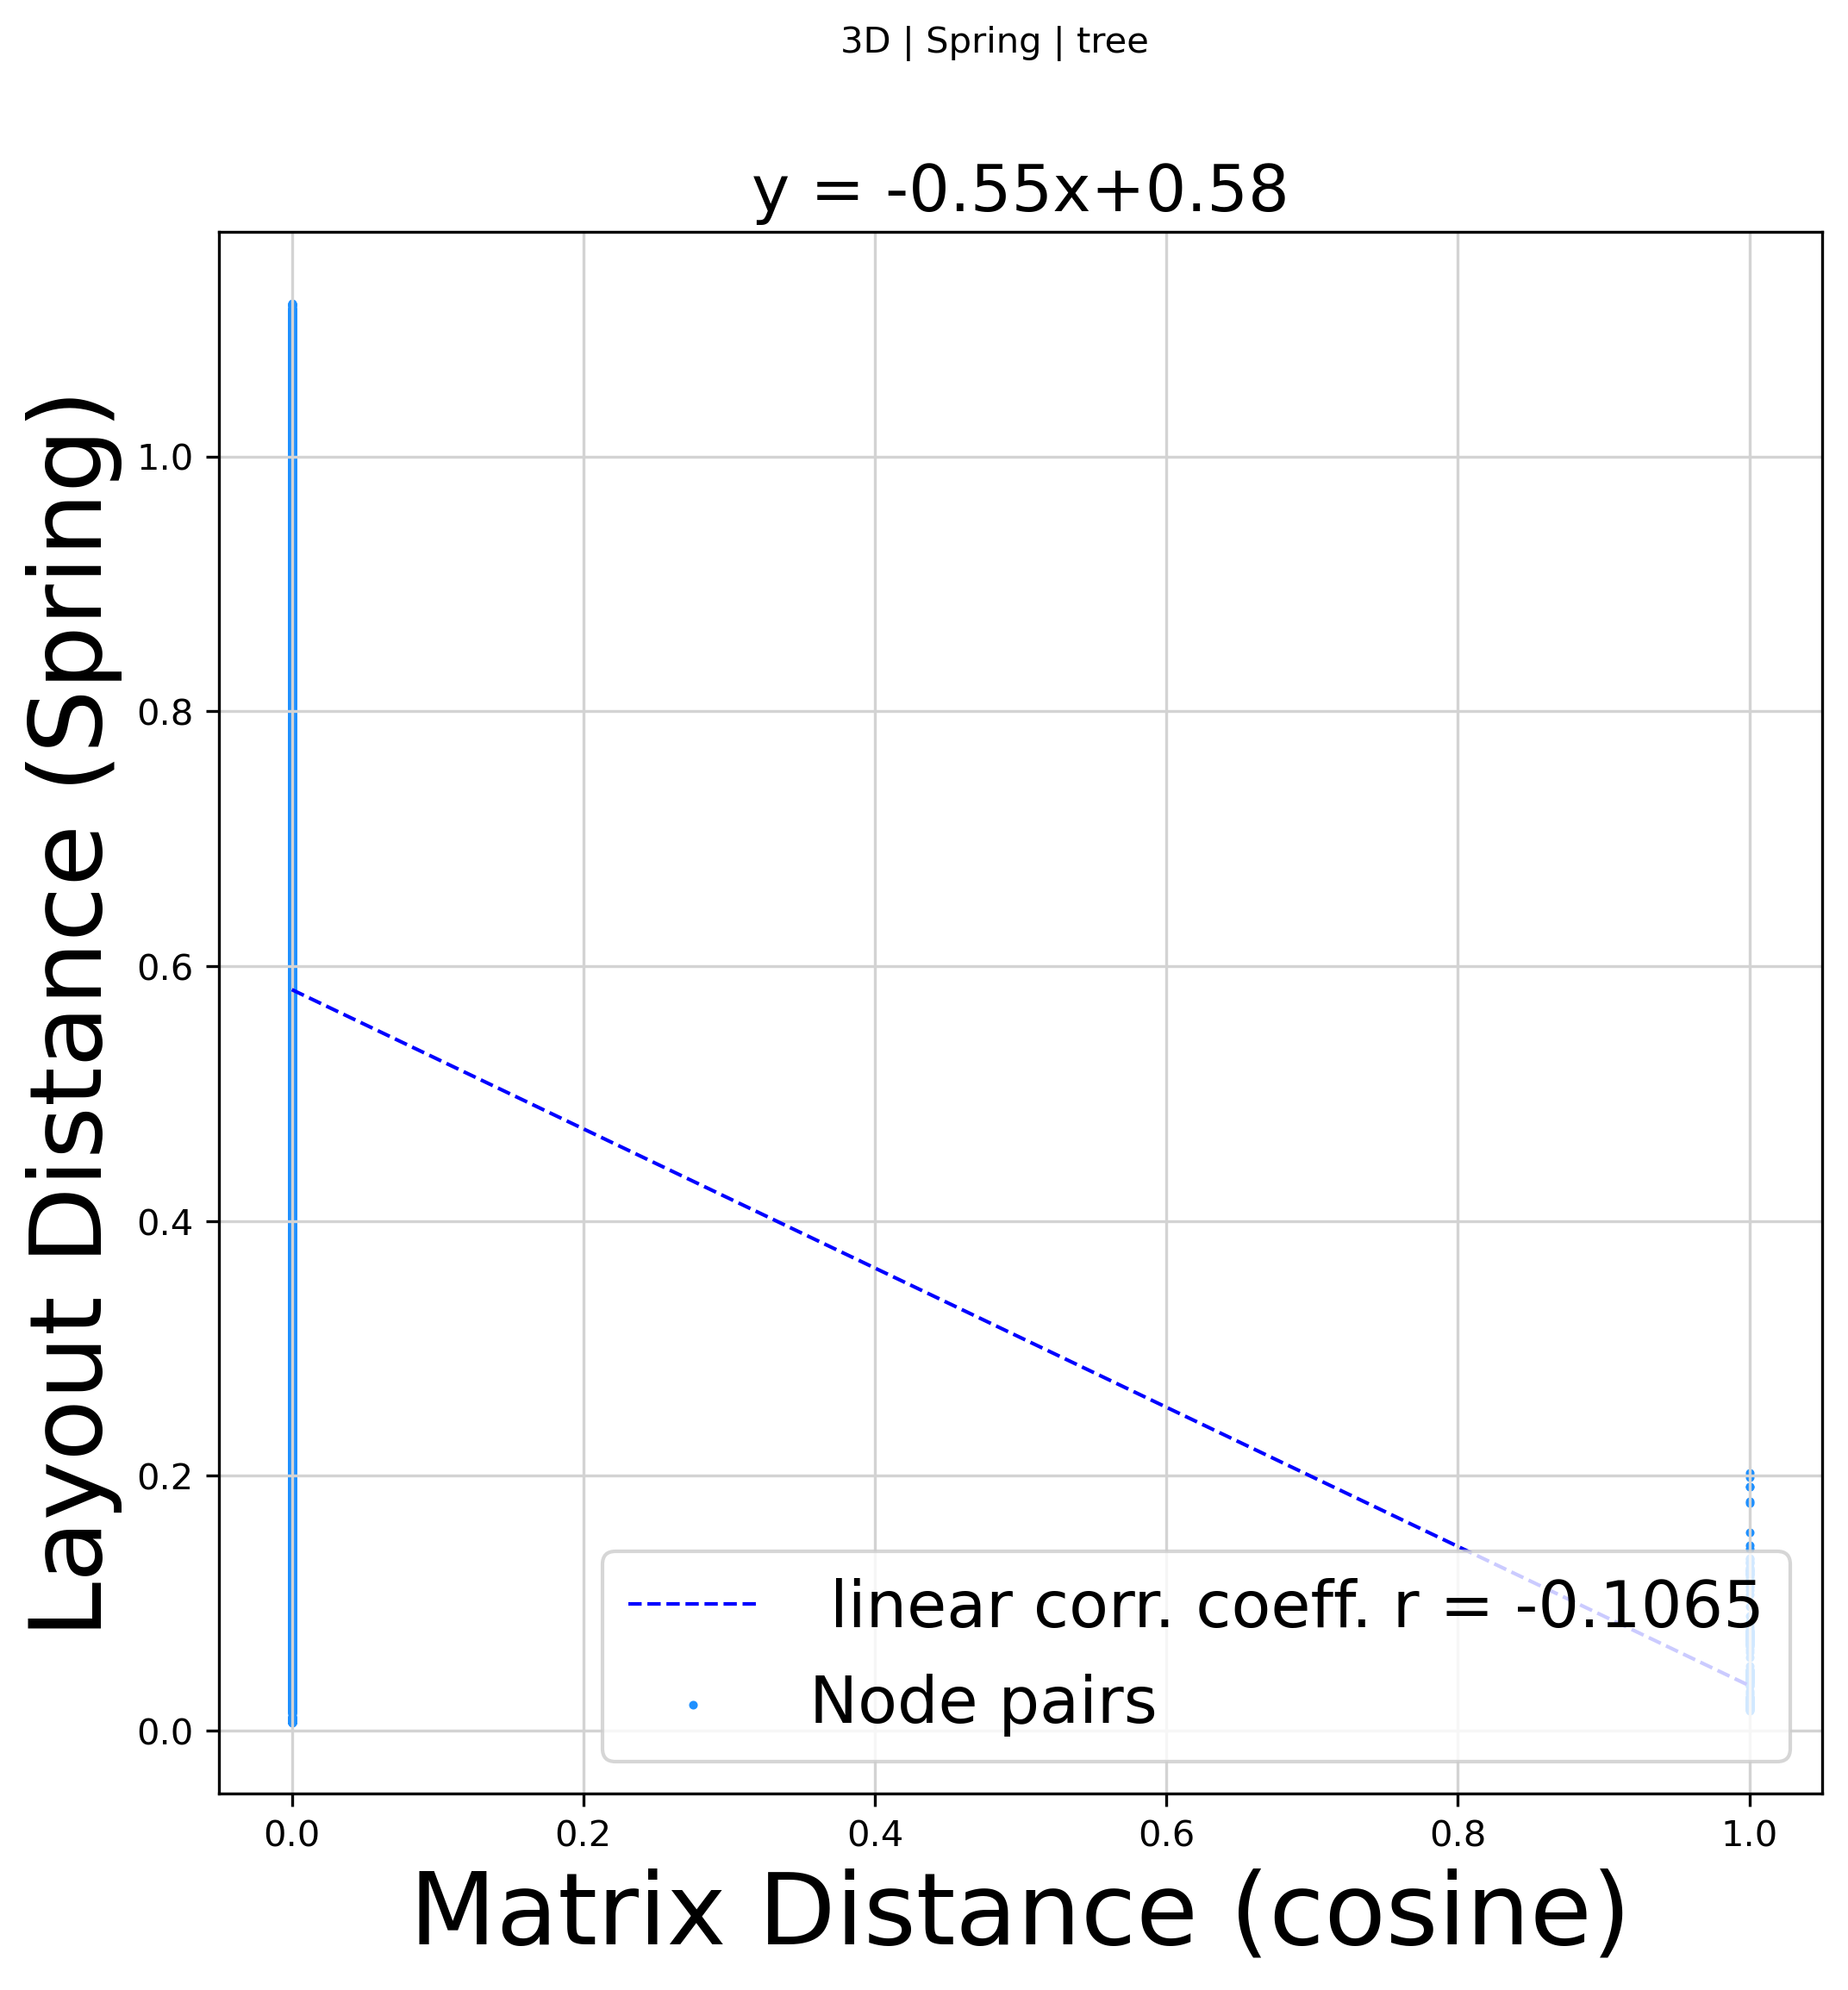

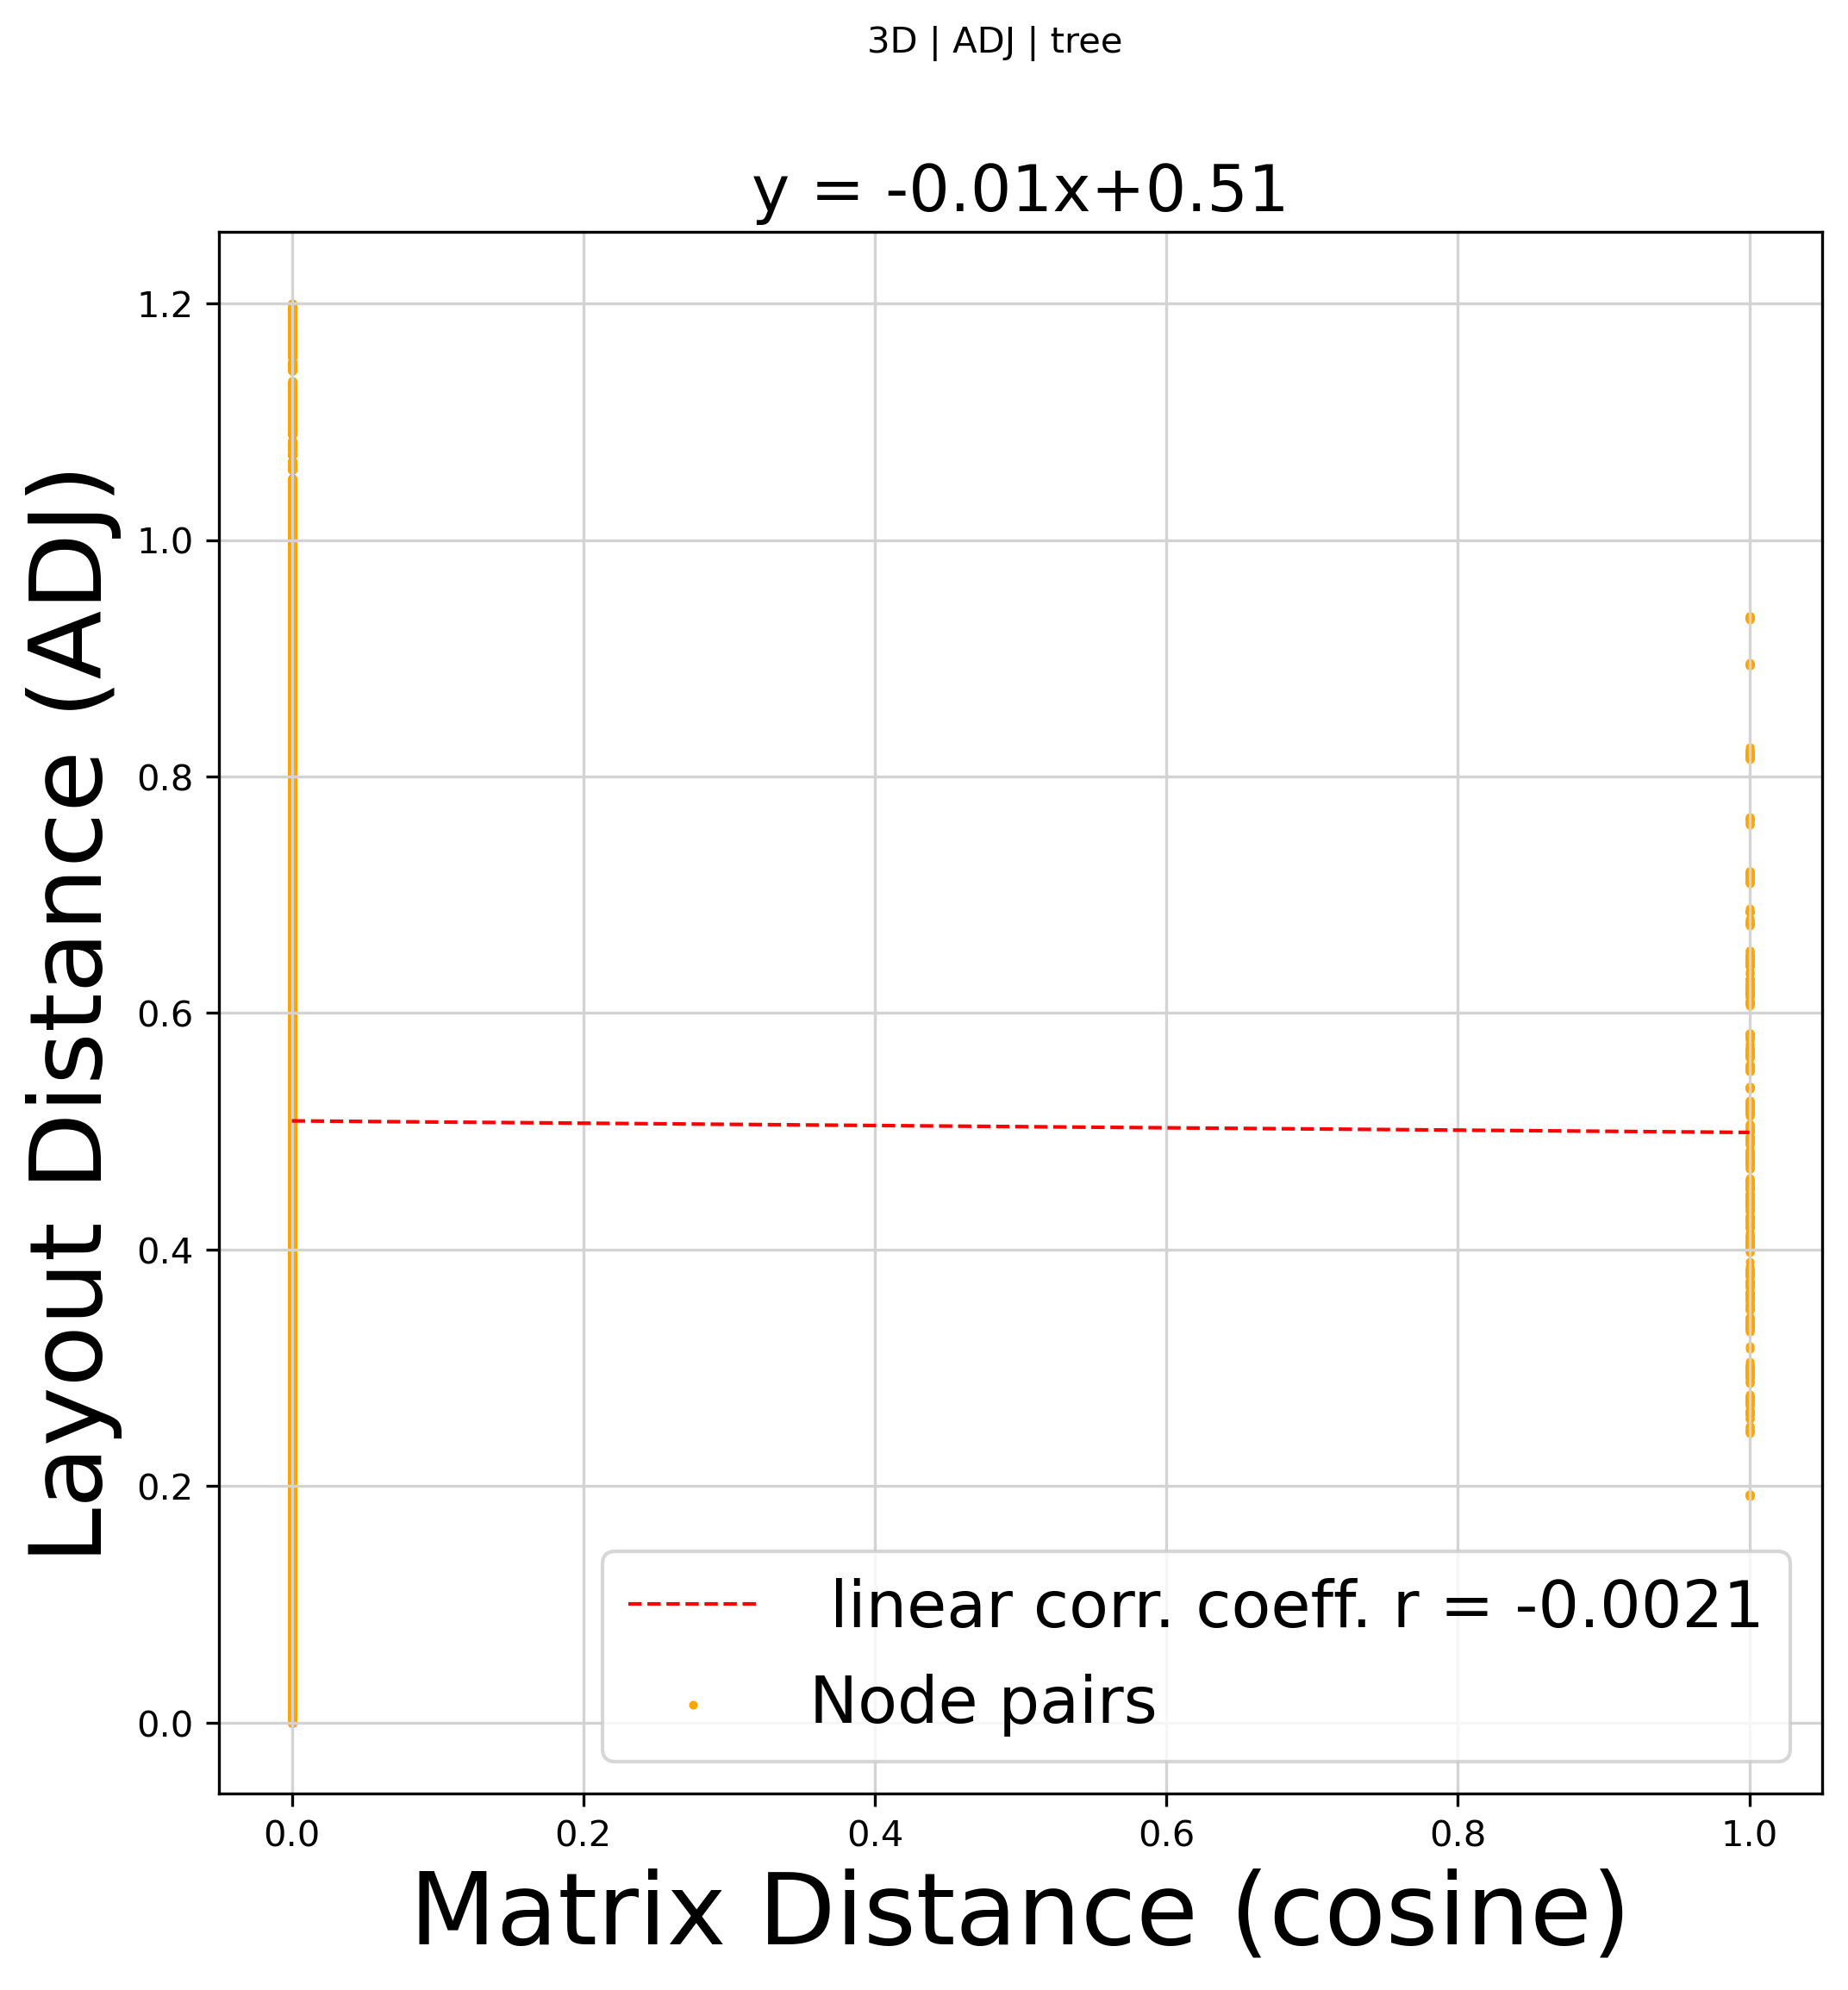

In [275]:
DM = df_adj
feature = 'ADJ'

posG_3D_complete_umap = posG_3D_complete_umap_adj_norm 
posG_spring3D = posG_spring3D_norm


from itertools import combinations
dist_spring3D = dict()
for (id1,p1),(id2,p2) in combinations(posG_spring3D.items(),2):
    dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
    dist_spring3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)
    

from itertools import combinations
dist_layout3D = dict()
for (id1,p1),(id2,p2) in combinations(posG_3D_complete_umap.items(),2):
    dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
    dist_layout3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)
    

# ------------------------------------------------------------
# get squareform dataframes from distances

# SPRING
dist_spring_list = [dist[1] for dist in sorted(dist_spring3D.items())]
df_spring3D = pd.DataFrame(dist.squareform(dist_spring_list), index=DM.index, columns=DM.columns)

# LAYOUT
dist_layout_list = [dist[1] for dist in sorted(dist_layout3D.items())]
df_layout3D = pd.DataFrame(dist.squareform(dist_layout_list), index=DM.index, columns=DM.columns)


# ------------------------------------------------------------
# remove all diagonal 0 values and values underneath diagonale (i.e. mirrored data)

# INITIAL DM
m,n = DM.shape
DM_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,DM))

# SPRING
m,n = df_spring3D.shape
df_spring3D_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,df_spring3D))

# LAYOUT
m,n = df_layout3D.shape
df_layout3D_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,df_layout3D))


# ------------------------------------------------------------
# values of Dataframe into flattened list for Regression line

# INITIAL DM 
l_DM = []
for i in range(len(DM_mod)):
    l_DM.append(DM.iloc[i:i+1].values)

l_DM_un = list(it.chain(*l_DM))
l_DM_flattened = list(it.chain(*l_DM_un))


# SPRING 
l_spring3D = []
for i in range(len(df_spring3D_mod)):
    l_spring3D.append(df_spring3D.iloc[i:i+1].values)

l_spring3D_un = list(it.chain(*l_spring3D))
l_spring3D_flattened = list(it.chain(*l_spring3D_un))


# LAYOUT
l_layout3D = []
for i in range(len(df_layout3D_mod)):
    l_layout3D.append(df_layout3D.iloc[i:i+1].values)

l_layout3D_un = list(it.chain(*l_layout3D))
l_layout3D_flattened = list(it.chain(*l_layout3D_un))


# ------------------------------------------------------------
# PLOT SPRING
# ------------------------------------------------------------

fig = plt.figure(figsize=(8,8), dpi=300)
plt.grid(True, c='lightgrey')

y_spring3D = df_spring3D_mod
x_spring3D = DM_mod
plt.scatter(x_spring3D,y_spring3D, c = 'dodgerblue', s = 2)

# REGRESSION LINE 
y_regr_spring3D = l_spring3D_flattened
x_regr_spring3D = l_DM_flattened
gradient_spring3D, intercept_spring3D, r_value_spring3D, p_value_spring3D, std_err_spring3D = stats.linregress(x_regr_spring3D,y_regr_spring3D)
mn_spring3D=np.min(x_regr_spring3D)
mx_spring3D=np.max(x_regr_spring3D)
x1_spring3D=np.linspace(mn_spring3D,mx_spring3D,500)
line_spring3D =gradient_spring3D*x1_spring3D+intercept_spring3D
plt.plot(x1_spring3D,line_spring3D,'--b',linewidth=1.0)

plt.ylabel("Layout Distance (Spring)", fontsize=labelsize)
plt.xlabel("Matrix Distance "+"("+metric+")", fontsize=labelsize )

plt.legend((' linear corr. coeff. r = {}'.format(round(r_value_spring3D,4)),'Node pairs'), loc='lower right', fontsize=legendfontsize)

plt.suptitle('3D | Spring | '+organism, fontsize=10)
plt.title('y = {:.2f}x+{:.2f}'.format(gradient_spring3D,intercept_spring3D), fontsize=legendfontsize)

fig.savefig('output_plots/3Dtoynetwork_CorrDiagramSPRING_'+feature+'_'+organism+'.png')



# ------------------------------------------------------------
# PLOT LAYOUT
# ------------------------------------------------------------

fig = plt.figure(figsize=(8,8), dpi=300)
plt.grid(True, c='lightgrey')

y_layout3D = df_layout3D_mod
x_layout3D = DM_mod
plt.scatter(x_layout3D,y_layout3D, c = 'orange', s = 2)

# REGRESSION LINE 
y_regr_layout3D = l_layout3D_flattened
x_regr_layout3D = l_DM_flattened
gradient_layout3D, intercept_layout3D, r_value_layout3D, p_value_layout3D, std_err_layout3D = stats.linregress(x_regr_layout3D,y_regr_layout3D)
mn_layout3D=np.min(x_regr_layout3D)
mx_layout3D=np.max(x_regr_layout3D)
x1_layout3D=np.linspace(mn_layout3D,mx_layout3D,500)
line_layout3D = gradient_layout3D*x1_layout3D+intercept_layout3D
plt.plot(x1_layout3D,line_layout3D,'--r',linewidth=1.0)

plt.ylabel("Layout Distance "+"("+feature+")", fontsize=labelsize )
plt.xlabel("Matrix Distance "+"("+metric+")", fontsize=labelsize )

plt.legend((' linear corr. coeff. r = {}'.format(round(r_value_layout3D,4)),'Node pairs'), loc='lower right', fontsize=legendfontsize)

plt.suptitle('3D | '+feature+' | '+organism, fontsize=10)
plt.title('y = {:.2f}x+{:.2f}'.format(gradient_layout3D,intercept_layout3D), fontsize=legendfontsize)

fig.savefig('output_plots/3Dtoynetwork_CorrDiagramLAYOUT_'+feature+'_'+organism+'.png')

+ RANDOM WALK 

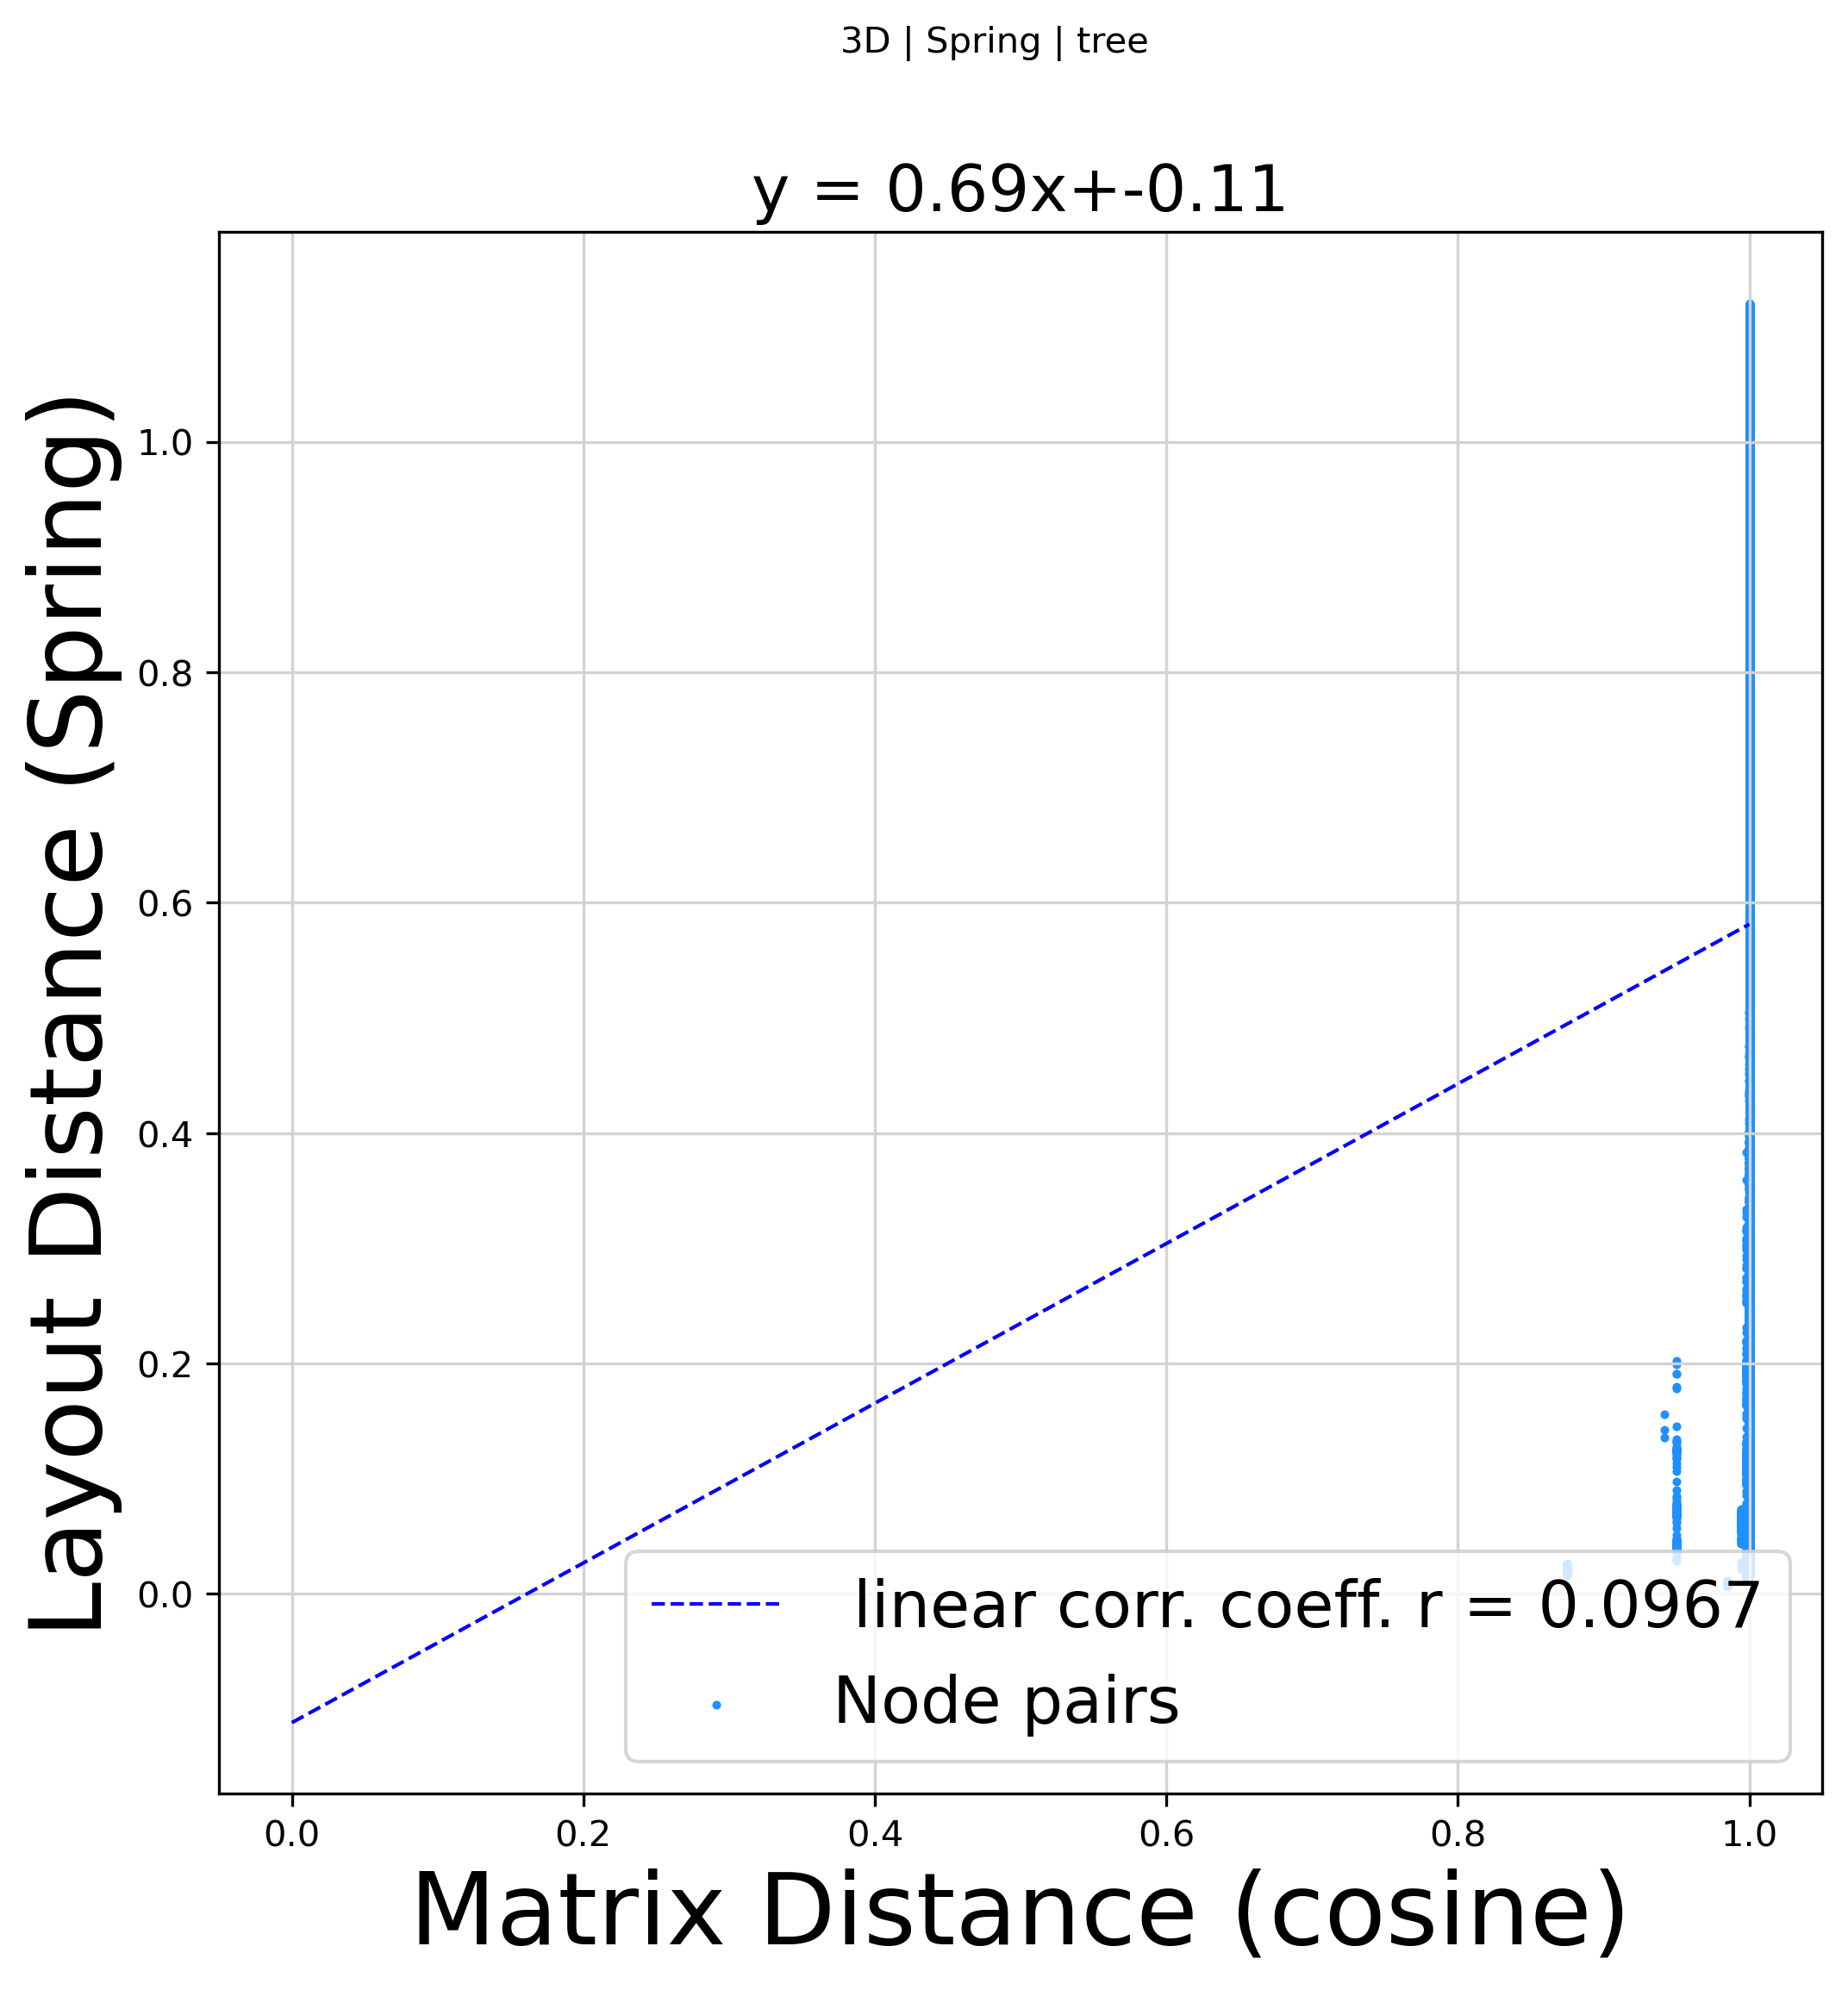

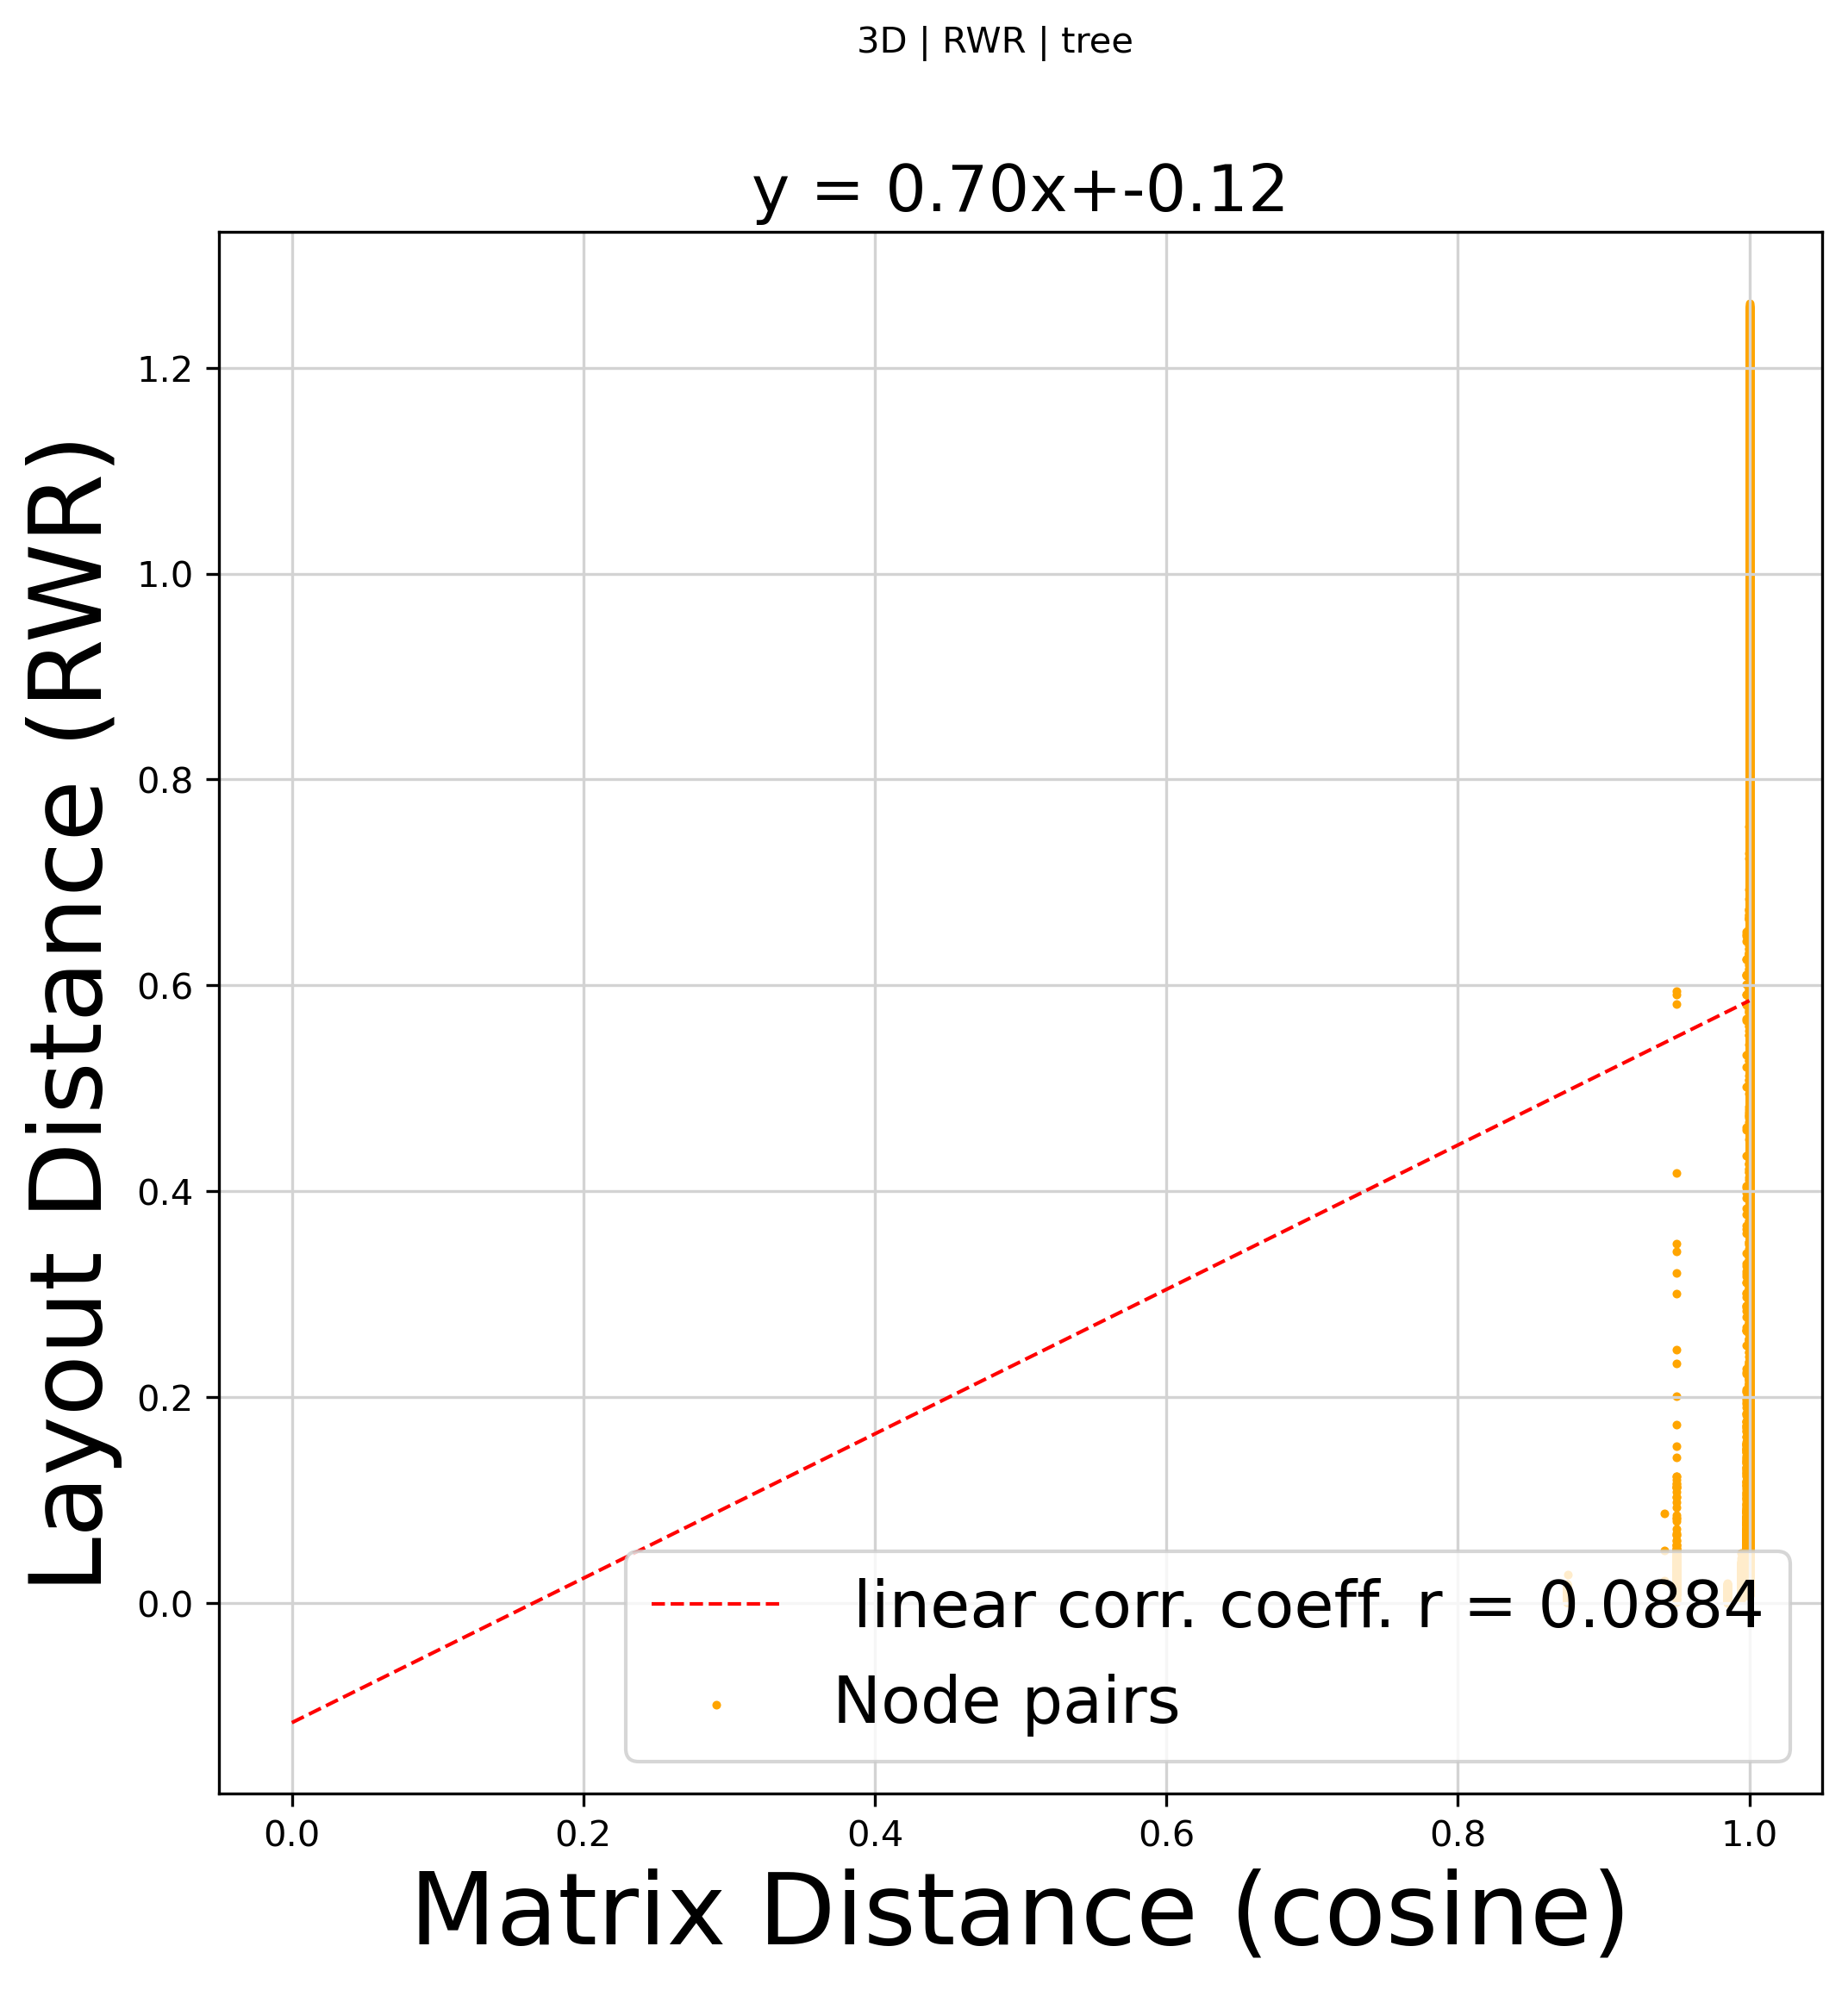

In [276]:
DM = DM_m
feature = 'RWR'

posG_3D_complete_umap = posG_3D_complete_umap_rwr_norm 
posG_spring3D = posG_spring3D_norm


from itertools import combinations
dist_spring3D = dict()
for (id1,p1),(id2,p2) in combinations(posG_spring3D.items(),2):
    dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
    dist_spring3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)
    

from itertools import combinations
dist_layout3D = dict()
for (id1,p1),(id2,p2) in combinations(posG_3D_complete_umap.items(),2):
    dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
    dist_layout3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)
    

# ------------------------------------------------------------
# get squareform dataframes from distances

# SPRING
dist_spring_list = [dist[1] for dist in sorted(dist_spring3D.items())]
df_spring3D = pd.DataFrame(dist.squareform(dist_spring_list), index=DM.index, columns=DM.columns)

# LAYOUT
dist_layout_list = [dist[1] for dist in sorted(dist_layout3D.items())]
df_layout3D = pd.DataFrame(dist.squareform(dist_layout_list), index=DM.index, columns=DM.columns)


# ------------------------------------------------------------
# remove all diagonal 0 values and values underneath diagonale (i.e. mirrored data)

# INITIAL DM
m,n = DM.shape
DM_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,DM))

# SPRING
m,n = df_spring3D.shape
df_spring3D_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,df_spring3D))

# LAYOUT
m,n = df_layout3D.shape
df_layout3D_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,df_layout3D))


# ------------------------------------------------------------
# values of Dataframe into flattened list for Regression line

# INITIAL DM 
l_DM = []
for i in range(len(DM_mod)):
    l_DM.append(DM.iloc[i:i+1].values)

l_DM_un = list(it.chain(*l_DM))
l_DM_flattened = list(it.chain(*l_DM_un))


# SPRING 
l_spring3D = []
for i in range(len(df_spring3D_mod)):
    l_spring3D.append(df_spring3D.iloc[i:i+1].values)

l_spring3D_un = list(it.chain(*l_spring3D))
l_spring3D_flattened = list(it.chain(*l_spring3D_un))


# LAYOUT
l_layout3D = []
for i in range(len(df_layout3D_mod)):
    l_layout3D.append(df_layout3D.iloc[i:i+1].values)

l_layout3D_un = list(it.chain(*l_layout3D))
l_layout3D_flattened = list(it.chain(*l_layout3D_un))


# ------------------------------------------------------------
# PLOT SPRING
# ------------------------------------------------------------

fig = plt.figure(figsize=(8,8), dpi=300)
plt.grid(True, c='lightgrey')

y_spring3D = df_spring3D_mod
x_spring3D = DM_mod
plt.scatter(x_spring3D,y_spring3D, c = 'dodgerblue', s = 2)

# REGRESSION LINE 
y_regr_spring3D = l_spring3D_flattened
x_regr_spring3D = l_DM_flattened
gradient_spring3D, intercept_spring3D, r_value_spring3D, p_value_spring3D, std_err_spring3D = stats.linregress(x_regr_spring3D,y_regr_spring3D)
mn_spring3D=np.min(x_regr_spring3D)
mx_spring3D=np.max(x_regr_spring3D)
x1_spring3D=np.linspace(mn_spring3D,mx_spring3D,500)
line_spring3D =gradient_spring3D*x1_spring3D+intercept_spring3D
plt.plot(x1_spring3D,line_spring3D,'--b',linewidth=1.0)

plt.ylabel("Layout Distance (Spring)", fontsize=labelsize)
plt.xlabel("Matrix Distance "+"("+metric+")", fontsize=labelsize )

plt.legend((' linear corr. coeff. r = {}'.format(round(r_value_spring3D,4)),'Node pairs'), loc='lower right', fontsize=legendfontsize)

plt.suptitle('3D | Spring | '+organism, fontsize=10)
plt.title('y = {:.2f}x+{:.2f}'.format(gradient_spring3D,intercept_spring3D), fontsize=legendfontsize)

fig.savefig('output_plots/3Dtoynetwork_CorrDiagramSPRING_'+feature+'_'+organism+'.png')



# ------------------------------------------------------------
# PLOT LAYOUT
# ------------------------------------------------------------

fig = plt.figure(figsize=(8,8), dpi=300)
plt.grid(True, c='lightgrey')

y_layout3D = df_layout3D_mod
x_layout3D = DM_mod
plt.scatter(x_layout3D,y_layout3D, c = 'orange', s = 2)

# REGRESSION LINE 
y_regr_layout3D = l_layout3D_flattened
x_regr_layout3D = l_DM_flattened
gradient_layout3D, intercept_layout3D, r_value_layout3D, p_value_layout3D, std_err_layout3D = stats.linregress(x_regr_layout3D,y_regr_layout3D)
mn_layout3D=np.min(x_regr_layout3D)
mx_layout3D=np.max(x_regr_layout3D)
x1_layout3D=np.linspace(mn_layout3D,mx_layout3D,500)
line_layout3D = gradient_layout3D*x1_layout3D+intercept_layout3D
plt.plot(x1_layout3D,line_layout3D,'--r',linewidth=1.0)

plt.ylabel("Layout Distance "+"("+feature+")", fontsize=labelsize )
plt.xlabel("Matrix Distance "+"("+metric+")", fontsize=labelsize )

plt.legend((' linear corr. coeff. r = {}'.format(round(r_value_layout3D,4)),'Node pairs'), loc='lower right', fontsize=legendfontsize)

plt.suptitle('3D | '+feature+' | '+organism, fontsize=10)
plt.title('y = {:.2f}x+{:.2f}'.format(gradient_layout3D,intercept_layout3D), fontsize=legendfontsize)

fig.savefig('output_plots/3Dtoynetwork_CorrDiagramLAYOUT_'+feature+'_'+organism+'.png')

+ CENTRALITIES

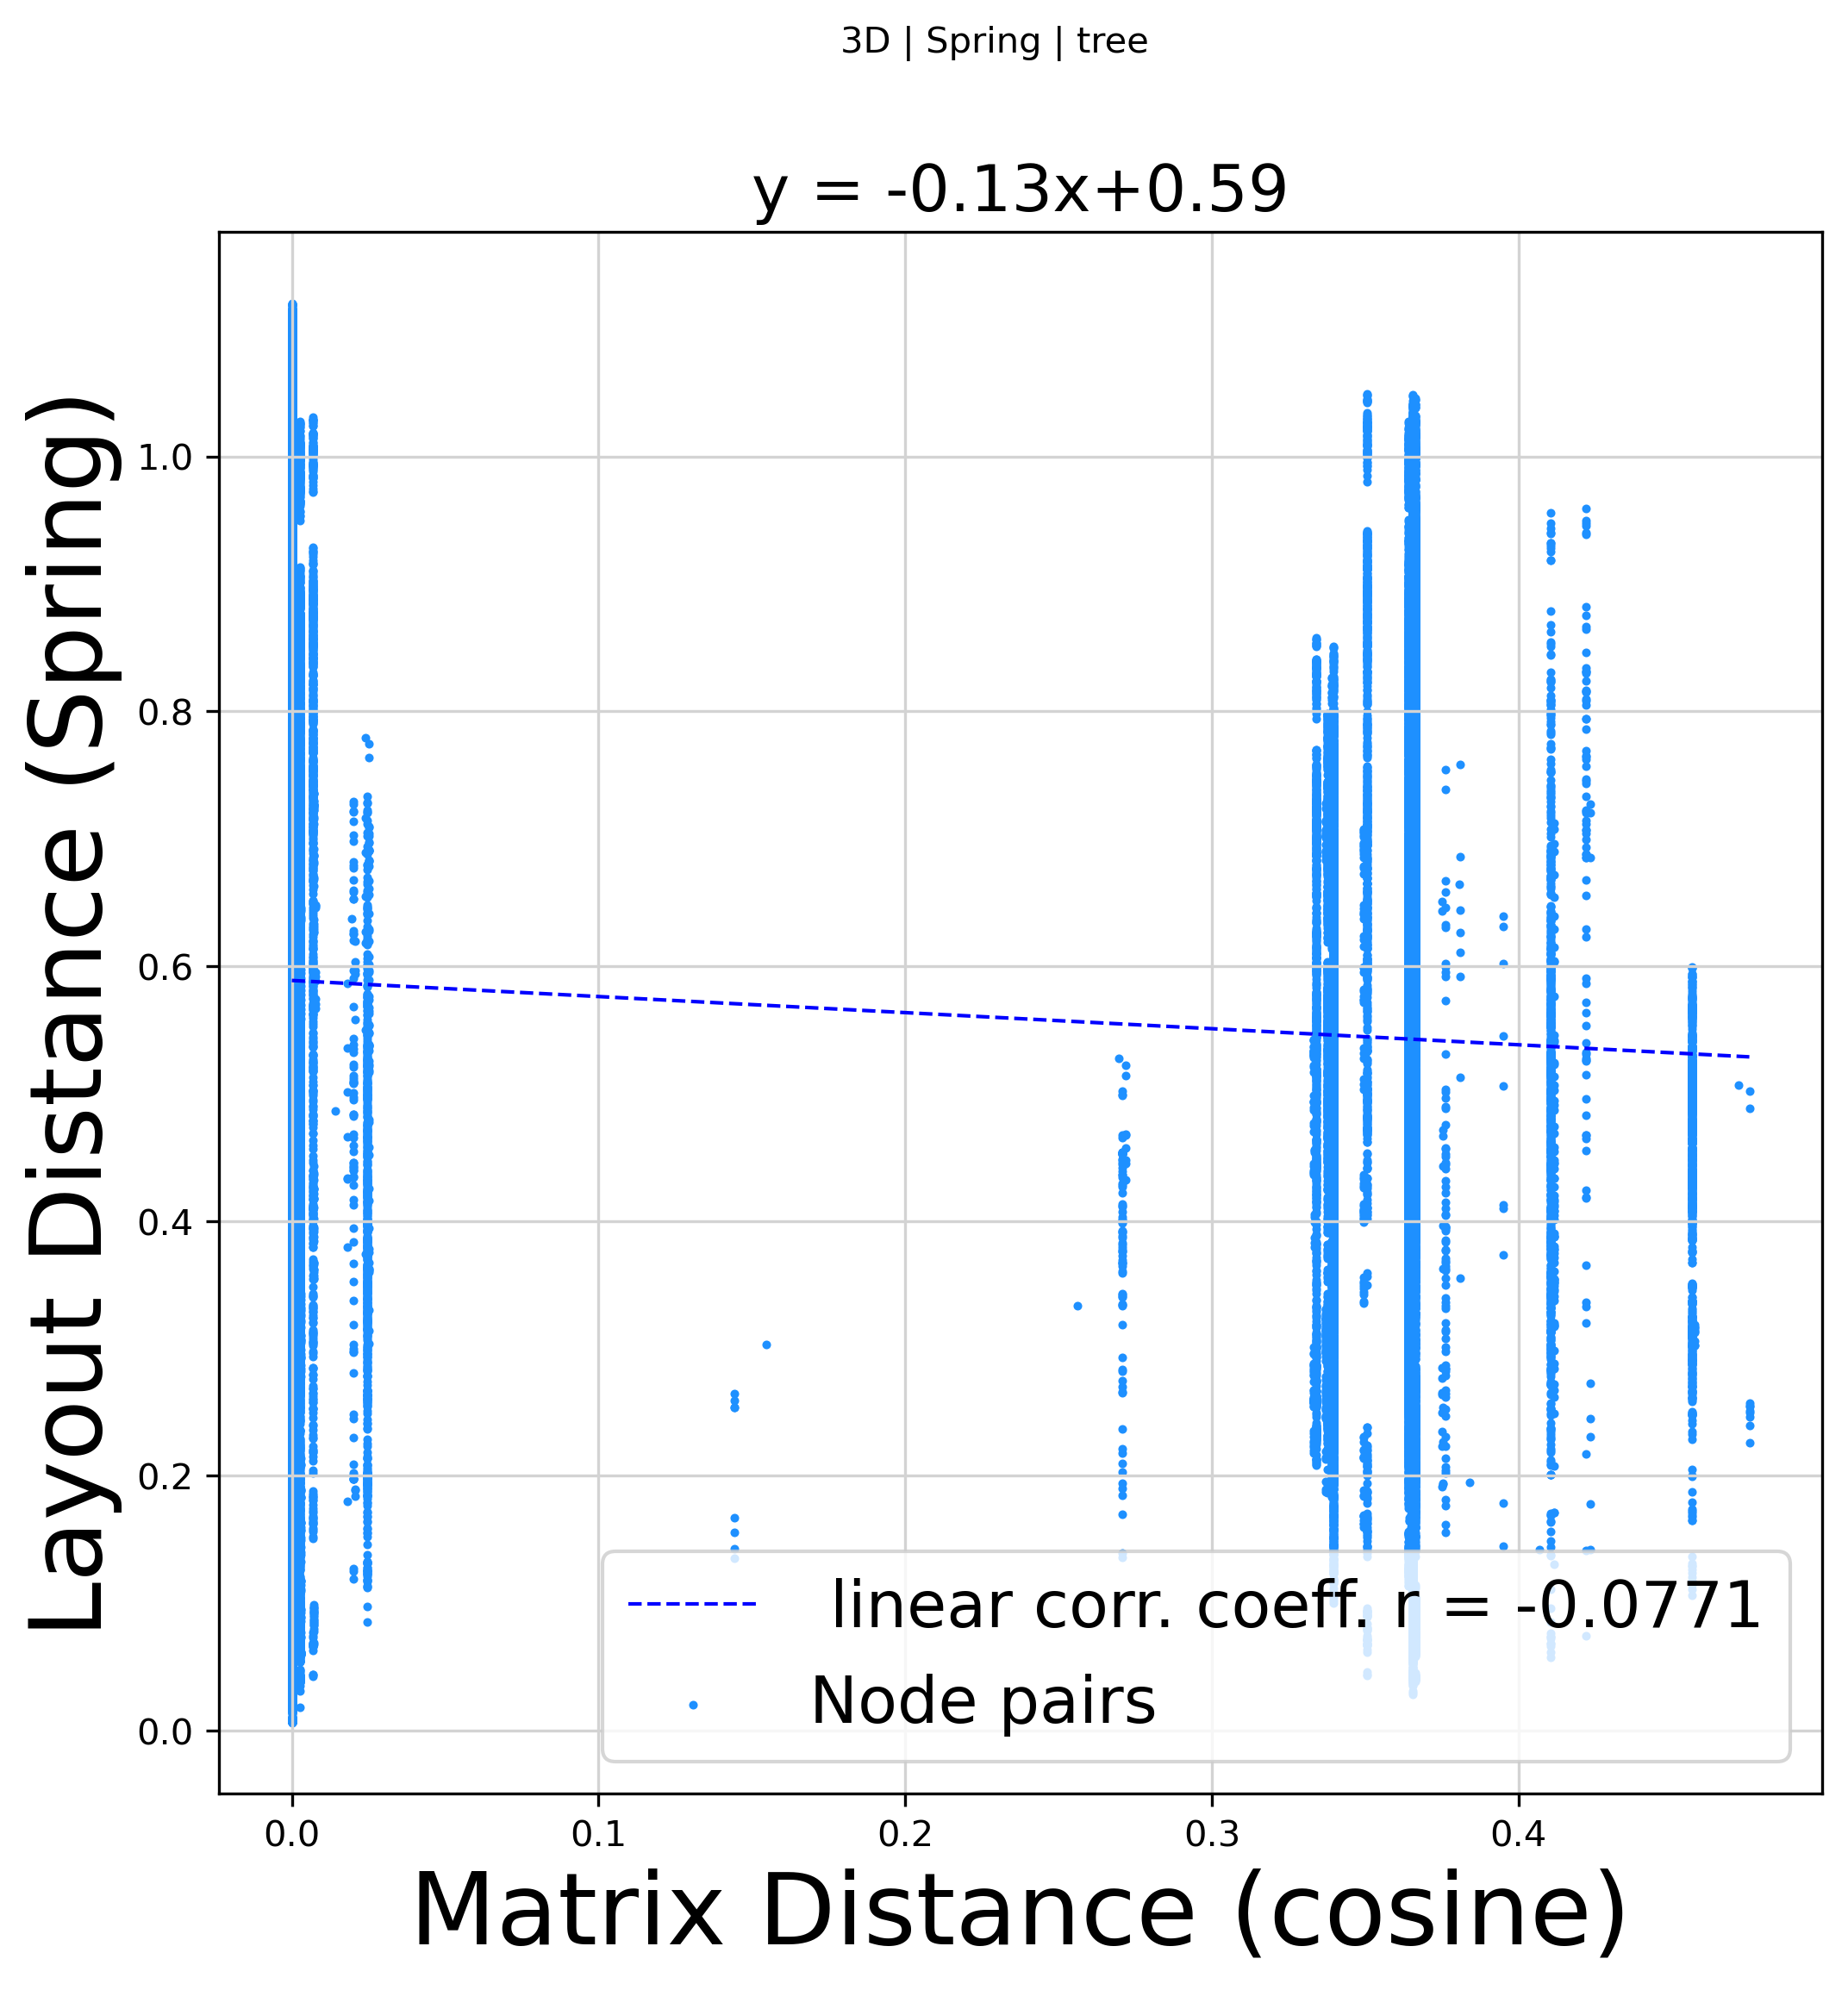

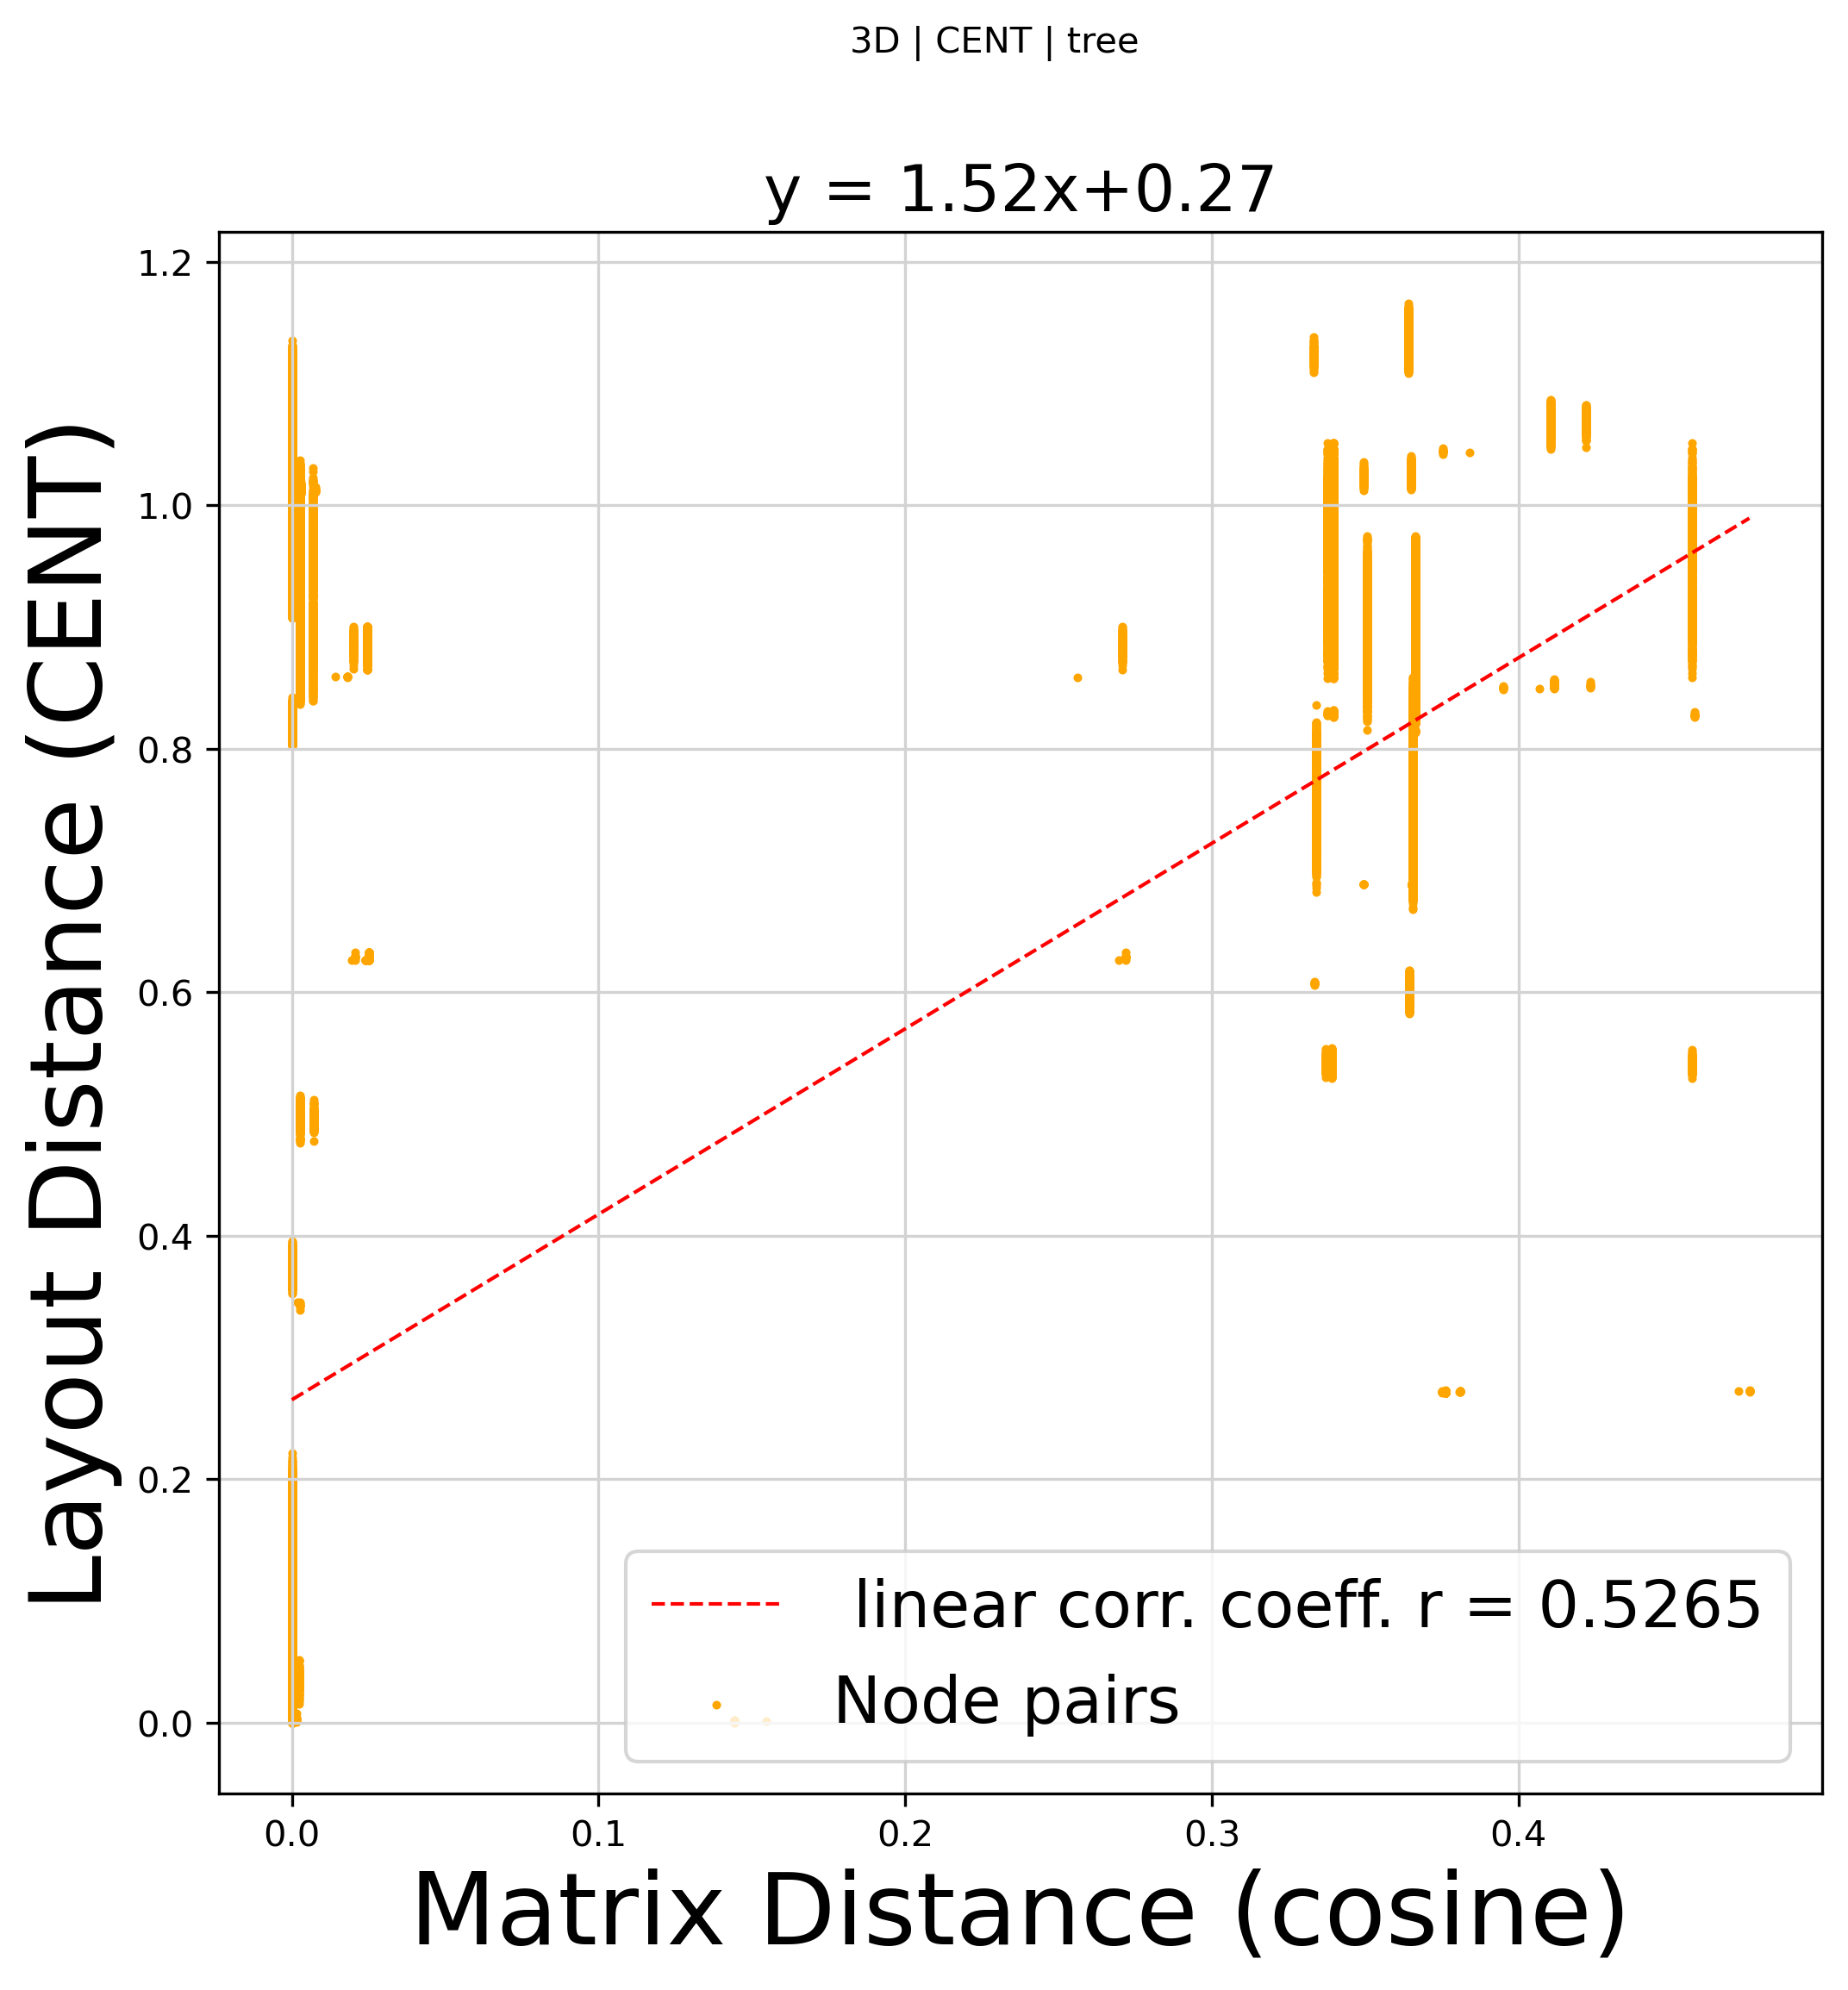

In [278]:
DM = DM_cent
feature = 'CENT'

posG_3D_complete_umap = posG_3D_complete_umap_cent_norm 
posG_spring3D = posG_spring3D_norm


from itertools import combinations
dist_spring3D = dict()
for (id1,p1),(id2,p2) in combinations(posG_spring3D.items(),2):
    dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
    dist_spring3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)
    

from itertools import combinations
dist_layout3D = dict()
for (id1,p1),(id2,p2) in combinations(posG_3D_complete_umap.items(),2):
    dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
    dist_layout3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)
    

# ------------------------------------------------------------
# get squareform dataframes from distances

# SPRING
dist_spring_list = [dist[1] for dist in sorted(dist_spring3D.items())]
df_spring3D = pd.DataFrame(dist.squareform(dist_spring_list), index=DM.index, columns=DM.columns)

# LAYOUT
dist_layout_list = [dist[1] for dist in sorted(dist_layout3D.items())]
df_layout3D = pd.DataFrame(dist.squareform(dist_layout_list), index=DM.index, columns=DM.columns)


# ------------------------------------------------------------
# remove all diagonal 0 values and values underneath diagonale (i.e. mirrored data)

# INITIAL DM
m,n = DM.shape
DM_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,DM))

# SPRING
m,n = df_spring3D.shape
df_spring3D_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,df_spring3D))

# LAYOUT
m,n = df_layout3D.shape
df_layout3D_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,df_layout3D))


# ------------------------------------------------------------
# values of Dataframe into flattened list for Regression line

# INITIAL DM 
l_DM = []
for i in range(len(DM_mod)):
    l_DM.append(DM.iloc[i:i+1].values)

l_DM_un = list(it.chain(*l_DM))
l_DM_flattened = list(it.chain(*l_DM_un))


# SPRING 
l_spring3D = []
for i in range(len(df_spring3D_mod)):
    l_spring3D.append(df_spring3D.iloc[i:i+1].values)

l_spring3D_un = list(it.chain(*l_spring3D))
l_spring3D_flattened = list(it.chain(*l_spring3D_un))


# LAYOUT
l_layout3D = []
for i in range(len(df_layout3D_mod)):
    l_layout3D.append(df_layout3D.iloc[i:i+1].values)

l_layout3D_un = list(it.chain(*l_layout3D))
l_layout3D_flattened = list(it.chain(*l_layout3D_un))


# ------------------------------------------------------------
# PLOT SPRING
# ------------------------------------------------------------

fig = plt.figure(figsize=(8,8), dpi=300)
plt.grid(True, c='lightgrey')

y_spring3D = df_spring3D_mod
x_spring3D = DM_mod
plt.scatter(x_spring3D,y_spring3D, c = 'dodgerblue', s = 2)

# REGRESSION LINE 
y_regr_spring3D = l_spring3D_flattened
x_regr_spring3D = l_DM_flattened
gradient_spring3D, intercept_spring3D, r_value_spring3D, p_value_spring3D, std_err_spring3D = stats.linregress(x_regr_spring3D,y_regr_spring3D)
mn_spring3D=np.min(x_regr_spring3D)
mx_spring3D=np.max(x_regr_spring3D)
x1_spring3D=np.linspace(mn_spring3D,mx_spring3D,500)
line_spring3D =gradient_spring3D*x1_spring3D+intercept_spring3D
plt.plot(x1_spring3D,line_spring3D,'--b',linewidth=1.0)

plt.ylabel("Layout Distance (Spring)", fontsize=labelsize)
plt.xlabel("Matrix Distance "+"("+metric+")", fontsize=labelsize )

plt.legend((' linear corr. coeff. r = {}'.format(round(r_value_spring3D,4)),'Node pairs'), loc='lower right', fontsize=legendfontsize)

plt.suptitle('3D | Spring | '+organism, fontsize=10)
plt.title('y = {:.2f}x+{:.2f}'.format(gradient_spring3D,intercept_spring3D), fontsize=legendfontsize)

fig.savefig('output_plots/3Dtoynetwork_CorrDiagramSPRING_'+feature+'_'+organism+'.png')



# ------------------------------------------------------------
# PLOT LAYOUT
# ------------------------------------------------------------

fig = plt.figure(figsize=(8,8), dpi=300)
plt.grid(True, c='lightgrey')

y_layout3D = df_layout3D_mod
x_layout3D = DM_mod
plt.scatter(x_layout3D,y_layout3D, c = 'orange', s = 2)

# REGRESSION LINE 
y_regr_layout3D = l_layout3D_flattened
x_regr_layout3D = l_DM_flattened
gradient_layout3D, intercept_layout3D, r_value_layout3D, p_value_layout3D, std_err_layout3D = stats.linregress(x_regr_layout3D,y_regr_layout3D)
mn_layout3D=np.min(x_regr_layout3D)
mx_layout3D=np.max(x_regr_layout3D)
x1_layout3D=np.linspace(mn_layout3D,mx_layout3D,500)
line_layout3D = gradient_layout3D*x1_layout3D+intercept_layout3D
plt.plot(x1_layout3D,line_layout3D,'--r',linewidth=1.0)

plt.ylabel("Layout Distance "+"("+feature+")", fontsize=labelsize )
plt.xlabel("Matrix Distance "+"("+metric+")", fontsize=labelsize )

plt.legend((' linear corr. coeff. r = {}'.format(round(r_value_layout3D,4)),'Node pairs'), loc='lower right', fontsize=legendfontsize)

plt.suptitle('3D | '+feature+' | '+organism, fontsize=10)
plt.title('y = {:.2f}x+{:.2f}'.format(gradient_layout3D,intercept_layout3D), fontsize=legendfontsize)

fig.savefig('output_plots/3Dtoynetwork_CorrDiagramLAYOUT_'+feature+'_'+organism+'.png')

_________

# EVALUATION PART II - 3D
### Network Distance vs. Layout Distance 
+ Plots to compare Network Distances (i.e. SPL) with embedded Layout Distances 
+ X-axis = Reference axis i.e. Network Distance 
+ Y-axis = Layout Distance 

## 3D layouts Correlation diagrams (NETWORK DISTANCE vs. LAYOUT DISTANCE)

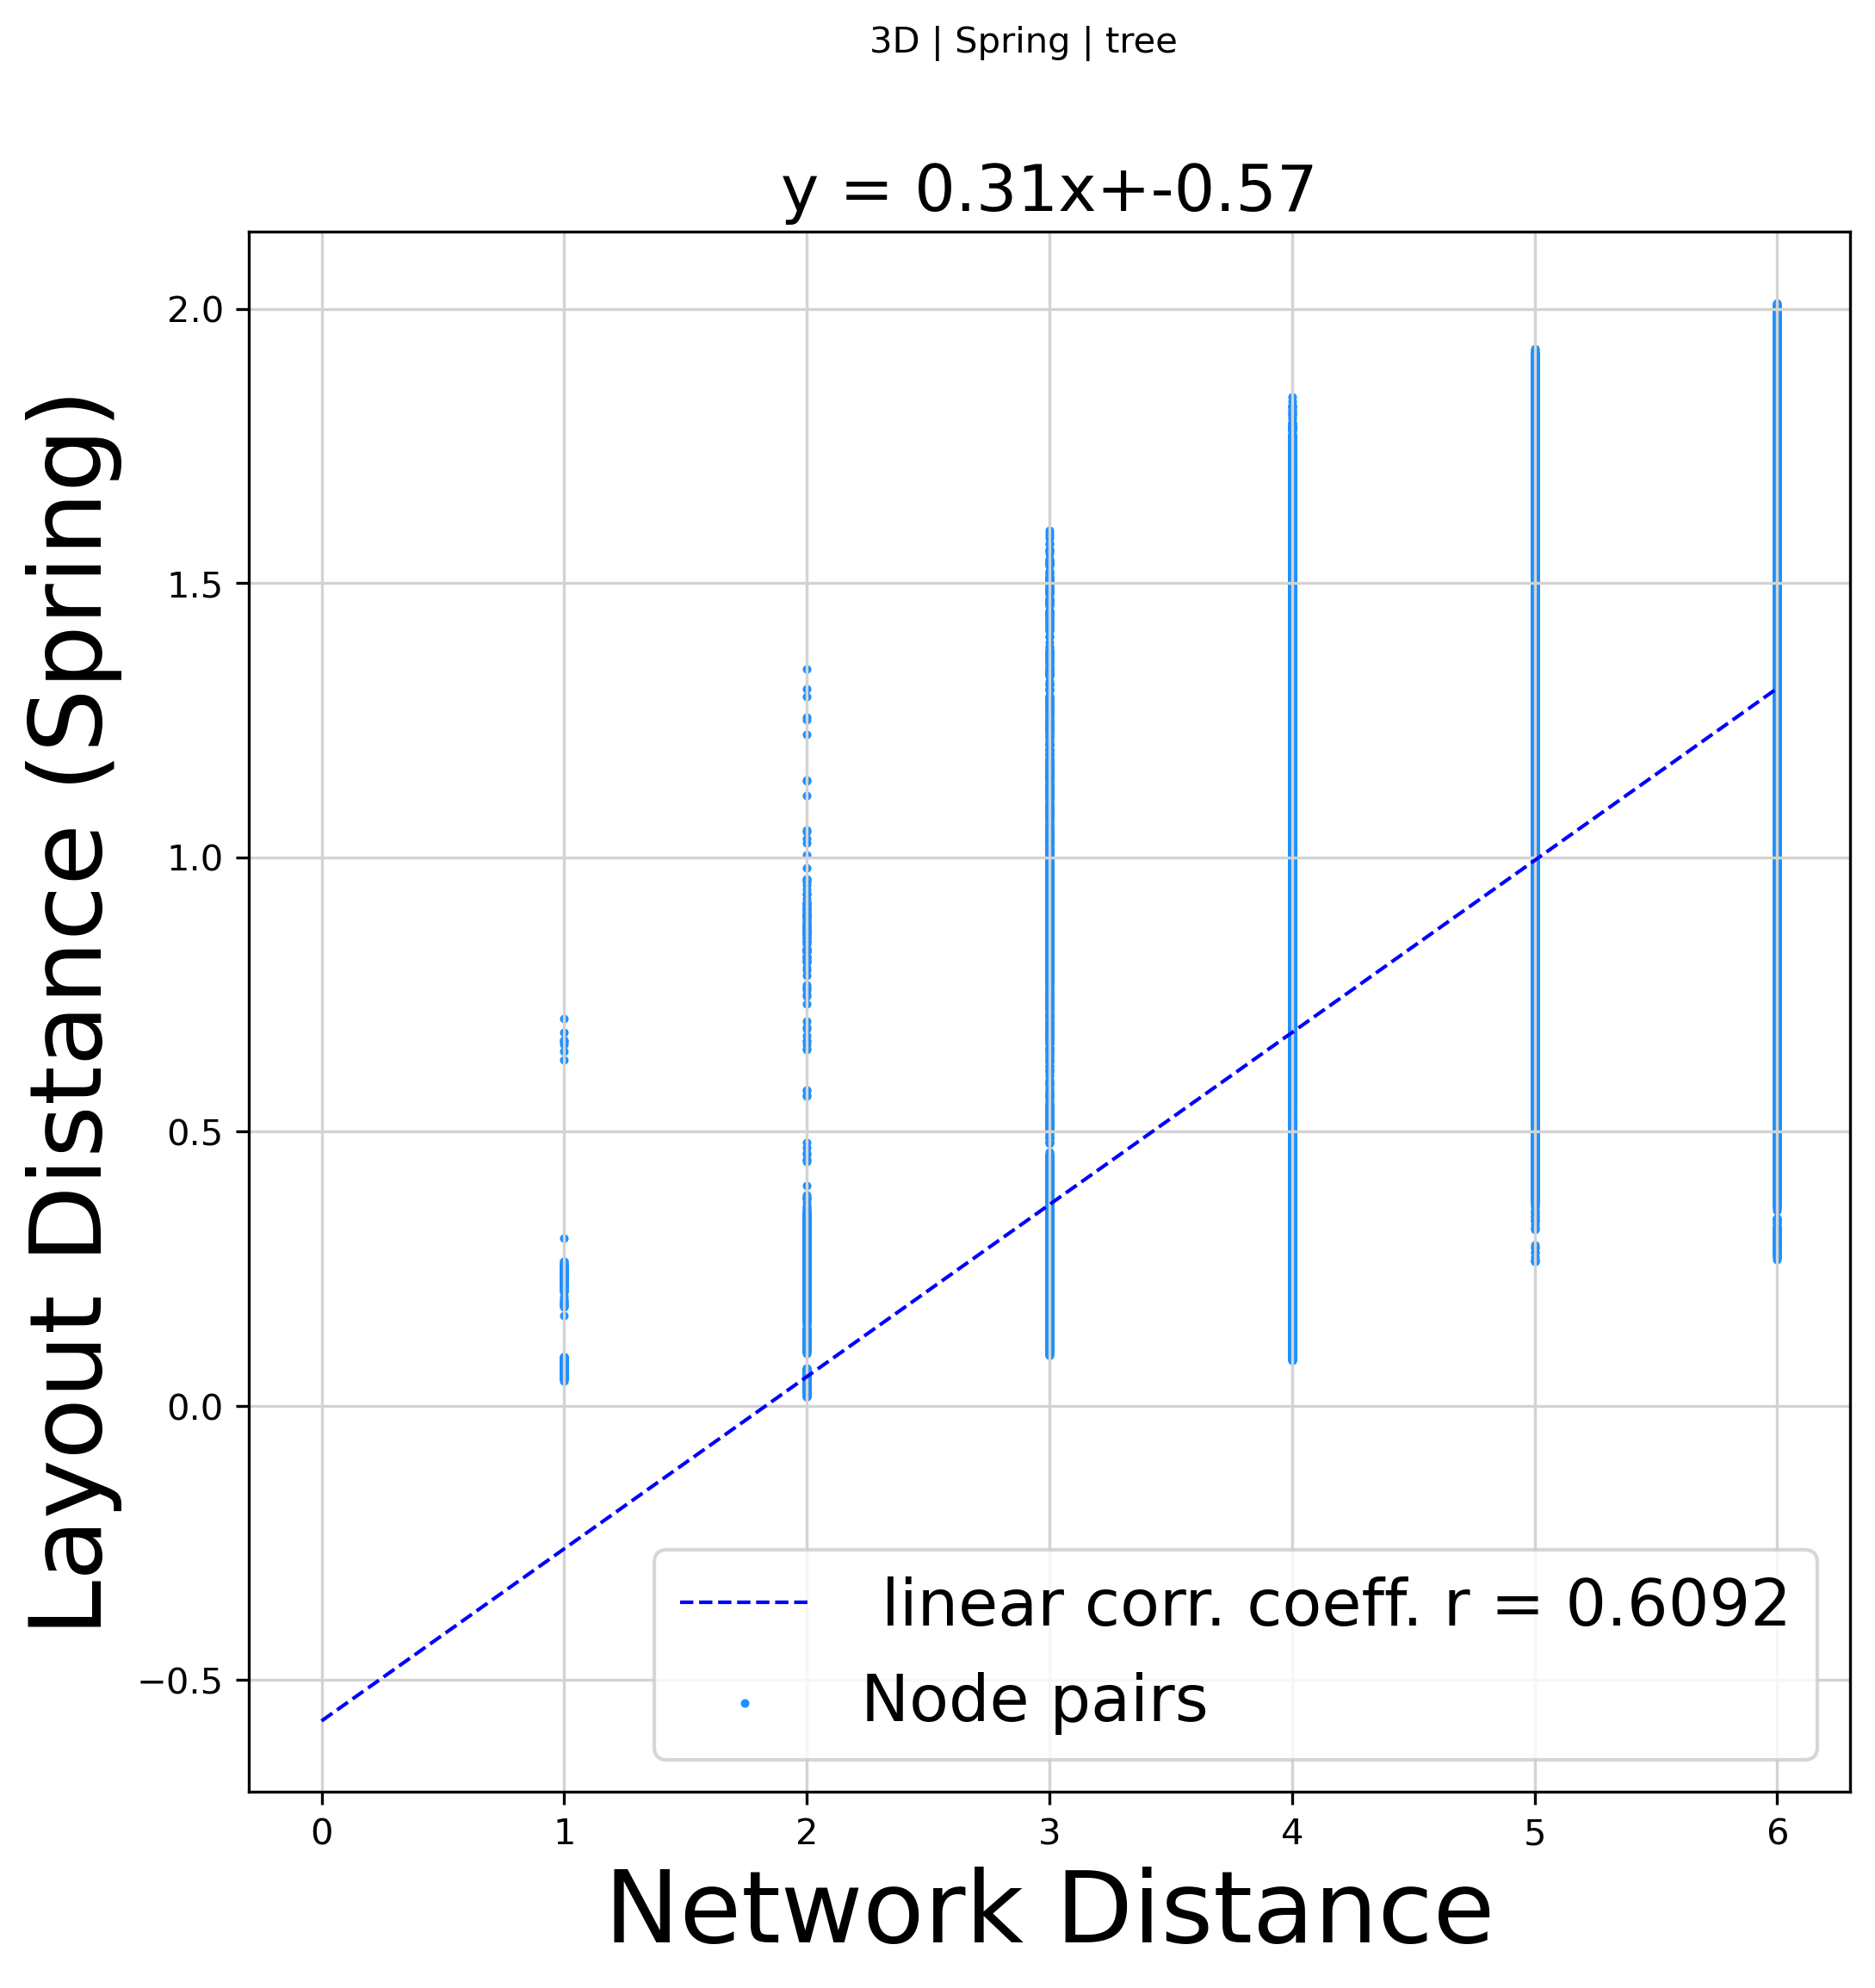

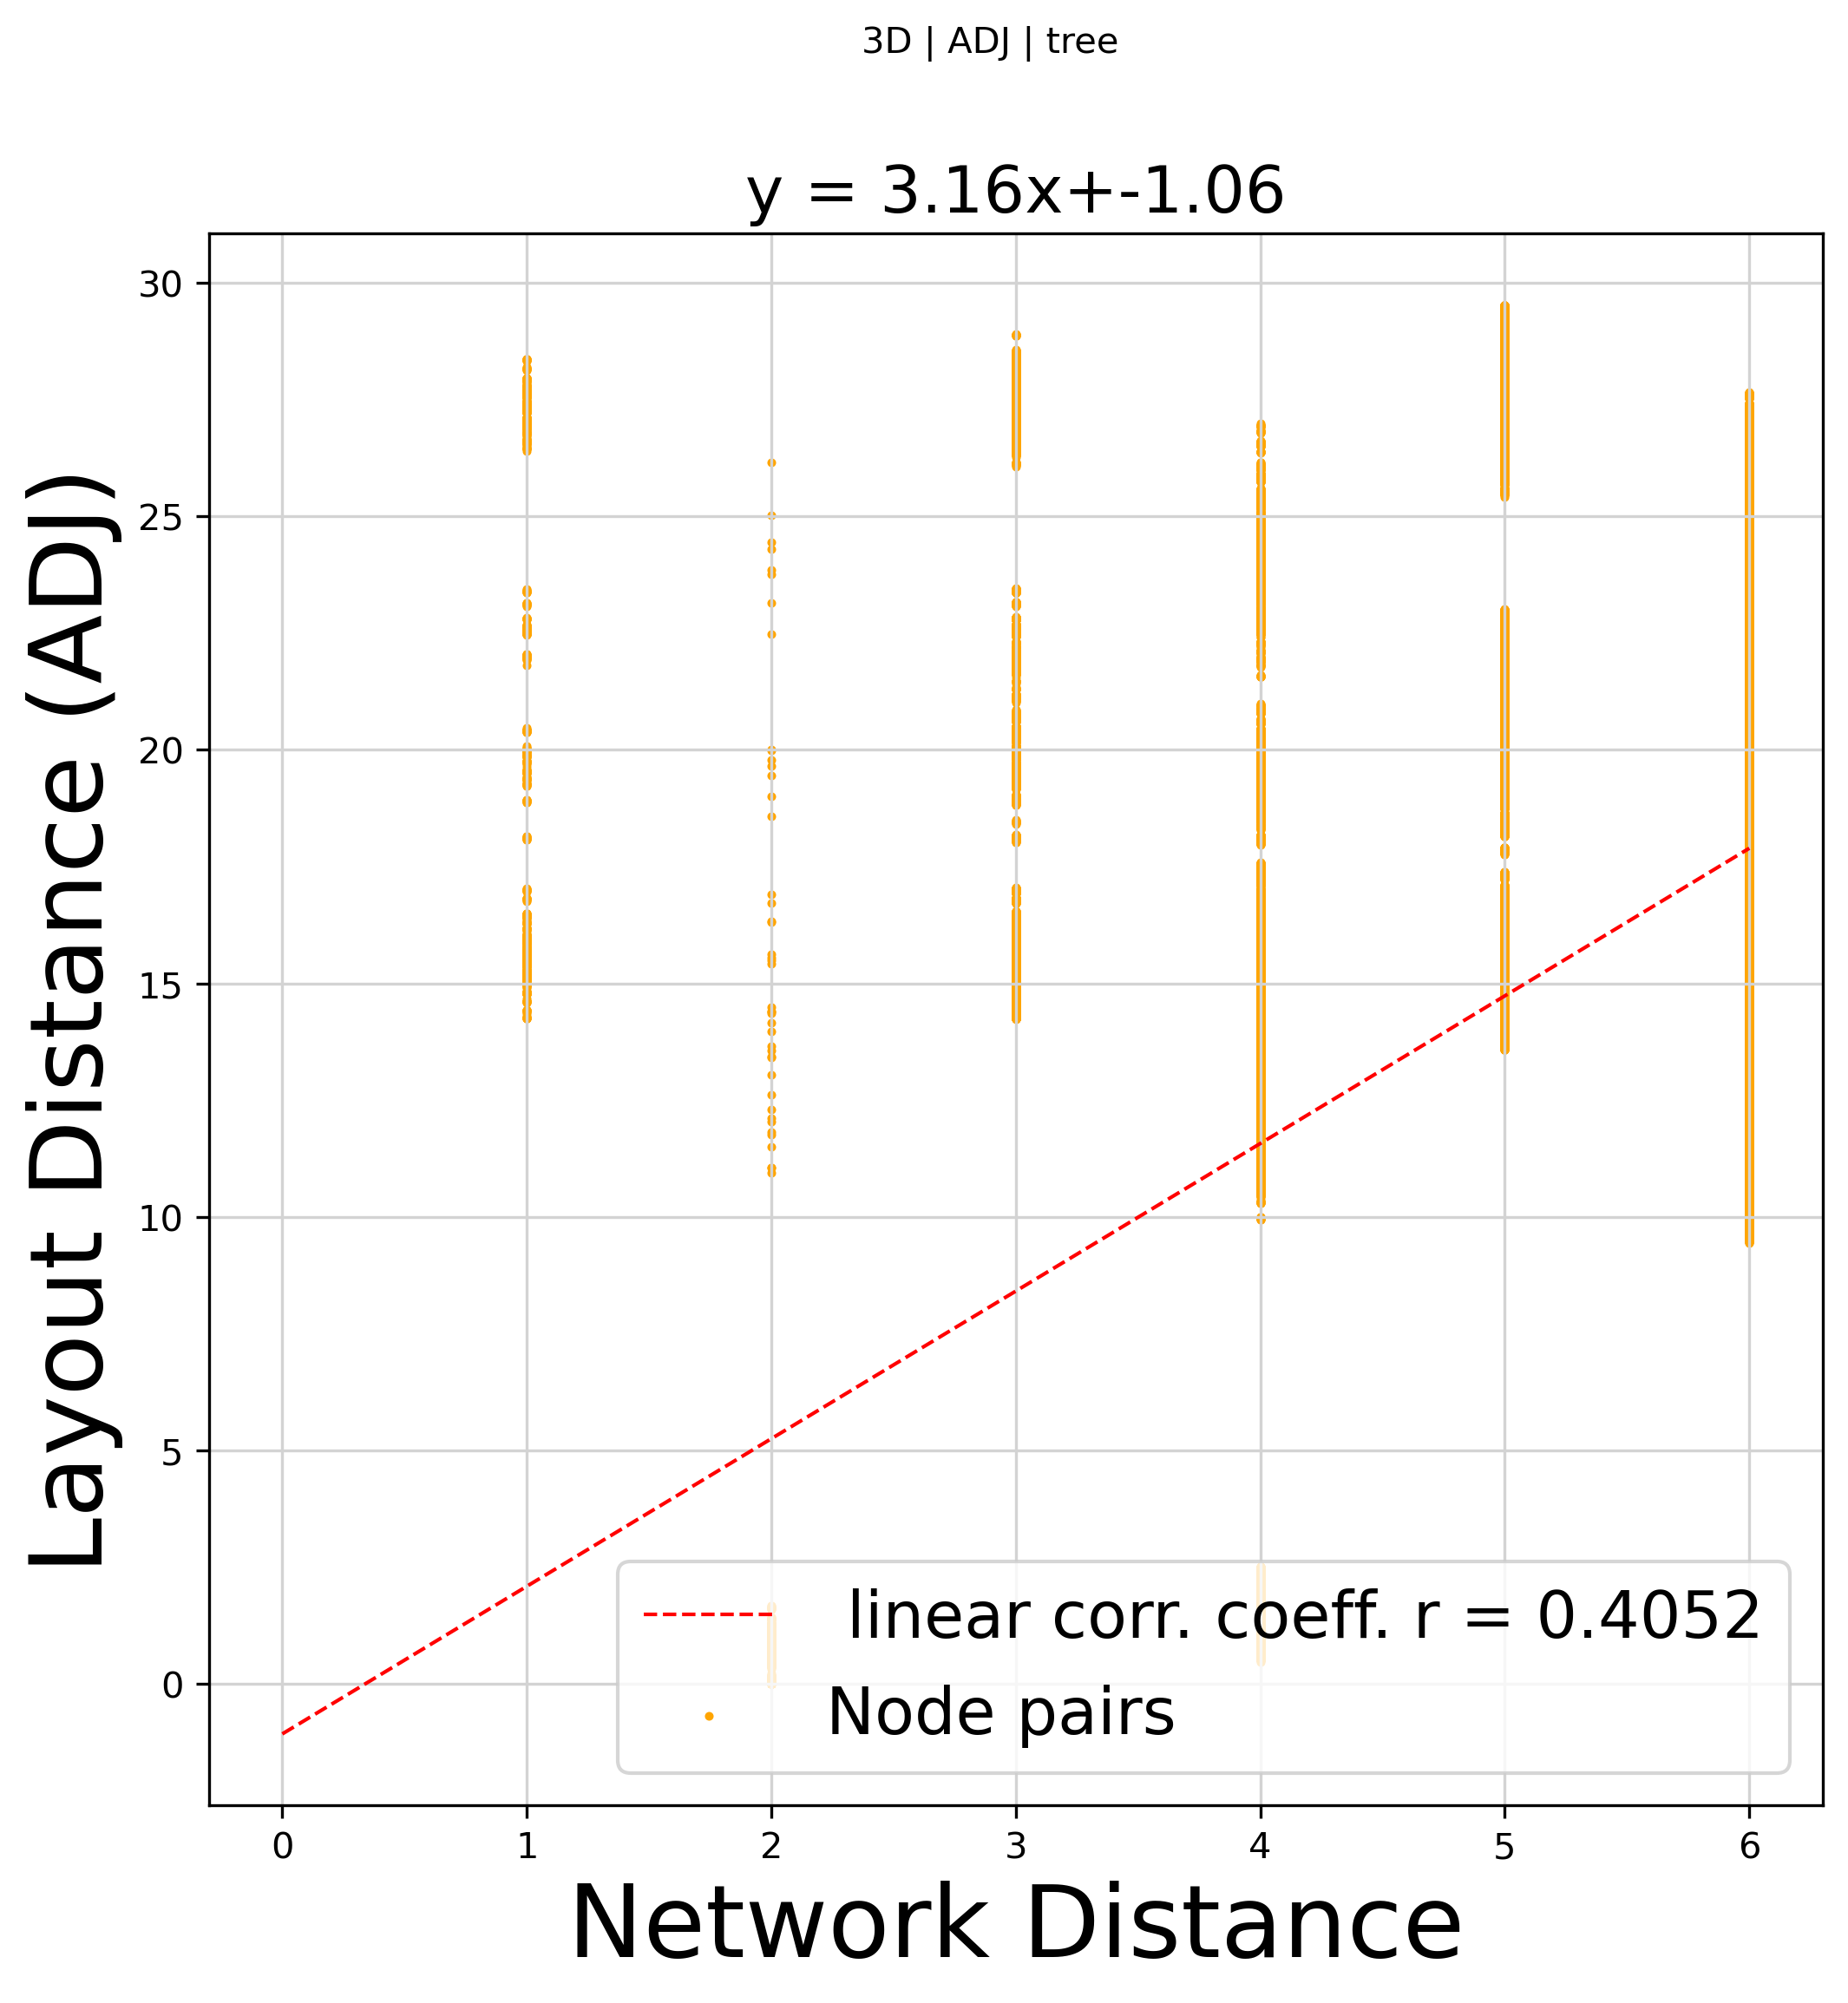

In [509]:









# NETWORK DISTANCE
# depending on Network (e.g. toy network) 
# changes only with toy network, not with layout chosen 

#dist_network # stays same as in 2D correlations
    

# SPRING
from itertools import combinations
dist_spring3D = dict()
for (id1,p1),(id2,p2) in combinations(posG_spring3D.items(),2):
    dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
    dist_spring3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)
    
    
# LAYOUT
from itertools import combinations
from itertools import combinations
dist_layout3D = dict()
for (id1,p1),(id2,p2) in combinations(posG_3D_complete_umap.items(),2):
    dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
    dist_layout3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)


# ------------------------------------------------------------
# get squareform dataframes from distances

# NETWORK DM to compare layouts with
#DM_spl_mod # stays same as in 2D correlations

# SPRING
dist_spring_list = [dist[1] for dist in sorted(dist_spring3D.items())]
df_spring3D = pd.DataFrame(dist.squareform(dist_spring_list), index=DM.index, columns=DM.columns)

# LAYOUT
dist_layout_list = [dist[1] for dist in sorted(dist_layout3D.items())]
df_layout3D = pd.DataFrame(dist.squareform(dist_layout_list), index=DM.index, columns=DM.columns)


# ------------------------------------------------------------
# remove all diagonal 0 values and values underneath diagonale (i.e. mirrored data)

# NETWORK DM # stays the same as in 2D correlations 
#DM_spl_mod


# SPRING
m,n = df_spring3D.shape
df_spring3D_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,df_spring3D))

# LAYOUT
m,n = df_layout3D.shape
df_layout3D_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,df_layout3D))


# ------------------------------------------------------------
# values of Dataframe into flattened list for Regression line

# Network DM to compare layouts with 
#l_DM_spl_flattened # stays same as in 2D correlations


# SPRING 
l_spring3D = []
for i in range(len(df_spring3D_mod)):
    l_spring3D.append(df_spring3D.iloc[i:i+1].values)

l_spring3D_un = list(it.chain(*l_spring3D))
l_spring3D_flattened = list(it.chain(*l_spring3D_un))


# LAYOUT
l_layout3D = []
for i in range(len(df_layout3D_mod)):
    l_layout3D.append(df_layout3D.iloc[i:i+1].values)

l_layout3D_un = list(it.chain(*l_layout3D))
l_layout3D_flattened = list(it.chain(*l_layout3D_un))


# ------------------------------------------------------------
# PLOT SPRING
# ------------------------------------------------------------

fig = plt.figure(figsize=(8,8), dpi=300)
plt.grid(True, c='lightgrey')

y_spring3D = df_spring3D_mod
x_spring3D = DM_spl_mod
plt.scatter(x_spring3D,y_spring3D, c = 'dodgerblue', s = 2)

# REGRESSION LINE 
y_regr_spring3D = l_spring3D_flattened
x_regr_spring3D = l_DM_spl_flattened
gradient_spring3D, intercept_spring3D, r_value_spring3D, p_value_spring3D, std_err_spring3D = stats.linregress(x_regr_spring3D,y_regr_spring3D)
mn_spring3D=np.min(x_regr_spring3D)
mx_spring3D=np.max(x_regr_spring3D)
x1_spring3D=np.linspace(mn_spring3D,mx_spring3D,500)
line_spring3D =gradient_spring3D*x1_spring3D+intercept_spring3D
plt.plot(x1_spring3D,line_spring3D,'--b',linewidth=1.0)

plt.ylabel("Layout Distance (Spring)", fontsize=labelsize)
plt.xlabel("Network Distance", fontsize=labelsize)

plt.legend((' linear corr. coeff. r = {}'.format(round(r_value_spring3D,4)),'Node pairs'), loc='lower right', fontsize = legendfontsize)

plt.suptitle('3D | Spring | '+organism, fontsize=10)
plt.title('y = {:.2f}x+{:.2f}'.format(gradient_spring3D,intercept_spring3D), fontsize=legendfontsize)

fig.savefig('output_plots/3Dtoynetwork_NetworkDistance_SPRING_'+feature+'_'+organism+'.png')



# ------------------------------------------------------------
# PLOT LAYOUT
# ------------------------------------------------------------

fig = plt.figure(figsize=(8,8), dpi=300)
plt.grid(True, c='lightgrey')

y_layout3D = df_layout3D_mod
x_layout3D = DM_spl_mod
plt.scatter(x_layout3D,y_layout3D, c = 'orange', s = 2)

# REGRESSION LINE 
y_regr_layout3D = l_layout3D_flattened
x_regr_layout3D = l_DM_spl_flattened
gradient_layout3D, intercept_layout3D, r_value_layout3D, p_value_layout3D, std_err_layout3D = stats.linregress(x_regr_layout3D,y_regr_layout3D)
mn_layout3D=np.min(x_regr_layout3D)
mx_layout3D=np.max(x_regr_layout3D)
x1_layout3D=np.linspace(mn_layout3D,mx_layout3D,500)
line_layout3D = gradient_layout3D*x1_layout3D+intercept_layout3D
plt.plot(x1_layout3D,line_layout3D,'--r',linewidth=1.0)

plt.ylabel("Layout Distance "+"("+feature+")", fontsize=labelsize)
plt.xlabel("Network Distance", fontsize=labelsize)

plt.legend((' linear corr. coeff. r = {}'.format(round(r_value_layout3D,4)),'Node pairs'), loc='lower right', fontsize = legendfontsize)

plt.suptitle('3D | '+feature+' | '+organism, fontsize=10)
plt.title('y = {:.2f}x+{:.2f}'.format(gradient_layout3D,intercept_layout3D), fontsize=legendfontsize)

fig.savefig('output_plots/3Dtoynetwork_NetworkDistance_LAYOUT_'+feature+'_'+organism+'.png')

+ ADJACENCIES

+ RANDOM WALK 

+ CENTRALITIES

____________
# O T H E R S 
____________


# Statistical Test for correlation (DMs to Layouts): 
### Pearson Correlation
+ Pearson product-moment correlation coefficients
+ The relationship between the correlation coefficient matrix, R, and the covariance matrix, C
+ Value can range from -1 to 1, the closer to 1 the more positive linear correlation ( the closer to -1 the more negative linear correlation)

In [847]:
# Pearson Correlation coefficient comparison of Spring- to Layouts-coordinates
from scipy.stats import pearsonr

print('Number of Nodes: ', len(G.nodes()))
print('Network: ', organism)
print('Layout: ', feature)
 
print('-----------------')

print('2D')
pearson_spring = pearsonr(l_spring2D_flattened, l_DM_flattened)
print('Spring: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_spring),10))

pearson_layout = pearsonr(l_layout2D_flattened, l_DM_flattened)
print('Layout: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_layout),10))

print('-----------------')

print('3D')
pearson_3Dspring = pearsonr(l_spring3D_flattened, l_DM_flattened)
print('Spring: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_3Dspring),10))

pearson_3Dlayout = pearsonr(l_layout3D_flattened, l_DM_flattened)
print('Layout: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_3Dlayout),10))

Number of Nodes:  1152
Network:  torus
Layout:  ADJ
-----------------
2D
Spring: Mean of Pearson Correlation Coefficient:  -0.0498182611
Layout: Mean of Pearson Correlation Coefficient:  0.0286888323
-----------------
3D
Spring: Mean of Pearson Correlation Coefficient:  -0.0630152746
Layout: Mean of Pearson Correlation Coefficient:  0.0282256621


In [848]:
# Save text as image : 
from PIL import Image, ImageDraw, ImageFont

image_pearson = Image.new('RGB', (1000,1000), 'white')
draw_pearson = ImageDraw.Draw(image_pearson)

font = ImageFont.truetype(r'input/NotoSansMono-Regular.ttf', 36)  
text_pearson = str(
           'CALCULATED DISTANCE vs. LAYOUT DISTANCE' + '\n' + 
           'Pearson Correlation Coefficient' + '\n' + 
           'Network: ' + organism + '\n' + 
           '____________' + '\n' +
           '\n' +
           '2D' + '\n' +
           'Layout: Spring' + '\n' +
           'Mean of Pearson Corr. Coeff.: ' + str(round(np.mean(pearson_spring),4)) + '\n' 
           '\n' +
           'Layout: ' + feature + '\n' +
           'Mean of Pearson Corr. Coeff.: ' + str(round(np.mean(pearson_layout),4)) + '\n' +
           '____________' + '\n' +
           '\n' +
           '3D' + '\n' +
           'Layout: Spring' + '\n' +
           'Mean of Pearson Corr. Coeff.: ' + str(round(np.mean(pearson_3Dspring),4)) + '\n' 
           '\n' +
           'Layout: ' + feature + '\n' +
           'Mean of Pearson Corr. Coeff.: ' + str(round(np.mean(pearson_3Dlayout),4)) + '\n' 
           )
           
        
# drawing text size 
draw_pearson.text((20, 20), text_pearson,  fill ="black", font = font, align ="left")

image_pearson.save('output_plots/Pearsoncoeff_CalcDistance_'+feature+'_'+organism+'.jpg')

### Spearman Correlation 
+ to summarize the strength of the linear relationship between two data samples (Rank correlation)
+ Compared to Pearson: assumes a non-gaussian distribution and less sensitive to outliers that are in the tail of both samples - because of limiting the outliers to the value of their ranks 
+ Value can range from -1 to 1, the closer to 1 the more monotonic relationship between X and Y

In [849]:
# Spearman Correlation coefficient comparison of Spring- to Layouts-coordinates

from scipy.stats import spearmanr

print('Number of Nodes: ', len(G.nodes()))
print('Network: ', organism)
print('Layout: ', feature)

print('-----------------')

print('2D')
spearman_spring, _ = spearmanr(l_spring2D_flattened, l_DM_flattened)
print('Spring: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_spring),4))

spearman_layout, _ = spearmanr(l_layout2D_flattened, l_DM_flattened)
print('Layout: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_layout),4))

print('-----------------')

print('3D')
spearman_3Dspring, _ = spearmanr(l_spring3D_flattened, l_DM_flattened)
print('Spring: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_3Dspring),4))

spearman_3Dlayout, _ = spearmanr(l_layout3D_flattened, l_DM_flattened)
print('Layout: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_3Dlayout),4))

Number of Nodes:  1152
Network:  torus
Layout:  ADJ
-----------------
2D
Spring: Mean of Spearman Correlation Coefficient:  -0.0977
Layout: Mean of Spearman Correlation Coefficient:  0.0518
-----------------
3D
Spring: Mean of Spearman Correlation Coefficient:  -0.1007
Layout: Mean of Spearman Correlation Coefficient:  0.0491


In [850]:
# Save text as image : 
from PIL import Image, ImageDraw, ImageFont

image_spearman = Image.new('RGB', (1000,1000), 'white')
draw_spearman = ImageDraw.Draw(image_spearman)

font = ImageFont.truetype(r'input/NotoSansMono-Regular.ttf', 36)  
text_spearman = str(
           'CALCULATED DISTANCE vs. LAYOUT DISTANCE' + '\n' + 
           'Spearman Correlation Coefficient' + '\n' + 
           'Network: ' + organism + '\n' + 
           '____________' + '\n' +
           '\n' +
           '2D' + '\n' +
           'Layout: Spring' + '\n' +
           'Mean of Spearman Corr. Coeff.: ' + str(round(np.mean(spearman_spring),4)) + '\n' 
           '\n' +
           'Layout: ' + feature + '\n' +
           'Mean of Spearman Corr. Coeff.: ' + str(round(np.mean(spearman_layout),4)) + '\n' +
           '____________' + '\n' +
           '\n' +
           '3D' + '\n' +
           'Layout: Spring' + '\n' +
           'Mean of Spearman Corr. Coeff.: ' + str(round(np.mean(spearman_3Dspring),4)) + '\n' 
           '\n' +
           'Layout: ' + feature + '\n' +
           'Mean of Spearman Corr. Coeff.: ' + str(round(np.mean(spearman_3Dlayout),4)) + '\n' 
           )
           
        
# drawing text size 
draw_spearman.text((20, 20), text_spearman,  fill ="black", font = font, align ="left")

image_spearman.save('output_plots/Spearmancoeff_CalcDistance_'+feature+'_'+organism+'.jpg')

# Statistical Test for correlation (NETWORK DM vs Layouts): 
### Pearson Correlation
+ Pearson product-moment correlation coefficients
+ The relationship between the correlation coefficient matrix, R, and the covariance matrix, C
+ Value can range from -1 to 1, the closer to 1 the more positive linear correlation ( the closer to -1 the more negative linear correlation)

In [854]:
# Pearson Correlation coefficient comparison of Spring- to Layouts-coordinates
from scipy.stats import pearsonr

print('Number of Nodes: ', len(G.nodes()))
print('Network: ', organism)
print('Layout: ', feature)
 
print('-----------------')

print('2D')
pearson_spring = pearsonr(l_spring2D_flattened, l_DM_spl_flattened)
print('Spring: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_spring),10))

pearson_layout = pearsonr(l_layout2D_flattened, l_DM_spl_flattened)
print('Layout: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_layout),10))

print('-----------------')

print('3D')
pearson_3Dspring = pearsonr(l_spring3D_flattened, l_DM_spl_flattened)
print('Spring: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_3Dspring),10))

pearson_3Dlayout = pearsonr(l_layout3D_flattened, l_DM_spl_flattened)
print('Layout: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_3Dlayout),10))

Number of Nodes:  1152
Network:  torus
Layout:  ADJ
-----------------
2D
Spring: Mean of Pearson Correlation Coefficient:  0.1068919822
Layout: Mean of Pearson Correlation Coefficient:  0.0381924523
-----------------
3D
Spring: Mean of Pearson Correlation Coefficient:  0.1296729829
Layout: Mean of Pearson Correlation Coefficient:  0.038874189


In [855]:
# Save text as image : 
from PIL import Image, ImageDraw, ImageFont

image_pearson = Image.new('RGB', (1000,1000), 'white')
draw_pearson = ImageDraw.Draw(image_pearson)

font = ImageFont.truetype(r'input/NotoSansMono-Regular.ttf', 36)  
text_pearson = str(
           'NETWORK DISTANCE vs. LAYOUT DISTANCE' + '\n' + 
           'Pearson Correlation Coefficient' + '\n' + 
           'Network: ' + organism + '\n' + 
           '____________' + '\n' +
           '\n' +
           '2D' + '\n' +
           'Layout: Spring' + '\n' +
           'Mean of Pearson Corr. Coeff.: ' + str(round(np.mean(pearson_spring),4)) + '\n' 
           '\n' +
           'Layout: ' + feature + '\n' +
           'Mean of Pearson Corr. Coeff.: ' + str(round(np.mean(pearson_layout),4)) + '\n' +
           '____________' + '\n' +
           '\n' +
           '3D' + '\n' +
           'Layout: Spring' + '\n' +
           'Mean of Pearson Corr. Coeff.: ' + str(round(np.mean(pearson_3Dspring),4)) + '\n' 
           '\n' +
           'Layout: ' + feature + '\n' +
           'Mean of Pearson Corr. Coeff.: ' + str(round(np.mean(pearson_3Dlayout),4)) + '\n' 
           )
           
        
# drawing text size 
draw_pearson.text((20, 20), text_pearson,  fill ="black", font = font, align ="left")

image_pearson.save('output_plots/Pearsoncoeff_NetworkDistance_'+feature+'_'+organism+'.jpg')

### Spearman Correlation 
+ to summarize the strength of the linear relationship between two data samples (Rank correlation)
+ Compared to Pearson: assumes a non-gaussian distribution and less sensitive to outliers that are in the tail of both samples - because of limiting the outliers to the value of their ranks 
+ Value can range from -1 to 1, the closer to 1 the more monotonic relationship between X and Y

In [856]:
# Spearman Correlation coefficient comparison of Spring- to Layouts-coordinates

from scipy.stats import spearmanr

print('Number of Nodes: ', len(G.nodes()))
print('Network: ', organism)
print('Layout: ', feature)

print('-----------------')

print('2D')
spearman_spring, _ = spearmanr(l_spring2D_flattened, l_DM_spl_flattened)
print('Spring: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_spring),4))

spearman_layout, _ = spearmanr(l_layout2D_flattened, l_DM_spl_flattened)
print('Layout: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_layout),4))

print('-----------------')

print('3D')
spearman_3Dspring, _ = spearmanr(l_spring3D_flattened, l_DM_spl_flattened)
print('Spring: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_3Dspring),4))

spearman_3Dlayout, _ = spearmanr(l_layout3D_flattened, l_DM_spl_flattened)
print('Layout: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_3Dlayout),4))

Number of Nodes:  1152
Network:  torus
Layout:  ADJ
-----------------
2D
Spring: Mean of Spearman Correlation Coefficient:  0.1915
Layout: Mean of Spearman Correlation Coefficient:  0.2081
-----------------
3D
Spring: Mean of Spearman Correlation Coefficient:  0.246
Layout: Mean of Spearman Correlation Coefficient:  0.2259


In [857]:
# Save text as image : 
from PIL import Image, ImageDraw, ImageFont

image_spearman = Image.new('RGB', (1000,1000), 'white')
draw_spearman = ImageDraw.Draw(image_spearman)

font = ImageFont.truetype(r'input/NotoSansMono-Regular.ttf', 36)  
text_spearman = str(
           'NETWORK DISTANCE vs. LAYOUT DISTANCE' + '\n' + 
           'Spearman Correlation Coefficient' + '\n' + 
           'Network: ' + organism + '\n' + 
           '____________' + '\n' +
           '\n' +
           '2D' + '\n' +
           'Layout: Spring' + '\n' +
           'Mean of Spearman Corr. Coeff.: ' + str(round(np.mean(spearman_spring),4)) + '\n' 
           '\n' +
           'Layout: ' + feature + '\n' +
           'Mean of Spearman Corr. Coeff.: ' + str(round(np.mean(spearman_layout),4)) + '\n' +
           '____________' + '\n' +
           '\n' +
           '3D' + '\n' +
           'Layout: Spring' + '\n' +
           'Mean of Spearman Corr. Coeff.: ' + str(round(np.mean(spearman_3Dspring),4)) + '\n' 
           '\n' +
           'Layout: ' + feature + '\n' +
           'Mean of Spearman Corr. Coeff.: ' + str(round(np.mean(spearman_3Dlayout),4)) + '\n' 
           )
           
        
# drawing text size 
draw_spearman.text((20, 20), text_spearman,  fill ="black", font = font, align ="left")

image_spearman.save('output_plots/Spearmancoeff_NetworkDistance_'+feature+'_'+organism+'.jpg')